In [6]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
%matplotlib inline 

In [7]:

# Function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel],
                                    orient, pix_per_cell, cell_per_block,
                                    vis=False, feature_vec=True))
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)


In [8]:
# Define a function you will pass an image
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB',
                    spatial_size=(32, 32), hist_bins=32,
                    hist_range=(0, 256), orient=9,
                    pix_per_cell=8, cell_per_block=2,
                    hog_channel=0, spatial_feat=True,
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space,
                            spatial_size=spatial_size, hist_bins=hist_bins,
                            orient=orient, pix_per_cell=pix_per_cell,
                            cell_per_block=cell_per_block,
                            hog_channel=hog_channel, spatial_feat=spatial_feat,
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [9]:
# Read in cars and notcars
cars = []
notcars = []
list1 = ["cars1", "cars2", "cars3", "GTI_Far", "GTI_Left", "GTI_MiddleClose", "GTI_Right", "KITTI_extracted"]
for l in list1:
    images1 = glob.glob('vehicles/' + l + '/*')    
    for image in images1:
        cars.append(image)
        
# shuffle cars images
cars = shuffle(cars)
print("vehicles images:{}".format(len(cars)))

list2 = { "notcars1", "notcars1", "notcars3", "Extras", "GTI" }
for l in list2:
    images2 = glob.glob('non-vehicles/' + l + '/*')    
    for image in images2:
        notcars.append(image)    

notcars = shuffle(notcars)
print("non-vehicles images:{}".format(len(notcars)))

vehicles images:9988
non-vehicles images:9693


In [133]:
def plot_2_images(title1, img1, title2, img2):
    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(img1)
    plt.title(title1)
    plt.subplot(122)
    plt.imshow(img2)
    plt.title(title2)

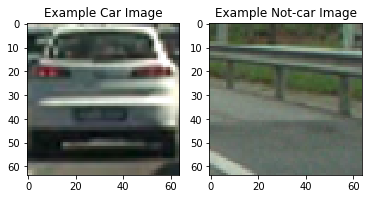

In [134]:
# show 2 random images
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

plot_2_images('Example Car Image', car_image, 'Example Not-car Image', notcar_image)

In [129]:
# Parameters
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, None] # Min and max in y to search in slide_window()

In [130]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=True,
                       visualise=vis, feature_vector=feature_vec)
        return features


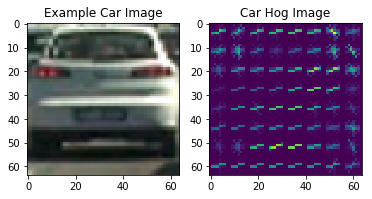

In [136]:
# print hog image
feature_image = cv2.cvtColor(car_image, cv2.COLOR_RGB2YCrCb)
features, hog_image = get_hog_features(feature_image[:,:,0], orient, pix_per_cell, cell_per_block, True, False)

plot_2_images('Example Car Image', car_image, 'Car Hog Image', hog_image)

In [137]:
# Define a function to compute binned color features
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()
    # Return the feature vector
    return features

In [138]:
# Define a function to compute color histogram features
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [143]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    print("extract_features imgs#:{}".format(len(imgs)))
    #dbg_i = 0
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        if file.find('.png') >= 0:
            img255 = image * 255
            #if dbg_i == 0:
            #    print("PNG:{} = {}, -> 255 scale:{}", file, image, img255)
            #    dbg_i += 1
            image = img255.astype(np.uint8)
        
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel],
                                        orient, pix_per_cell, cell_per_block,
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


In [140]:
# Define a function that takes an image,
# start and stop positions in both x and y,
# window size (x and y dimensions),
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    #print("slide_window x_start_stop:{}, y_start_stop:{}".format(x_start_stop, y_start_stop))
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step)
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step)
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]

            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [141]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [144]:
# have car features and not-car features
car_features = extract_features(cars, color_space=color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins,
                        orient=orient, pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_feat=spatial_feat,
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins,
                        orient=orient, pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_feat=spatial_feat,
                        hist_feat=hist_feat, hog_feat=hog_feat)



extract_features imgs#:9988
extract_features imgs#:9693


In [19]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)


In [20]:
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


In [21]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))


Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6156


In [22]:
# Use a linear SVC to train data
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample


17.08 Seconds to train SVC...
Test Accuracy of SVC =  0.9919


In [78]:
# utilty to combine overlapped rectangles 
def combine_winboxes(winboxes):
    result = []
    if len(winboxes) == 0:
        return result
    if len(winboxes) == 1:
        return winboxes

    cur = winboxes[0]
    for i in range(1, len(winboxes)):
        box = winboxes[i]
        if ((box[0][0] >= cur[0][0] and box[0][0] <= cur[1][0]) and \
            ((box[0][1] >= cur[0][1] and box[0][1] <= cur[1][1]) or \
             (box[0][1] <= cur[0][1] and box[1][1] >= cur[0][1]))):
            cur = (min(cur[0], box[0]), max(cur[1], box[1]))
        else:
             result.append(cur)
             cur = box
            
    if len(result) == 0 or cur != result[len(result)-1]:
        result.append(cur)
    return result

In [122]:
# uitility to detect car and return corresponding boxes
def detect_boxes(image):
    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    #image = image.astype(np.float32)/255

    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

    boxes = combine_winboxes(hot_windows)
    if (len(hot_windows) > 0) and (hot_windows != boxes):
        print("hot_windows:{}, combined:{}".format(hot_windows, boxes))
    return boxes

In [90]:
# utility to detect car with sliding windows
def detect_car(image):
    draw_image = np.copy(image)
    boxes = detect_boxes(draw_image)
    window_img = draw_boxes(draw_image, boxes, color=(0, 0, 255), thick=6)                    
    return window_img

In [24]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

In [25]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars_boxlist(img, ystart, ystop, xstart, xstop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    boxlist = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                #print(xbox_left, ytop_draw+ystart,xbox_left+win_draw,ytop_draw+win_draw+ystart)
                boxlist.append(((xbox_left+xstart, ytop_draw+ystart),(xbox_left+xstart+win_draw,ytop_draw+win_draw+ystart)))
                
    return boxlist
    

In [27]:
# utilities to apply heat
from scipy.ndimage.measurements import label
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [61]:
# utility to find cars with help of heat map
def find_cars_with_heat_map(img, thresh):
    #ystart = 400, ystop = 656, scale = 1
    tests = [(400, 650, 950, 1280, 2.0), (400, 500, 950, 1280, 1.5), 
             (400, 650, 0, 330, 2.0), (400, 500, 0, 330, 1.5),
            (400, 460, 330, 950, 0.75)]
    
    # create heat map
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    for test in tests:
        ystart = test[0]
        ystop = test[1]
        xstart = test[2]
        xstop = test[3]
        scale = test[4]
        box_list = find_cars_boxlist(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        # Add heat to each box in box list
        heat = add_heat(heat,box_list)
           
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, thresh)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img, heatmap

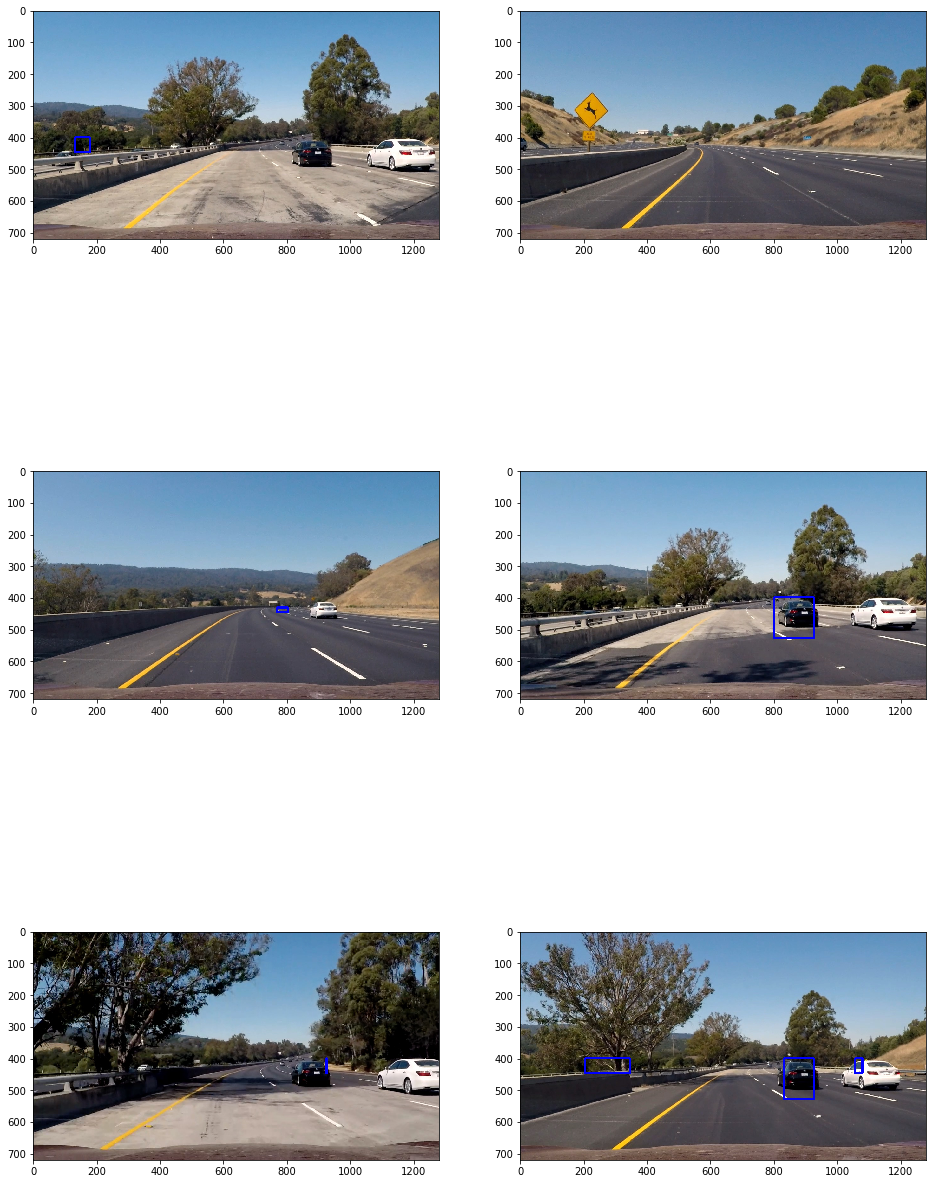

In [62]:
#img = image = mpimg.imread('test_images/test1.jpg')    
# check with test images
test_images = glob.glob('test_images/*.jpg')   
cols = 2
rows = 3
i = 0
plt.figure(figsize=(cols * 8, rows * 8))
for img_name in test_images:
    image = mpimg.imread(img_name)
    window_img, heatmap = find_cars_with_heat_map(image, 3)
    plt.subplot(rows,cols,i+1)
    plt.imshow(window_img)
    i += 1

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((1056, 400), (1152, 496)), ((1152, 400), (1248, 496))], combined:[((816, 400), (960, 496)), ((1056, 400), (1248, 496))]
hot_windows:[], combined:[]
hot_windows:[((864, 400), (960, 496))], combined:[((864, 400), (960, 496))]
hot_windows:[((816, 400), (912, 496)), ((1056, 400), (1152, 496))], combined:[((816, 400), (912, 496)), ((1056, 400), (1152, 496))]
hot_windows:[((480, 400), (576, 496)), ((768, 400), (864, 496)), ((816, 400), (912, 496)), ((864, 400), (960, 496)), ((1104, 400), (1200, 496))], combined:[((480, 400), (576, 496)), ((768, 400), (960, 496)), ((1104, 400), (1200, 496))]
hot_windows:[((816, 400), (912, 496)), ((1008, 400), (1104, 496)), ((1056, 400), (1152, 496))], combined:[((816, 400), (912, 496)), ((1008, 400), (1152, 496))]


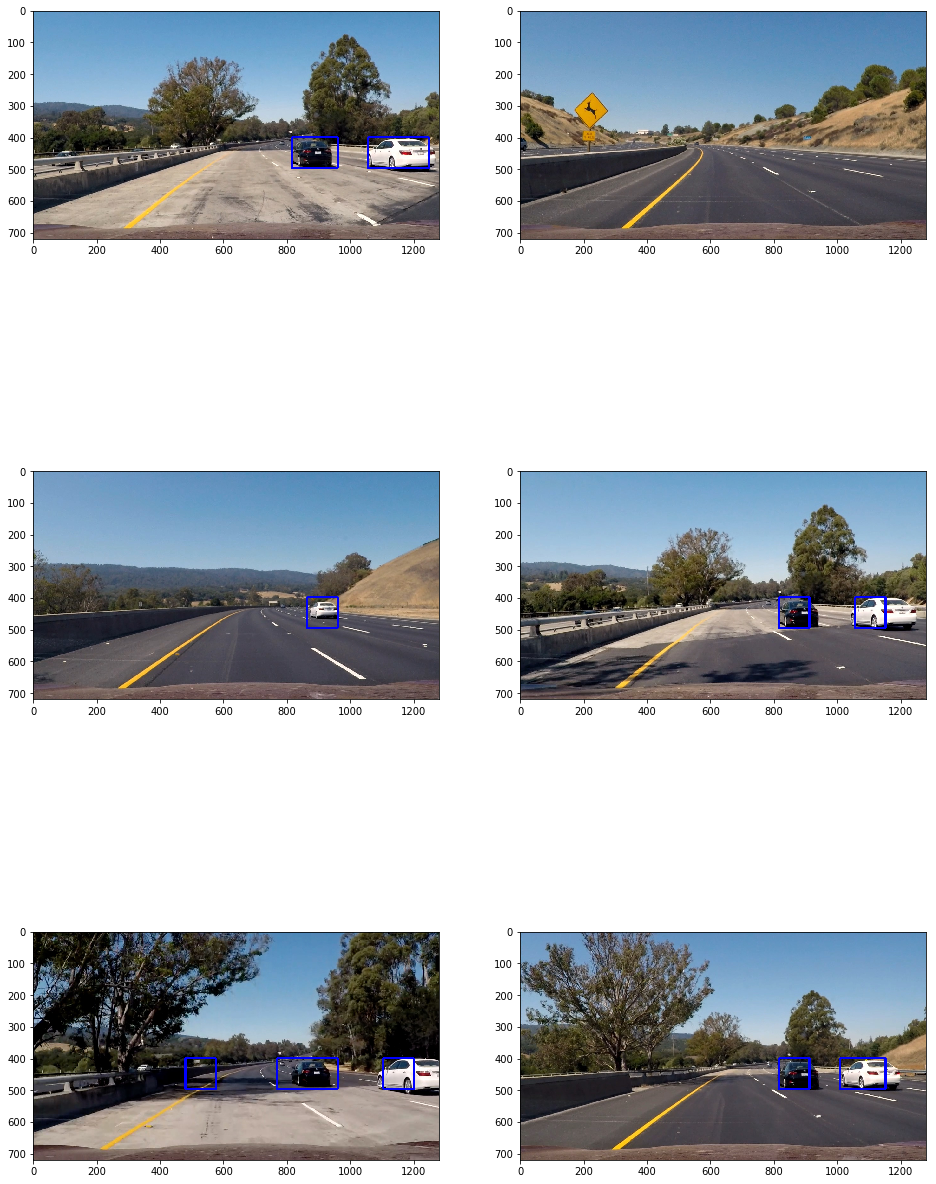

In [80]:
# check with test images
test_images = glob.glob('test_images/*.jpg')   
cols = 2
rows = 3
i = 0
plt.figure(figsize=(cols * 8, rows * 8))
for img_name in test_images:
    image = mpimg.imread(img_name)
    window_img = detect_car(image)
    plt.subplot(rows,cols,i+1)
    plt.imshow(window_img)
    i += 1

In [124]:
# uitility to look up a box inside a list of boxes
def lookupBoxes(x, boxes):
    if (len(boxes) == 0) or (x[1][0] < boxes[0][0][0]) or (x[0][0] > boxes[len(boxes)-1][0][0]):
        return None
    
    for b in boxes:
        if ((b[0][0] >= x[0][0] and b[0][0] <= x[1][0]) or \
            (x[0][0] >= b[0][0] and x[0][0] <= b[1][0])) and \
            ((b[0][1] >= x[0][1] and b[0][1] <= x[1][1]) or \
             (b[0][1] <= x[0][1] and b[1][1] >= x[0][1])):
                return b
        if ((b[1][0] >= x[0][0] and b[1][0] <= x[1][0]) or \
            (x[1][0] >= b[0][0] and x[1][0] <= b[1][0])) and \
            ((b[0][1] >= x[0][1] and b[0][1] <= x[1][1]) or \
             (b[0][1] <= x[0][1] and b[1][1] >= x[0][1])):
                return b
    return None

# utility to smooth box size across 3 items
def smoothBoxSizes3(curBox, a, b):
    wd = abs(curBox[1][0] - curBox[0][0]) + abs(a[1][0] - a[0][0]) + abs(b[1][0] - b[0][0]) 
    wd /= 3
    ht = abs(curBox[1][1] - curBox[0][1]) + abs(a[1][1] - a[0][1]) + abs(b[1][1] - b[0][1])
    ht /= 3
    #a[1][0] = a[0][0] + wd
    #a[1][1] = a[0][1] + ht
    return ((curBox[0][0], curBox[0][1]), (curBox[0][0] + int(wd),  curBox[0][1] + int(ht)))

# utility to smooth box size across 2 items
def smoothBoxSizes2(curBox, a):
    if curBox == a:
        return curBox
    
    wd = abs(curBox[1][0] - curBox[0][0]) + abs(a[1][0] - a[0][0]) 
    wd /= 2
    ht = abs(curBox[1][1] - curBox[0][1]) + abs(a[1][1] - a[0][1]) 
    ht /= 2
    #a[1][0] = a[0][0] + wd
    #a[1][1] = a[0][1] + ht
    return ((curBox[0][0], curBox[0][1]), (curBox[0][0] + int(wd),  curBox[0][1] + int(ht)))
        

In [119]:
# utilty to process boxes
# when a box appears only in the middle but not old or new, drop it
# smooth the middle boxes by averaging size with new and old
# return midBoxes
def process_boxes(newBoxes, midBoxes, oldBoxes):
    mid_result = []
   
    for x in midBoxes:
        n1 = lookupBoxes(x, newBoxes)
        o1 = lookupBoxes(x, oldBoxes)
        print("lookupBoxes x:{}, n1:{}, o1:{}".format(x, n1, o1))
        if (n1 != None) and (o1 != None):
            mid_result.append(smoothBoxSizes3(x, n1, o2))
        elif n1 != None:
            mid_result.append(smoothBoxSizes2(x, n1))
        elif o1 != None:
            mid_result.append(smoothBoxSizes2(x, o1))
        else:
            print("dropped :{}".format(x))
  
    return mid_result

In [115]:
# class to hold video state across video frames
class MyCarState:
    def __init__(self):
        self.cleanup()
    
    def cleanup(self):
        self.count = 0  # frame count
        self.prior_boxes = [] # prior boxes
        self.oldest_boxes = [] # older than prior
        self.prior_image = None # cached image

In [120]:
# process image for video
def proc_img(image):
    myCarState.count += 1
    draw_image = np.copy(image)
    if myCarState.count == 1:
        myCarState.prior_image = draw_image
        myCarState.prior_boxes = detect_boxes(draw_image)
        window_img = draw_boxes(myCarState.prior_image,  myCarState.prior_boxes, color=(0, 0, 255), thick=6) 
        return window_img
    
    oldBoxes = myCarState.prior_boxes
    newBoxes = detect_boxes(draw_image)
    updated_prior_boxes = process_boxes(newBoxes, myCarState.prior_boxes, myCarState.oldest_boxes)

    window_img = draw_boxes(myCarState.prior_image,  updated_prior_boxes, color=(0, 0, 255), thick=6) 
    myCarState.oldestBoxes = oldBoxes
    myCarState.prior_boxes = newBoxes
    myCarState.prior_image = draw_image

    return window_img

In [35]:
def process_vid(image):
    #global dbg_frame_idx
    #window_img, heatmap = find_cars_with_heat_map(image)
    
    window_img = detect_car(image)
    #dbg_frame_idx += 1
    return window_img

In [125]:
from moviepy.editor import VideoFileClip
global myCarState
myCarState = MyCarState()
video_output = 'output_images/test_video.mp4'

clip1 = VideoFileClip('test_video.mp4')
white_clip = clip1.fl_image(proc_img)
white_clip.write_videofile(video_output, audio=False)
print("frame count:{}".format(myCarState.count))

[MoviePy] >>>> Building video output_images/test_video.mp4
[MoviePy] Writing video output_images/test_video.mp4





  0%|          | 0/39 [00:00<?, ?it/s]


  3%|▎         | 1/39 [00:00<00:20,  1.83it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1008, 400), (1104, 496)), n1:((1008, 400), (1104, 496)), o1:None





  5%|▌         | 2/39 [00:01<00:20,  1.81it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1008, 400), (1104, 496)), n1:((1008, 400), (1104, 496)), o1:None





  8%|▊         | 3/39 [00:01<00:19,  1.83it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1008, 400), (1104, 496)), n1:((1008, 400), (1104, 496)), o1:None





 10%|█         | 4/39 [00:02<00:19,  1.84it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1008, 400), (1104, 496)), n1:((1008, 400), (1104, 496)), o1:None





 13%|█▎        | 5/39 [00:02<00:18,  1.85it/s]

hot_windows:[((816, 400), (912, 496)), ((1008, 400), (1104, 496)), ((1056, 400), (1152, 496))], combined:[((816, 400), (912, 496)), ((1008, 400), (1152, 496))]
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1008, 400), (1104, 496)), n1:((1008, 400), (1152, 496)), o1:None





 15%|█▌        | 6/39 [00:03<00:17,  1.87it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1008, 400), (1152, 496)), n1:((1008, 400), (1104, 496)), o1:None





 18%|█▊        | 7/39 [00:03<00:16,  1.89it/s]

hot_windows:[((816, 400), (912, 496)), ((1008, 400), (1104, 496)), ((1056, 400), (1152, 496))], combined:[((816, 400), (912, 496)), ((1008, 400), (1152, 496))]
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1008, 400), (1104, 496)), n1:((1008, 400), (1152, 496)), o1:None





 21%|██        | 8/39 [00:04<00:16,  1.91it/s]

hot_windows:[((816, 400), (912, 496)), ((1008, 400), (1104, 496)), ((1056, 400), (1152, 496))], combined:[((816, 400), (912, 496)), ((1008, 400), (1152, 496))]
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1008, 400), (1152, 496)), n1:((1008, 400), (1152, 496)), o1:None





 23%|██▎       | 9/39 [00:04<00:15,  1.90it/s]

hot_windows:[((816, 400), (912, 496)), ((1008, 400), (1104, 496)), ((1056, 400), (1152, 496))], combined:[((816, 400), (912, 496)), ((1008, 400), (1152, 496))]
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1008, 400), (1152, 496)), n1:((1008, 400), (1152, 496)), o1:None





 26%|██▌       | 10/39 [00:05<00:15,  1.91it/s]

hot_windows:[((816, 400), (912, 496)), ((1008, 400), (1104, 496)), ((1056, 400), (1152, 496))], combined:[((816, 400), (912, 496)), ((1008, 400), (1152, 496))]
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1008, 400), (1152, 496)), n1:((1008, 400), (1152, 496)), o1:None





 28%|██▊       | 11/39 [00:05<00:14,  1.92it/s]

hot_windows:[((816, 400), (912, 496)), ((1008, 400), (1104, 496)), ((1056, 400), (1152, 496))], combined:[((816, 400), (912, 496)), ((1008, 400), (1152, 496))]
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1008, 400), (1152, 496)), n1:((1008, 400), (1152, 496)), o1:None





 31%|███       | 12/39 [00:06<00:14,  1.92it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:None, o1:None
dropped :((816, 400), (912, 496))
lookupBoxes x:((1008, 400), (1152, 496)), n1:None, o1:None
dropped :((1008, 400), (1152, 496))





 33%|███▎      | 13/39 [00:06<00:13,  1.93it/s]

hot_windows:[((816, 400), (912, 496)), ((1008, 400), (1104, 496)), ((1056, 400), (1152, 496)), ((96, 448), (192, 544))], combined:[((816, 400), (912, 496)), ((1008, 400), (1152, 496)), ((96, 448), (192, 544))]
lookupBoxes x:((816, 400), (912, 496)), n1:None, o1:None
dropped :((816, 400), (912, 496))
lookupBoxes x:((1008, 400), (1104, 496)), n1:None, o1:None
dropped :((1008, 400), (1104, 496))
lookupBoxes x:((144, 448), (240, 544)), n1:None, o1:None
dropped :((144, 448), (240, 544))





 36%|███▌      | 14/39 [00:07<00:12,  1.93it/s]

hot_windows:[((816, 400), (912, 496)), ((1008, 400), (1104, 496)), ((1056, 400), (1152, 496))], combined:[((816, 400), (912, 496)), ((1008, 400), (1152, 496))]
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1008, 400), (1152, 496)), n1:((1008, 400), (1152, 496)), o1:None
lookupBoxes x:((96, 448), (192, 544)), n1:None, o1:None
dropped :((96, 448), (192, 544))





 38%|███▊      | 15/39 [00:07<00:12,  1.94it/s]

hot_windows:[((816, 400), (912, 496)), ((1008, 400), (1104, 496)), ((1056, 400), (1152, 496))], combined:[((816, 400), (912, 496)), ((1008, 400), (1152, 496))]
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1008, 400), (1152, 496)), n1:((1008, 400), (1152, 496)), o1:None





 41%|████      | 16/39 [00:08<00:11,  1.94it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1008, 400), (1152, 496)), n1:((1008, 400), (1104, 496)), o1:None





 44%|████▎     | 17/39 [00:08<00:11,  1.93it/s]

hot_windows:[((816, 400), (912, 496)), ((1008, 400), (1104, 496)), ((1056, 400), (1152, 496))], combined:[((816, 400), (912, 496)), ((1008, 400), (1152, 496))]
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1008, 400), (1104, 496)), n1:((1008, 400), (1152, 496)), o1:None





 46%|████▌     | 18/39 [00:09<00:10,  1.93it/s]

hot_windows:[((816, 400), (912, 496)), ((1008, 400), (1104, 496)), ((1056, 400), (1152, 496))], combined:[((816, 400), (912, 496)), ((1008, 400), (1152, 496))]
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1008, 400), (1152, 496)), n1:((1008, 400), (1152, 496)), o1:None





 49%|████▊     | 19/39 [00:09<00:10,  1.93it/s]

hot_windows:[((816, 400), (912, 496)), ((1008, 400), (1104, 496)), ((1056, 400), (1152, 496)), ((240, 544), (336, 640)), ((432, 592), (528, 688))], combined:[((816, 400), (912, 496)), ((1008, 400), (1152, 496)), ((240, 544), (336, 640)), ((432, 592), (528, 688))]
lookupBoxes x:((816, 400), (912, 496)), n1:None, o1:None
dropped :((816, 400), (912, 496))
lookupBoxes x:((1008, 400), (1152, 496)), n1:None, o1:None
dropped :((1008, 400), (1152, 496))





 51%|█████▏    | 20/39 [00:10<00:09,  1.95it/s]

hot_windows:[((816, 400), (912, 496)), ((1008, 400), (1104, 496)), ((1056, 400), (1152, 496)), ((480, 496), (576, 592)), ((144, 592), (240, 688))], combined:[((816, 400), (912, 496)), ((1008, 400), (1152, 496)), ((480, 496), (576, 592)), ((144, 592), (240, 688))]
lookupBoxes x:((816, 400), (912, 496)), n1:None, o1:None
dropped :((816, 400), (912, 496))
lookupBoxes x:((1008, 400), (1152, 496)), n1:None, o1:None
dropped :((1008, 400), (1152, 496))
lookupBoxes x:((240, 544), (336, 640)), n1:None, o1:None
dropped :((240, 544), (336, 640))
lookupBoxes x:((432, 592), (528, 688)), n1:None, o1:None
dropped :((432, 592), (528, 688))





 54%|█████▍    | 21/39 [00:10<00:09,  1.96it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:None, o1:None
dropped :((816, 400), (912, 496))
lookupBoxes x:((1008, 400), (1152, 496)), n1:None, o1:None
dropped :((1008, 400), (1152, 496))
lookupBoxes x:((480, 496), (576, 592)), n1:None, o1:None
dropped :((480, 496), (576, 592))
lookupBoxes x:((144, 592), (240, 688)), n1:None, o1:None
dropped :((144, 592), (240, 688))





 56%|█████▋    | 22/39 [00:11<00:08,  1.95it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:None, o1:None
dropped :((816, 400), (912, 496))
lookupBoxes x:((432, 496), (528, 592)), n1:None, o1:None
dropped :((432, 496), (528, 592))





 59%|█████▉    | 23/39 [00:12<00:08,  1.93it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:None, o1:None
dropped :((816, 400), (912, 496))
lookupBoxes x:((288, 592), (384, 688)), n1:None, o1:None
dropped :((288, 592), (384, 688))





 62%|██████▏   | 24/39 [00:12<00:07,  1.91it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((144, 592), (240, 688)), n1:None, o1:None
dropped :((144, 592), (240, 688))
lookupBoxes x:((480, 592), (576, 688)), n1:None, o1:None
dropped :((480, 592), (576, 688))





 64%|██████▍   | 25/39 [00:13<00:07,  1.92it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:None, o1:None
dropped :((816, 400), (912, 496))
lookupBoxes x:((192, 544), (288, 640)), n1:None, o1:None
dropped :((192, 544), (288, 640))
lookupBoxes x:((144, 592), (240, 688)), n1:None, o1:None
dropped :((144, 592), (240, 688))
lookupBoxes x:((288, 592), (384, 688)), n1:None, o1:None
dropped :((288, 592), (384, 688))
lookupBoxes x:((960, 592), (1056, 688)), n1:None, o1:None
dropped :((960, 592), (1056, 688))





 67%|██████▋   | 26/39 [00:13<00:06,  1.93it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((240, 592), (336, 688)), ((528, 592), (624, 688))], combined:[((816, 400), (960, 496)), ((240, 592), (336, 688)), ((528, 592), (624, 688))]
lookupBoxes x:((816, 400), (912, 496)), n1:None, o1:None
dropped :((816, 400), (912, 496))
lookupBoxes x:((240, 592), (336, 688)), n1:None, o1:None
dropped :((240, 592), (336, 688))





 69%|██████▉   | 27/39 [00:14<00:06,  1.95it/s]

lookupBoxes x:((816, 400), (960, 496)), n1:None, o1:None
dropped :((816, 400), (960, 496))
lookupBoxes x:((240, 592), (336, 688)), n1:None, o1:None
dropped :((240, 592), (336, 688))
lookupBoxes x:((528, 592), (624, 688)), n1:None, o1:None
dropped :((528, 592), (624, 688))





 72%|███████▏  | 28/39 [00:14<00:05,  1.95it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:None, o1:None
dropped :((816, 400), (912, 496))
lookupBoxes x:((1104, 448), (1200, 544)), n1:None, o1:None
dropped :((1104, 448), (1200, 544))
lookupBoxes x:((144, 544), (240, 640)), n1:None, o1:None
dropped :((144, 544), (240, 640))





 74%|███████▍  | 29/39 [00:15<00:05,  1.91it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:None, o1:None
dropped :((816, 400), (912, 496))
lookupBoxes x:((1104, 448), (1200, 544)), n1:None, o1:None
dropped :((1104, 448), (1200, 544))
lookupBoxes x:((240, 592), (336, 688)), n1:None, o1:None
dropped :((240, 592), (336, 688))





 77%|███████▋  | 30/39 [00:15<00:04,  1.92it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((1056, 400), (1152, 496)), ((1104, 448), (1200, 544))], combined:[((816, 400), (960, 496)), ((1056, 400), (1200, 544))]
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (960, 496)), o1:None
lookupBoxes x:((1056, 400), (1152, 496)), n1:((1056, 400), (1200, 544)), o1:None
lookupBoxes x:((240, 592), (336, 688)), n1:None, o1:None
dropped :((240, 592), (336, 688))





 79%|███████▉  | 31/39 [00:16<00:04,  1.91it/s]

lookupBoxes x:((816, 400), (960, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1056, 400), (1200, 544)), n1:((1056, 400), (1152, 496)), o1:None





 82%|████████▏ | 32/39 [00:16<00:03,  1.90it/s]

hot_windows:[((816, 400), (912, 496)), ((1056, 400), (1152, 496)), ((1104, 400), (1200, 496)), ((1104, 448), (1200, 544))], combined:[((816, 400), (912, 496)), ((1056, 400), (1200, 544))]
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1056, 400), (1152, 496)), n1:((1056, 400), (1200, 544)), o1:None





 85%|████████▍ | 33/39 [00:17<00:03,  1.92it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1056, 400), (1200, 544)), n1:((1056, 400), (1152, 496)), o1:None





 87%|████████▋ | 34/39 [00:17<00:02,  1.92it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1056, 400), (1152, 496)), n1:((1056, 400), (1152, 496)), o1:None





 90%|████████▉ | 35/39 [00:18<00:02,  1.90it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1056, 400), (1152, 496)), n1:((1056, 400), (1152, 496)), o1:None





 92%|█████████▏| 36/39 [00:18<00:01,  1.91it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1056, 400), (1152, 496)), n1:((1056, 400), (1152, 496)), o1:None





 95%|█████████▍| 37/39 [00:19<00:01,  1.94it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((1056, 400), (1152, 496))], combined:[((816, 400), (960, 496)), ((1056, 400), (1152, 496))]
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (960, 496)), o1:None
lookupBoxes x:((1056, 400), (1152, 496)), n1:((1056, 400), (1152, 496)), o1:None





 97%|█████████▋| 38/39 [00:19<00:00,  1.94it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((1056, 400), (1152, 496))], combined:[((816, 400), (960, 496)), ((1056, 400), (1152, 496))]
lookupBoxes x:((816, 400), (960, 496)), n1:((816, 400), (960, 496)), o1:None
lookupBoxes x:((1056, 400), (1152, 496)), n1:((1056, 400), (1152, 496)), o1:None


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/test_video.mp4 

frame count:39


In [128]:
from moviepy.editor import VideoFileClip
video_output = 'output_images/result_project_video.mp4'
global myCarState
myCarState = MyCarState()
print("myCarState count:{}".format(myCarState.count))

#clip1 = VideoFileClip('project_video.mp4').subclip(7,9) 
clip1 = VideoFileClip('project_video.mp4')
white_clip = clip1.fl_image(proc_img) 
white_clip.write_videofile(video_output, audio=False)
print("myCarState finished count:{}".format(myCarState.count))

myCarState count:0
[MoviePy] >>>> Building video output_images/result_project_video.mp4
[MoviePy] Writing video output_images/result_project_video.mp4





  0%|          | 0/1261 [00:00<?, ?it/s]


  0%|          | 1/1261 [00:00<11:22,  1.85it/s]


  0%|          | 2/1261 [00:01<11:24,  1.84it/s]


  0%|          | 3/1261 [00:01<11:18,  1.85it/s]


  0%|          | 4/1261 [00:02<11:07,  1.88it/s]


  0%|          | 5/1261 [00:02<11:02,  1.89it/s]


  0%|          | 6/1261 [00:03<10:54,  1.92it/s]


  1%|          | 7/1261 [00:03<10:52,  1.92it/s]


  1%|          | 8/1261 [00:04<10:47,  1.94it/s]


  1%|          | 9/1261 [00:04<10:46,  1.94it/s]


  1%|          | 10/1261 [00:05<10:47,  1.93it/s]


  1%|          | 11/1261 [00:05<10:44,  1.94it/s]


  1%|          | 12/1261 [00:06<10:44,  1.94it/s]


  1%|          | 13/1261 [00:06<10:44,  1.94it/s]


  1%|          | 14/1261 [00:07<10:42,  1.94it/s]


  1%|          | 15/1261 [00:07<10:40,  1.94it/s]


  1%|▏         | 16/1261 [00:08<10:37,  1.95it/s]


  1%|▏         | 17/1261 [00:08<10:32,  1.97it/s]


  1%|▏         | 18/1261 [00:09<10:31,  1.97it/s]


  2%|▏         | 19/1261 [0

lookupBoxes x:((336, 592), (432, 688)), n1:None, o1:None
dropped :((336, 592), (432, 688))





  5%|▌         | 69/1261 [00:35<10:12,  1.95it/s]


  6%|▌         | 70/1261 [00:36<10:12,  1.94it/s]


  6%|▌         | 71/1261 [00:36<10:14,  1.94it/s]


  6%|▌         | 72/1261 [00:37<10:10,  1.95it/s]


  6%|▌         | 73/1261 [00:37<10:13,  1.94it/s]


  6%|▌         | 74/1261 [00:38<10:11,  1.94it/s]


  6%|▌         | 75/1261 [00:38<10:09,  1.95it/s]


  6%|▌         | 76/1261 [00:39<10:04,  1.96it/s]


  6%|▌         | 77/1261 [00:39<10:05,  1.95it/s]


  6%|▌         | 78/1261 [00:40<10:05,  1.95it/s]


  6%|▋         | 79/1261 [00:40<10:04,  1.96it/s]


  6%|▋         | 80/1261 [00:41<10:06,  1.95it/s]


  6%|▋         | 81/1261 [00:41<10:01,  1.96it/s]


  7%|▋         | 82/1261 [00:42<10:03,  1.95it/s]


  7%|▋         | 83/1261 [00:42<10:04,  1.95it/s]


  7%|▋         | 84/1261 [00:43<10:02,  1.95it/s]


  7%|▋         | 85/1261 [00:43<09:59,  1.96it/s]


  7%|▋         | 86/1261 [00:44<09:58,  1.96it/s]


  7%|▋         | 87/1261 [00:44<09:54,  1.97it/s]


  7%|▋   

lookupBoxes x:((336, 592), (432, 688)), n1:None, o1:None
dropped :((336, 592), (432, 688))





  9%|▉         | 119/1261 [01:01<09:57,  1.91it/s]


 10%|▉         | 120/1261 [01:01<09:57,  1.91it/s]


 10%|▉         | 121/1261 [01:02<09:56,  1.91it/s]


 10%|▉         | 122/1261 [01:02<09:55,  1.91it/s]


 10%|▉         | 123/1261 [01:03<09:46,  1.94it/s]


 10%|▉         | 124/1261 [01:03<09:42,  1.95it/s]


 10%|▉         | 125/1261 [01:04<09:38,  1.96it/s]


 10%|▉         | 126/1261 [01:04<09:37,  1.97it/s]


 10%|█         | 127/1261 [01:05<09:36,  1.97it/s]


 10%|█         | 128/1261 [01:05<09:35,  1.97it/s]

lookupBoxes x:((0, 400), (96, 496)), n1:None, o1:None
dropped :((0, 400), (96, 496))





 10%|█         | 129/1261 [01:06<09:37,  1.96it/s]


 10%|█         | 130/1261 [01:06<09:39,  1.95it/s]


 10%|█         | 131/1261 [01:07<09:39,  1.95it/s]


 10%|█         | 132/1261 [01:07<09:41,  1.94it/s]

lookupBoxes x:((1152, 448), (1248, 544)), n1:((1152, 448), (1248, 544)), o1:None





 11%|█         | 133/1261 [01:08<09:40,  1.94it/s]

lookupBoxes x:((1152, 448), (1248, 544)), n1:None, o1:None
dropped :((1152, 448), (1248, 544))





 11%|█         | 134/1261 [01:08<09:42,  1.93it/s]


 11%|█         | 135/1261 [01:09<09:42,  1.93it/s]

lookupBoxes x:((96, 400), (192, 496)), n1:None, o1:None
dropped :((96, 400), (192, 496))





 11%|█         | 136/1261 [01:09<09:42,  1.93it/s]


 11%|█         | 137/1261 [01:10<09:38,  1.94it/s]

lookupBoxes x:((48, 400), (144, 496)), n1:None, o1:None
dropped :((48, 400), (144, 496))





 11%|█         | 138/1261 [01:10<09:39,  1.94it/s]


 11%|█         | 139/1261 [01:11<09:38,  1.94it/s]

lookupBoxes x:((0, 400), (96, 496)), n1:None, o1:None
dropped :((0, 400), (96, 496))





 11%|█         | 140/1261 [01:11<09:38,  1.94it/s]


 11%|█         | 141/1261 [01:12<09:38,  1.94it/s]


 11%|█▏        | 142/1261 [01:12<09:34,  1.95it/s]


 11%|█▏        | 143/1261 [01:13<09:34,  1.95it/s]


 11%|█▏        | 144/1261 [01:14<09:31,  1.95it/s]


 11%|█▏        | 145/1261 [01:14<09:33,  1.95it/s]

lookupBoxes x:((0, 400), (96, 496)), n1:None, o1:None
dropped :((0, 400), (96, 496))





 12%|█▏        | 146/1261 [01:15<09:34,  1.94it/s]


 12%|█▏        | 147/1261 [01:15<09:34,  1.94it/s]


 12%|█▏        | 148/1261 [01:16<09:34,  1.94it/s]


 12%|█▏        | 149/1261 [01:16<09:31,  1.95it/s]


 12%|█▏        | 150/1261 [01:17<09:32,  1.94it/s]


 12%|█▏        | 151/1261 [01:17<09:28,  1.95it/s]


 12%|█▏        | 152/1261 [01:18<09:26,  1.96it/s]


 12%|█▏        | 153/1261 [01:18<09:24,  1.96it/s]


 12%|█▏        | 154/1261 [01:19<09:20,  1.97it/s]


 12%|█▏        | 155/1261 [01:19<09:23,  1.96it/s]


 12%|█▏        | 156/1261 [01:20<09:25,  1.96it/s]


 12%|█▏        | 157/1261 [01:20<09:20,  1.97it/s]


 13%|█▎        | 158/1261 [01:21<09:22,  1.96it/s]


 13%|█▎        | 159/1261 [01:21<09:21,  1.96it/s]


 13%|█▎        | 160/1261 [01:22<09:16,  1.98it/s]


 13%|█▎        | 161/1261 [01:22<09:19,  1.97it/s]


 13%|█▎        | 162/1261 [01:23<09:17,  1.97it/s]

lookupBoxes x:((1152, 448), (1248, 544)), n1:None, o1:None
dropped :((1152, 448), (1248, 544))





 13%|█▎        | 163/1261 [01:23<09:20,  1.96it/s]


 13%|█▎        | 164/1261 [01:24<09:20,  1.96it/s]


 13%|█▎        | 165/1261 [01:24<09:21,  1.95it/s]


 13%|█▎        | 166/1261 [01:25<09:24,  1.94it/s]

lookupBoxes x:((1152, 400), (1248, 496)), n1:((1152, 400), (1248, 496)), o1:None
lookupBoxes x:((336, 592), (432, 688)), n1:None, o1:None
dropped :((336, 592), (432, 688))





 13%|█▎        | 167/1261 [01:25<09:26,  1.93it/s]

lookupBoxes x:((1152, 400), (1248, 496)), n1:((1152, 400), (1248, 496)), o1:None





 13%|█▎        | 168/1261 [01:26<09:23,  1.94it/s]

lookupBoxes x:((1152, 400), (1248, 496)), n1:((1152, 400), (1248, 496)), o1:None





 13%|█▎        | 169/1261 [01:26<09:22,  1.94it/s]

lookupBoxes x:((1152, 400), (1248, 496)), n1:((1152, 400), (1248, 496)), o1:None





 13%|█▎        | 170/1261 [01:27<09:22,  1.94it/s]

lookupBoxes x:((1152, 400), (1248, 496)), n1:None, o1:None
dropped :((1152, 400), (1248, 496))





 14%|█▎        | 171/1261 [01:27<09:23,  1.93it/s]

lookupBoxes x:((1152, 400), (1248, 496)), n1:((1152, 400), (1248, 496)), o1:None
lookupBoxes x:((960, 592), (1056, 688)), n1:None, o1:None
dropped :((960, 592), (1056, 688))





 14%|█▎        | 172/1261 [01:28<09:20,  1.94it/s]

lookupBoxes x:((1152, 400), (1248, 496)), n1:((1152, 400), (1248, 496)), o1:None





 14%|█▎        | 173/1261 [01:28<09:16,  1.96it/s]

lookupBoxes x:((1152, 400), (1248, 496)), n1:((1152, 400), (1248, 496)), o1:None





 14%|█▍        | 174/1261 [01:29<09:15,  1.96it/s]

lookupBoxes x:((1152, 400), (1248, 496)), n1:((1152, 400), (1248, 496)), o1:None





 14%|█▍        | 175/1261 [01:29<09:13,  1.96it/s]

lookupBoxes x:((1152, 400), (1248, 496)), n1:((1152, 400), (1248, 496)), o1:None





 14%|█▍        | 176/1261 [01:30<09:13,  1.96it/s]

lookupBoxes x:((1152, 400), (1248, 496)), n1:((1152, 400), (1248, 496)), o1:None





 14%|█▍        | 177/1261 [01:30<09:16,  1.95it/s]

lookupBoxes x:((1152, 400), (1248, 496)), n1:((1152, 400), (1248, 496)), o1:None





 14%|█▍        | 178/1261 [01:31<09:14,  1.95it/s]

lookupBoxes x:((1152, 400), (1248, 496)), n1:((1152, 400), (1248, 496)), o1:None





 14%|█▍        | 179/1261 [01:31<09:11,  1.96it/s]

hot_windows:[((1152, 400), (1248, 496)), ((1152, 448), (1248, 544))], combined:[((1152, 400), (1248, 544))]
lookupBoxes x:((1152, 400), (1248, 496)), n1:((1152, 400), (1248, 544)), o1:None





 14%|█▍        | 180/1261 [01:32<09:16,  1.94it/s]

hot_windows:[((1152, 400), (1248, 496)), ((1104, 448), (1200, 544)), ((1152, 448), (1248, 544))], combined:[((1152, 400), (1248, 496)), ((1104, 448), (1248, 544))]
lookupBoxes x:((1152, 400), (1248, 544)), n1:None, o1:None
dropped :((1152, 400), (1248, 544))





 14%|█▍        | 181/1261 [01:32<09:14,  1.95it/s]

lookupBoxes x:((1152, 400), (1248, 496)), n1:((1152, 400), (1248, 496)), o1:None
lookupBoxes x:((1104, 448), (1248, 544)), n1:((1152, 400), (1248, 496)), o1:None





 14%|█▍        | 182/1261 [01:33<09:17,  1.94it/s]

lookupBoxes x:((1152, 400), (1248, 496)), n1:None, o1:None
dropped :((1152, 400), (1248, 496))





 15%|█▍        | 183/1261 [01:34<09:14,  1.95it/s]

lookupBoxes x:((1104, 400), (1200, 496)), n1:((1104, 400), (1200, 496)), o1:None





 15%|█▍        | 184/1261 [01:34<09:12,  1.95it/s]

hot_windows:[((1104, 400), (1200, 496)), ((1152, 400), (1248, 496)), ((528, 448), (624, 544))], combined:[((1104, 400), (1248, 496)), ((528, 448), (624, 544))]
lookupBoxes x:((1104, 400), (1200, 496)), n1:None, o1:None
dropped :((1104, 400), (1200, 496))





 15%|█▍        | 185/1261 [01:35<09:07,  1.96it/s]

hot_windows:[((1104, 400), (1200, 496)), ((1152, 400), (1248, 496))], combined:[((1104, 400), (1248, 496))]
lookupBoxes x:((1104, 400), (1248, 496)), n1:((1104, 400), (1248, 496)), o1:None
lookupBoxes x:((528, 448), (624, 544)), n1:None, o1:None
dropped :((528, 448), (624, 544))





 15%|█▍        | 186/1261 [01:35<09:06,  1.97it/s]

lookupBoxes x:((1104, 400), (1248, 496)), n1:((1104, 400), (1200, 496)), o1:None





 15%|█▍        | 187/1261 [01:36<09:09,  1.95it/s]

lookupBoxes x:((1104, 400), (1200, 496)), n1:((1104, 400), (1200, 496)), o1:None





 15%|█▍        | 188/1261 [01:36<09:09,  1.95it/s]

lookupBoxes x:((1104, 400), (1200, 496)), n1:None, o1:None
dropped :((1104, 400), (1200, 496))





 15%|█▍        | 189/1261 [01:37<09:07,  1.96it/s]

lookupBoxes x:((1104, 400), (1200, 496)), n1:None, o1:None
dropped :((1104, 400), (1200, 496))
lookupBoxes x:((528, 448), (624, 544)), n1:None, o1:None
dropped :((528, 448), (624, 544))





 15%|█▌        | 190/1261 [01:37<09:09,  1.95it/s]

lookupBoxes x:((1104, 400), (1200, 496)), n1:None, o1:None
dropped :((1104, 400), (1200, 496))
lookupBoxes x:((528, 448), (624, 544)), n1:None, o1:None
dropped :((528, 448), (624, 544))





 15%|█▌        | 191/1261 [01:38<09:05,  1.96it/s]

lookupBoxes x:((1104, 400), (1200, 496)), n1:((1104, 400), (1200, 496)), o1:None
lookupBoxes x:((528, 448), (624, 544)), n1:None, o1:None
dropped :((528, 448), (624, 544))





 15%|█▌        | 192/1261 [01:38<09:06,  1.95it/s]

lookupBoxes x:((1104, 400), (1200, 496)), n1:((1104, 400), (1200, 496)), o1:None





 15%|█▌        | 193/1261 [01:39<09:10,  1.94it/s]

lookupBoxes x:((1104, 400), (1200, 496)), n1:((1104, 400), (1200, 496)), o1:None
lookupBoxes x:((528, 448), (624, 544)), n1:None, o1:None
dropped :((528, 448), (624, 544))
lookupBoxes x:((1104, 448), (1200, 544)), n1:((1104, 400), (1200, 496)), o1:None





 15%|█▌        | 194/1261 [01:39<09:11,  1.93it/s]

lookupBoxes x:((1104, 400), (1200, 496)), n1:((1104, 400), (1200, 496)), o1:None





 15%|█▌        | 195/1261 [01:40<09:13,  1.92it/s]

lookupBoxes x:((1104, 400), (1200, 496)), n1:((1104, 400), (1200, 496)), o1:None





 16%|█▌        | 196/1261 [01:40<09:11,  1.93it/s]

lookupBoxes x:((1104, 400), (1200, 496)), n1:((1104, 400), (1200, 496)), o1:None





 16%|█▌        | 197/1261 [01:41<09:09,  1.94it/s]

lookupBoxes x:((1104, 400), (1200, 496)), n1:((1104, 400), (1200, 496)), o1:None





 16%|█▌        | 198/1261 [01:41<09:08,  1.94it/s]

lookupBoxes x:((1104, 400), (1200, 496)), n1:((1104, 400), (1200, 496)), o1:None





 16%|█▌        | 199/1261 [01:42<09:13,  1.92it/s]

lookupBoxes x:((1104, 400), (1200, 496)), n1:((1104, 400), (1200, 496)), o1:None





 16%|█▌        | 200/1261 [01:42<09:08,  1.93it/s]

lookupBoxes x:((1104, 400), (1200, 496)), n1:((1104, 400), (1200, 496)), o1:None





 16%|█▌        | 201/1261 [01:43<09:09,  1.93it/s]

lookupBoxes x:((1104, 400), (1200, 496)), n1:((1104, 400), (1200, 496)), o1:None





 16%|█▌        | 202/1261 [01:43<09:07,  1.94it/s]

hot_windows:[((1104, 400), (1200, 496)), ((1104, 448), (1200, 544))], combined:[((1104, 400), (1200, 544))]
lookupBoxes x:((1104, 400), (1200, 496)), n1:((1104, 400), (1200, 544)), o1:None





 16%|█▌        | 203/1261 [01:44<09:04,  1.94it/s]

hot_windows:[((1104, 400), (1200, 496)), ((1104, 448), (1200, 544))], combined:[((1104, 400), (1200, 544))]
lookupBoxes x:((1104, 400), (1200, 544)), n1:((1104, 400), (1200, 544)), o1:None





 16%|█▌        | 204/1261 [01:44<09:03,  1.94it/s]

lookupBoxes x:((1104, 400), (1200, 544)), n1:((1104, 400), (1200, 496)), o1:None





 16%|█▋        | 205/1261 [01:45<09:09,  1.92it/s]

lookupBoxes x:((1104, 400), (1200, 496)), n1:((1104, 400), (1200, 496)), o1:None





 16%|█▋        | 206/1261 [01:45<09:08,  1.92it/s]

lookupBoxes x:((1104, 400), (1200, 496)), n1:((1104, 400), (1200, 496)), o1:None





 16%|█▋        | 207/1261 [01:46<09:05,  1.93it/s]

lookupBoxes x:((1104, 400), (1200, 496)), n1:((1104, 400), (1200, 496)), o1:None





 16%|█▋        | 208/1261 [01:46<09:02,  1.94it/s]

lookupBoxes x:((1104, 400), (1200, 496)), n1:((1104, 400), (1200, 496)), o1:None





 17%|█▋        | 209/1261 [01:47<08:59,  1.95it/s]

lookupBoxes x:((1104, 400), (1200, 496)), n1:((1104, 400), (1200, 496)), o1:None





 17%|█▋        | 210/1261 [01:47<09:01,  1.94it/s]

lookupBoxes x:((1104, 400), (1200, 496)), n1:((1104, 400), (1200, 496)), o1:None





 17%|█▋        | 211/1261 [01:48<09:03,  1.93it/s]

lookupBoxes x:((1104, 400), (1200, 496)), n1:((1104, 400), (1200, 496)), o1:None





 17%|█▋        | 212/1261 [01:48<09:05,  1.92it/s]

hot_windows:[((1104, 400), (1200, 496)), ((1152, 400), (1248, 496))], combined:[((1104, 400), (1248, 496))]
lookupBoxes x:((1104, 400), (1200, 496)), n1:((1104, 400), (1248, 496)), o1:None





 17%|█▋        | 213/1261 [01:49<09:01,  1.94it/s]

hot_windows:[((1104, 400), (1200, 496)), ((1152, 400), (1248, 496))], combined:[((1104, 400), (1248, 496))]
lookupBoxes x:((1104, 400), (1248, 496)), n1:((1104, 400), (1248, 496)), o1:None





 17%|█▋        | 214/1261 [01:49<09:00,  1.94it/s]

hot_windows:[((1104, 400), (1200, 496)), ((1152, 400), (1248, 496))], combined:[((1104, 400), (1248, 496))]
lookupBoxes x:((1104, 400), (1248, 496)), n1:((1104, 400), (1248, 496)), o1:None





 17%|█▋        | 215/1261 [01:50<08:58,  1.94it/s]

hot_windows:[((1056, 400), (1152, 496)), ((1104, 400), (1200, 496)), ((1152, 448), (1248, 544))], combined:[((1056, 400), (1248, 544))]
lookupBoxes x:((1104, 400), (1248, 496)), n1:None, o1:None
dropped :((1104, 400), (1248, 496))





 17%|█▋        | 216/1261 [01:51<08:59,  1.94it/s]

hot_windows:[((1056, 400), (1152, 496)), ((1104, 400), (1200, 496)), ((1152, 448), (1248, 544))], combined:[((1056, 400), (1248, 544))]
lookupBoxes x:((1056, 400), (1248, 544)), n1:((1056, 400), (1248, 544)), o1:None





 17%|█▋        | 217/1261 [01:51<09:01,  1.93it/s]

hot_windows:[((1056, 400), (1152, 496)), ((1104, 400), (1200, 496)), ((1152, 448), (1248, 544))], combined:[((1056, 400), (1248, 544))]
lookupBoxes x:((1056, 400), (1248, 544)), n1:((1056, 400), (1248, 544)), o1:None





 17%|█▋        | 218/1261 [01:52<09:02,  1.92it/s]

hot_windows:[((1056, 400), (1152, 496)), ((1104, 400), (1200, 496)), ((1152, 448), (1248, 544))], combined:[((1056, 400), (1248, 544))]
lookupBoxes x:((1056, 400), (1248, 544)), n1:((1056, 400), (1248, 544)), o1:None





 17%|█▋        | 219/1261 [01:52<08:59,  1.93it/s]

lookupBoxes x:((1056, 400), (1248, 544)), n1:((1056, 400), (1152, 496)), o1:None





 17%|█▋        | 220/1261 [01:53<08:59,  1.93it/s]

lookupBoxes x:((1056, 400), (1152, 496)), n1:((1056, 400), (1152, 496)), o1:None





 18%|█▊        | 221/1261 [01:53<08:55,  1.94it/s]

lookupBoxes x:((1056, 400), (1152, 496)), n1:((1056, 400), (1152, 496)), o1:None





 18%|█▊        | 222/1261 [01:54<08:52,  1.95it/s]

lookupBoxes x:((1056, 400), (1152, 496)), n1:((1056, 400), (1152, 496)), o1:None





 18%|█▊        | 223/1261 [01:54<08:54,  1.94it/s]

hot_windows:[((1056, 400), (1152, 496)), ((1152, 448), (1248, 544))], combined:[((1056, 400), (1248, 544))]
lookupBoxes x:((1056, 400), (1152, 496)), n1:((1056, 400), (1248, 544)), o1:None





 18%|█▊        | 224/1261 [01:55<08:51,  1.95it/s]

lookupBoxes x:((1056, 400), (1248, 544)), n1:((1056, 400), (1152, 496)), o1:None





 18%|█▊        | 225/1261 [01:55<08:51,  1.95it/s]

lookupBoxes x:((1056, 400), (1152, 496)), n1:((1056, 400), (1152, 496)), o1:None





 18%|█▊        | 226/1261 [01:56<08:51,  1.95it/s]

hot_windows:[((1056, 400), (1152, 496)), ((1104, 400), (1200, 496))], combined:[((1056, 400), (1200, 496))]
lookupBoxes x:((1056, 400), (1152, 496)), n1:((1056, 400), (1200, 496)), o1:None





 18%|█▊        | 227/1261 [01:56<08:52,  1.94it/s]

hot_windows:[((1056, 400), (1152, 496)), ((1104, 400), (1200, 496)), ((1056, 448), (1152, 544))], combined:[((1056, 400), (1200, 496))]
lookupBoxes x:((1056, 400), (1200, 496)), n1:((1056, 400), (1200, 496)), o1:None





 18%|█▊        | 228/1261 [01:57<08:52,  1.94it/s]

hot_windows:[((1056, 400), (1152, 496)), ((1104, 400), (1200, 496))], combined:[((1056, 400), (1200, 496))]
lookupBoxes x:((1056, 400), (1200, 496)), n1:((1056, 400), (1200, 496)), o1:None





 18%|█▊        | 229/1261 [01:57<08:51,  1.94it/s]

lookupBoxes x:((1056, 400), (1200, 496)), n1:((1056, 400), (1152, 496)), o1:None





 18%|█▊        | 230/1261 [01:58<08:53,  1.93it/s]

lookupBoxes x:((1056, 400), (1152, 496)), n1:((1056, 400), (1152, 496)), o1:None





 18%|█▊        | 231/1261 [01:58<08:51,  1.94it/s]

hot_windows:[((1056, 400), (1152, 496)), ((1104, 400), (1200, 496))], combined:[((1056, 400), (1200, 496))]
lookupBoxes x:((1056, 400), (1152, 496)), n1:((1056, 400), (1200, 496)), o1:None





 18%|█▊        | 232/1261 [01:59<08:52,  1.93it/s]

lookupBoxes x:((1056, 400), (1200, 496)), n1:((1056, 400), (1152, 496)), o1:None





 18%|█▊        | 233/1261 [01:59<08:49,  1.94it/s]

lookupBoxes x:((1056, 400), (1152, 496)), n1:((1056, 400), (1152, 496)), o1:None





 19%|█▊        | 234/1261 [02:00<08:49,  1.94it/s]

lookupBoxes x:((1056, 400), (1152, 496)), n1:((1056, 400), (1152, 496)), o1:None





 19%|█▊        | 235/1261 [02:00<08:47,  1.94it/s]

lookupBoxes x:((1056, 400), (1152, 496)), n1:((1056, 400), (1152, 496)), o1:None





 19%|█▊        | 236/1261 [02:01<08:46,  1.95it/s]

hot_windows:[((1056, 400), (1152, 496)), ((1152, 400), (1248, 496))], combined:[((1056, 400), (1248, 496))]
lookupBoxes x:((1056, 400), (1152, 496)), n1:((1056, 400), (1248, 496)), o1:None





 19%|█▉        | 237/1261 [02:01<08:45,  1.95it/s]

lookupBoxes x:((1056, 400), (1248, 496)), n1:((1056, 400), (1152, 496)), o1:None





 19%|█▉        | 238/1261 [02:02<08:47,  1.94it/s]

lookupBoxes x:((1056, 400), (1152, 496)), n1:((1056, 400), (1152, 496)), o1:None





 19%|█▉        | 239/1261 [02:02<08:43,  1.95it/s]

lookupBoxes x:((1056, 400), (1152, 496)), n1:((1056, 400), (1152, 496)), o1:None





 19%|█▉        | 240/1261 [02:03<08:45,  1.94it/s]

lookupBoxes x:((1056, 400), (1152, 496)), n1:((1056, 400), (1152, 496)), o1:None





 19%|█▉        | 241/1261 [02:03<08:44,  1.95it/s]

lookupBoxes x:((1056, 400), (1152, 496)), n1:((1056, 400), (1152, 496)), o1:None





 19%|█▉        | 242/1261 [02:04<08:43,  1.95it/s]

lookupBoxes x:((1056, 400), (1152, 496)), n1:((1056, 400), (1152, 496)), o1:None





 19%|█▉        | 243/1261 [02:04<08:40,  1.95it/s]

lookupBoxes x:((1056, 400), (1152, 496)), n1:((1056, 400), (1152, 496)), o1:None





 19%|█▉        | 244/1261 [02:05<08:42,  1.95it/s]

lookupBoxes x:((1056, 400), (1152, 496)), n1:((1056, 400), (1152, 496)), o1:None





 19%|█▉        | 245/1261 [02:05<08:38,  1.96it/s]

lookupBoxes x:((1056, 400), (1152, 496)), n1:((1056, 400), (1152, 496)), o1:None





 20%|█▉        | 246/1261 [02:06<08:38,  1.96it/s]

lookupBoxes x:((1056, 400), (1152, 496)), n1:((1056, 400), (1152, 496)), o1:None





 20%|█▉        | 247/1261 [02:06<08:35,  1.97it/s]

lookupBoxes x:((1056, 400), (1152, 496)), n1:((1056, 400), (1152, 496)), o1:None





 20%|█▉        | 248/1261 [02:07<08:40,  1.95it/s]

lookupBoxes x:((1056, 400), (1152, 496)), n1:((1056, 400), (1152, 496)), o1:None





 20%|█▉        | 249/1261 [02:07<08:40,  1.95it/s]

hot_windows:[((1056, 400), (1152, 496)), ((1104, 448), (1200, 544))], combined:[((1056, 400), (1200, 544))]
lookupBoxes x:((1056, 400), (1152, 496)), n1:((1056, 400), (1200, 544)), o1:None





 20%|█▉        | 250/1261 [02:08<08:40,  1.94it/s]

lookupBoxes x:((1056, 400), (1200, 544)), n1:((1056, 400), (1152, 496)), o1:None





 20%|█▉        | 251/1261 [02:09<08:42,  1.93it/s]

hot_windows:[((1056, 400), (1152, 496)), ((1104, 448), (1200, 544))], combined:[((1056, 400), (1200, 544))]
lookupBoxes x:((1056, 400), (1152, 496)), n1:((1056, 400), (1200, 544)), o1:None





 20%|█▉        | 252/1261 [02:09<08:38,  1.95it/s]

lookupBoxes x:((1056, 400), (1200, 544)), n1:((1056, 400), (1152, 496)), o1:None





 20%|██        | 253/1261 [02:10<08:40,  1.94it/s]

lookupBoxes x:((1056, 400), (1152, 496)), n1:None, o1:None
dropped :((1056, 400), (1152, 496))





 20%|██        | 254/1261 [02:10<08:41,  1.93it/s]

lookupBoxes x:((1056, 400), (1152, 496)), n1:None, o1:None
dropped :((1056, 400), (1152, 496))
lookupBoxes x:((912, 592), (1008, 688)), n1:None, o1:None
dropped :((912, 592), (1008, 688))





 20%|██        | 255/1261 [02:11<08:40,  1.93it/s]

lookupBoxes x:((1056, 400), (1152, 496)), n1:None, o1:None
dropped :((1056, 400), (1152, 496))
lookupBoxes x:((912, 592), (1008, 688)), n1:None, o1:None
dropped :((912, 592), (1008, 688))





 20%|██        | 256/1261 [02:11<08:39,  1.93it/s]

lookupBoxes x:((1056, 400), (1152, 496)), n1:((1056, 400), (1152, 496)), o1:None
lookupBoxes x:((912, 592), (1008, 688)), n1:None, o1:None
dropped :((912, 592), (1008, 688))





 20%|██        | 257/1261 [02:12<08:38,  1.94it/s]

lookupBoxes x:((1056, 400), (1152, 496)), n1:((1056, 400), (1152, 496)), o1:None





 20%|██        | 258/1261 [02:12<08:35,  1.94it/s]

hot_windows:[((1056, 400), (1152, 496)), ((1104, 448), (1200, 544))], combined:[((1056, 400), (1200, 544))]
lookupBoxes x:((1056, 400), (1152, 496)), n1:((1056, 400), (1200, 544)), o1:None





 21%|██        | 259/1261 [02:13<08:36,  1.94it/s]

lookupBoxes x:((1056, 400), (1200, 544)), n1:((1056, 400), (1152, 496)), o1:None





 21%|██        | 260/1261 [02:13<08:37,  1.94it/s]

lookupBoxes x:((1056, 400), (1152, 496)), n1:((1056, 400), (1152, 496)), o1:None





 21%|██        | 261/1261 [02:14<08:36,  1.94it/s]

lookupBoxes x:((1056, 400), (1152, 496)), n1:((1056, 400), (1152, 496)), o1:None





 21%|██        | 262/1261 [02:14<08:33,  1.95it/s]

lookupBoxes x:((1056, 400), (1152, 496)), n1:((1056, 400), (1152, 496)), o1:None





 21%|██        | 263/1261 [02:15<08:33,  1.94it/s]

hot_windows:[((1056, 400), (1152, 496)), ((1104, 448), (1200, 544))], combined:[((1056, 400), (1200, 544))]
lookupBoxes x:((1056, 400), (1152, 496)), n1:((1056, 400), (1200, 544)), o1:None





 21%|██        | 264/1261 [02:15<08:31,  1.95it/s]

hot_windows:[((1056, 400), (1152, 496)), ((1104, 448), (1200, 544))], combined:[((1056, 400), (1200, 544))]
lookupBoxes x:((1056, 400), (1200, 544)), n1:((1056, 400), (1200, 544)), o1:None





 21%|██        | 265/1261 [02:16<08:28,  1.96it/s]

hot_windows:[((1056, 400), (1152, 496)), ((1104, 448), (1200, 544))], combined:[((1056, 400), (1200, 544))]
lookupBoxes x:((1056, 400), (1200, 544)), n1:((1056, 400), (1200, 544)), o1:None





 21%|██        | 266/1261 [02:16<08:29,  1.95it/s]

hot_windows:[((1008, 400), (1104, 496)), ((1056, 400), (1152, 496)), ((1104, 448), (1200, 544))], combined:[((1008, 400), (1200, 544))]
lookupBoxes x:((1056, 400), (1200, 544)), n1:None, o1:None
dropped :((1056, 400), (1200, 544))





 21%|██        | 267/1261 [02:17<08:26,  1.96it/s]

hot_windows:[((1008, 400), (1104, 496)), ((1056, 400), (1152, 496))], combined:[((1008, 400), (1152, 496))]
lookupBoxes x:((1008, 400), (1200, 544)), n1:((1008, 400), (1152, 496)), o1:None





 21%|██▏       | 268/1261 [02:17<08:26,  1.96it/s]

lookupBoxes x:((1008, 400), (1152, 496)), n1:((1056, 400), (1152, 496)), o1:None





 21%|██▏       | 269/1261 [02:18<08:29,  1.95it/s]

hot_windows:[((1008, 400), (1104, 496)), ((1056, 400), (1152, 496))], combined:[((1008, 400), (1152, 496))]
lookupBoxes x:((1056, 400), (1152, 496)), n1:None, o1:None
dropped :((1056, 400), (1152, 496))





 21%|██▏       | 270/1261 [02:18<08:27,  1.95it/s]

hot_windows:[((1008, 400), (1104, 496)), ((1056, 400), (1152, 496))], combined:[((1008, 400), (1152, 496))]
lookupBoxes x:((1008, 400), (1152, 496)), n1:((1008, 400), (1152, 496)), o1:None





 21%|██▏       | 271/1261 [02:19<08:26,  1.95it/s]

hot_windows:[((1008, 400), (1104, 496)), ((1056, 400), (1152, 496))], combined:[((1008, 400), (1152, 496))]
lookupBoxes x:((1008, 400), (1152, 496)), n1:((1008, 400), (1152, 496)), o1:None





 22%|██▏       | 272/1261 [02:19<08:23,  1.96it/s]

hot_windows:[((1008, 400), (1104, 496)), ((1056, 400), (1152, 496))], combined:[((1008, 400), (1152, 496))]
lookupBoxes x:((1008, 400), (1152, 496)), n1:((1008, 400), (1152, 496)), o1:None





 22%|██▏       | 273/1261 [02:20<08:26,  1.95it/s]

hot_windows:[((1008, 400), (1104, 496)), ((1056, 400), (1152, 496))], combined:[((1008, 400), (1152, 496))]
lookupBoxes x:((1008, 400), (1152, 496)), n1:((1008, 400), (1152, 496)), o1:None





 22%|██▏       | 274/1261 [02:20<08:22,  1.96it/s]

hot_windows:[((1008, 400), (1104, 496)), ((1056, 400), (1152, 496)), ((1104, 400), (1200, 496))], combined:[((1008, 400), (1200, 496))]
lookupBoxes x:((1008, 400), (1152, 496)), n1:((1008, 400), (1200, 496)), o1:None





 22%|██▏       | 275/1261 [02:21<08:22,  1.96it/s]

hot_windows:[((1008, 400), (1104, 496)), ((1056, 400), (1152, 496))], combined:[((1008, 400), (1152, 496))]
lookupBoxes x:((1008, 400), (1200, 496)), n1:((1008, 400), (1152, 496)), o1:None





 22%|██▏       | 276/1261 [02:21<08:25,  1.95it/s]

lookupBoxes x:((1008, 400), (1152, 496)), n1:((1008, 400), (1104, 496)), o1:None





 22%|██▏       | 277/1261 [02:22<08:22,  1.96it/s]

hot_windows:[((1008, 400), (1104, 496)), ((1104, 448), (1200, 544))], combined:[((1008, 400), (1200, 544))]
lookupBoxes x:((1008, 400), (1104, 496)), n1:((1008, 400), (1200, 544)), o1:None





 22%|██▏       | 278/1261 [02:22<08:20,  1.96it/s]

lookupBoxes x:((1008, 400), (1200, 544)), n1:((1008, 400), (1104, 496)), o1:None





 22%|██▏       | 279/1261 [02:23<08:20,  1.96it/s]

lookupBoxes x:((1008, 400), (1104, 496)), n1:((1008, 400), (1104, 496)), o1:None





 22%|██▏       | 280/1261 [02:23<08:18,  1.97it/s]

lookupBoxes x:((1008, 400), (1104, 496)), n1:((1008, 400), (1104, 496)), o1:None





 22%|██▏       | 281/1261 [02:24<08:21,  1.96it/s]

lookupBoxes x:((1008, 400), (1104, 496)), n1:((1008, 400), (1104, 496)), o1:None





 22%|██▏       | 282/1261 [02:24<08:24,  1.94it/s]

lookupBoxes x:((1008, 400), (1104, 496)), n1:((1008, 400), (1104, 496)), o1:None





 22%|██▏       | 283/1261 [02:25<08:25,  1.93it/s]

hot_windows:[((1008, 400), (1104, 496)), ((1056, 400), (1152, 496))], combined:[((1008, 400), (1152, 496))]
lookupBoxes x:((1008, 400), (1104, 496)), n1:((1008, 400), (1152, 496)), o1:None





 23%|██▎       | 284/1261 [02:25<08:26,  1.93it/s]

lookupBoxes x:((1008, 400), (1152, 496)), n1:((1008, 400), (1104, 496)), o1:None





 23%|██▎       | 285/1261 [02:26<08:24,  1.94it/s]

lookupBoxes x:((1008, 400), (1104, 496)), n1:((1008, 400), (1104, 496)), o1:None





 23%|██▎       | 286/1261 [02:26<08:21,  1.95it/s]

hot_windows:[((1008, 400), (1104, 496)), ((1056, 400), (1152, 496)), ((336, 592), (432, 688))], combined:[((1008, 400), (1152, 496)), ((336, 592), (432, 688))]
lookupBoxes x:((1008, 400), (1104, 496)), n1:None, o1:None
dropped :((1008, 400), (1104, 496))





 23%|██▎       | 287/1261 [02:27<08:21,  1.94it/s]

lookupBoxes x:((1008, 400), (1152, 496)), n1:((1008, 400), (1104, 496)), o1:None
lookupBoxes x:((336, 592), (432, 688)), n1:None, o1:None
dropped :((336, 592), (432, 688))





 23%|██▎       | 288/1261 [02:28<08:16,  1.96it/s]

lookupBoxes x:((1008, 400), (1104, 496)), n1:((1008, 400), (1104, 496)), o1:None





 23%|██▎       | 289/1261 [02:28<08:21,  1.94it/s]

lookupBoxes x:((1008, 400), (1104, 496)), n1:((1008, 400), (1104, 496)), o1:None





 23%|██▎       | 290/1261 [02:29<08:23,  1.93it/s]

lookupBoxes x:((1008, 400), (1104, 496)), n1:((1008, 400), (1104, 496)), o1:None





 23%|██▎       | 291/1261 [02:29<08:22,  1.93it/s]

lookupBoxes x:((1008, 400), (1104, 496)), n1:((1008, 400), (1104, 496)), o1:None





 23%|██▎       | 292/1261 [02:30<08:21,  1.93it/s]

lookupBoxes x:((1008, 400), (1104, 496)), n1:((1008, 400), (1104, 496)), o1:None





 23%|██▎       | 293/1261 [02:30<08:20,  1.93it/s]

lookupBoxes x:((1008, 400), (1104, 496)), n1:((1008, 400), (1104, 496)), o1:None





 23%|██▎       | 294/1261 [02:31<08:16,  1.95it/s]

lookupBoxes x:((1008, 400), (1104, 496)), n1:((1008, 400), (1104, 496)), o1:None





 23%|██▎       | 295/1261 [02:31<08:18,  1.94it/s]

lookupBoxes x:((1008, 400), (1104, 496)), n1:((1008, 400), (1104, 496)), o1:None





 23%|██▎       | 296/1261 [02:32<08:16,  1.94it/s]

hot_windows:[((1008, 400), (1104, 496)), ((1104, 400), (1200, 496))], combined:[((1008, 400), (1200, 496))]
lookupBoxes x:((1008, 400), (1104, 496)), n1:((1008, 400), (1200, 496)), o1:None





 24%|██▎       | 297/1261 [02:32<08:15,  1.95it/s]

lookupBoxes x:((1008, 400), (1200, 496)), n1:((1008, 400), (1104, 496)), o1:None





 24%|██▎       | 298/1261 [02:33<08:17,  1.94it/s]

hot_windows:[((1008, 400), (1104, 496)), ((1104, 400), (1200, 496))], combined:[((1008, 400), (1200, 496))]
lookupBoxes x:((1008, 400), (1104, 496)), n1:((1008, 400), (1200, 496)), o1:None





 24%|██▎       | 299/1261 [02:33<08:17,  1.93it/s]

hot_windows:[((1008, 400), (1104, 496)), ((1104, 400), (1200, 496))], combined:[((1008, 400), (1200, 496))]
lookupBoxes x:((1008, 400), (1200, 496)), n1:((1008, 400), (1200, 496)), o1:None





 24%|██▍       | 300/1261 [02:34<08:15,  1.94it/s]

lookupBoxes x:((1008, 400), (1200, 496)), n1:((1008, 400), (1104, 496)), o1:None





 24%|██▍       | 301/1261 [02:34<08:16,  1.93it/s]

lookupBoxes x:((1008, 400), (1104, 496)), n1:((1008, 400), (1104, 496)), o1:None





 24%|██▍       | 302/1261 [02:35<08:16,  1.93it/s]

lookupBoxes x:((1008, 400), (1104, 496)), n1:((1008, 400), (1104, 496)), o1:None





 24%|██▍       | 303/1261 [02:35<08:15,  1.93it/s]

lookupBoxes x:((1008, 400), (1104, 496)), n1:((1008, 400), (1104, 496)), o1:None





 24%|██▍       | 304/1261 [02:36<08:11,  1.95it/s]

lookupBoxes x:((1008, 400), (1104, 496)), n1:((1008, 400), (1104, 496)), o1:None





 24%|██▍       | 305/1261 [02:36<08:09,  1.95it/s]

lookupBoxes x:((1008, 400), (1104, 496)), n1:((1008, 400), (1104, 496)), o1:None





 24%|██▍       | 306/1261 [02:37<08:07,  1.96it/s]

lookupBoxes x:((1008, 400), (1104, 496)), n1:((1008, 400), (1104, 496)), o1:None





 24%|██▍       | 307/1261 [02:37<08:05,  1.96it/s]

lookupBoxes x:((1008, 400), (1104, 496)), n1:((1008, 400), (1104, 496)), o1:None





 24%|██▍       | 308/1261 [02:38<08:05,  1.96it/s]

lookupBoxes x:((1008, 400), (1104, 496)), n1:((1008, 400), (1104, 496)), o1:None





 25%|██▍       | 309/1261 [02:38<08:07,  1.95it/s]

lookupBoxes x:((1008, 400), (1104, 496)), n1:None, o1:None
dropped :((1008, 400), (1104, 496))





 25%|██▍       | 310/1261 [02:39<08:06,  1.95it/s]

lookupBoxes x:((48, 400), (144, 496)), n1:None, o1:None
dropped :((48, 400), (144, 496))
lookupBoxes x:((1008, 400), (1104, 496)), n1:((1008, 400), (1104, 496)), o1:None
lookupBoxes x:((0, 496), (96, 592)), n1:None, o1:None
dropped :((0, 496), (96, 592))





 25%|██▍       | 311/1261 [02:39<08:09,  1.94it/s]

lookupBoxes x:((1008, 400), (1104, 496)), n1:((1008, 400), (1104, 496)), o1:None





 25%|██▍       | 312/1261 [02:40<08:06,  1.95it/s]

lookupBoxes x:((1008, 400), (1104, 496)), n1:((1008, 400), (1104, 496)), o1:None





 25%|██▍       | 313/1261 [02:40<08:06,  1.95it/s]

lookupBoxes x:((0, 400), (96, 496)), n1:None, o1:None
dropped :((0, 400), (96, 496))
lookupBoxes x:((1008, 400), (1104, 496)), n1:None, o1:None
dropped :((1008, 400), (1104, 496))





 25%|██▍       | 314/1261 [02:41<08:04,  1.96it/s]


 25%|██▍       | 315/1261 [02:41<08:04,  1.95it/s]


 25%|██▌       | 316/1261 [02:42<08:02,  1.96it/s]

lookupBoxes x:((1008, 400), (1104, 496)), n1:None, o1:None
dropped :((1008, 400), (1104, 496))





 25%|██▌       | 317/1261 [02:42<08:02,  1.96it/s]


 25%|██▌       | 318/1261 [02:43<08:03,  1.95it/s]

lookupBoxes x:((1008, 400), (1104, 496)), n1:((1008, 400), (1104, 496)), o1:None





 25%|██▌       | 319/1261 [02:43<08:02,  1.95it/s]

lookupBoxes x:((1008, 400), (1104, 496)), n1:((1008, 400), (1104, 496)), o1:None





 25%|██▌       | 320/1261 [02:44<08:00,  1.96it/s]

lookupBoxes x:((1008, 400), (1104, 496)), n1:((1008, 400), (1104, 496)), o1:None





 25%|██▌       | 321/1261 [02:44<07:56,  1.97it/s]

lookupBoxes x:((1008, 400), (1104, 496)), n1:((1008, 400), (1104, 496)), o1:None





 26%|██▌       | 322/1261 [02:45<07:58,  1.96it/s]

lookupBoxes x:((1008, 400), (1104, 496)), n1:((1008, 400), (1104, 496)), o1:None





 26%|██▌       | 323/1261 [02:45<07:58,  1.96it/s]

lookupBoxes x:((1008, 400), (1104, 496)), n1:((1008, 400), (1104, 496)), o1:None





 26%|██▌       | 324/1261 [02:46<08:08,  1.92it/s]

lookupBoxes x:((1008, 400), (1104, 496)), n1:((1008, 400), (1104, 496)), o1:None





 26%|██▌       | 325/1261 [02:47<08:02,  1.94it/s]

lookupBoxes x:((1008, 400), (1104, 496)), n1:((1008, 400), (1104, 496)), o1:None





 26%|██▌       | 326/1261 [02:47<08:01,  1.94it/s]

lookupBoxes x:((1008, 400), (1104, 496)), n1:((1008, 400), (1104, 496)), o1:None





 26%|██▌       | 327/1261 [02:48<07:56,  1.96it/s]

lookupBoxes x:((1008, 400), (1104, 496)), n1:((1008, 400), (1104, 496)), o1:None





 26%|██▌       | 328/1261 [02:48<07:57,  1.96it/s]

lookupBoxes x:((1008, 400), (1104, 496)), n1:((1008, 400), (1104, 496)), o1:None





 26%|██▌       | 329/1261 [02:49<07:54,  1.97it/s]

lookupBoxes x:((1008, 400), (1104, 496)), n1:((1008, 400), (1104, 496)), o1:None





 26%|██▌       | 330/1261 [02:49<07:53,  1.96it/s]

lookupBoxes x:((1008, 400), (1104, 496)), n1:((1008, 400), (1104, 496)), o1:None





 26%|██▌       | 331/1261 [02:50<07:54,  1.96it/s]

lookupBoxes x:((1008, 400), (1104, 496)), n1:None, o1:None
dropped :((1008, 400), (1104, 496))





 26%|██▋       | 332/1261 [02:50<07:56,  1.95it/s]


 26%|██▋       | 333/1261 [02:51<07:59,  1.93it/s]


 26%|██▋       | 334/1261 [02:51<07:56,  1.95it/s]


 27%|██▋       | 335/1261 [02:52<07:52,  1.96it/s]


 27%|██▋       | 336/1261 [02:52<07:53,  1.95it/s]


 27%|██▋       | 337/1261 [02:53<07:56,  1.94it/s]


 27%|██▋       | 338/1261 [02:53<07:57,  1.93it/s]


 27%|██▋       | 339/1261 [02:54<07:54,  1.94it/s]


 27%|██▋       | 340/1261 [02:54<07:52,  1.95it/s]

lookupBoxes x:((960, 592), (1056, 688)), n1:None, o1:None
dropped :((960, 592), (1056, 688))





 27%|██▋       | 341/1261 [02:55<07:53,  1.94it/s]


 27%|██▋       | 342/1261 [02:55<07:52,  1.95it/s]


 27%|██▋       | 343/1261 [02:56<07:50,  1.95it/s]


 27%|██▋       | 344/1261 [02:56<07:50,  1.95it/s]

lookupBoxes x:((1008, 400), (1104, 496)), n1:((1008, 400), (1104, 496)), o1:None





 27%|██▋       | 345/1261 [02:57<07:51,  1.94it/s]

lookupBoxes x:((1008, 400), (1104, 496)), n1:((1008, 400), (1104, 496)), o1:None





 27%|██▋       | 346/1261 [02:57<07:48,  1.95it/s]

hot_windows:[((960, 400), (1056, 496)), ((1008, 400), (1104, 496))], combined:[((960, 400), (1104, 496))]
lookupBoxes x:((1008, 400), (1104, 496)), n1:None, o1:None
dropped :((1008, 400), (1104, 496))





 28%|██▊       | 347/1261 [02:58<07:49,  1.95it/s]

hot_windows:[((960, 400), (1056, 496)), ((1008, 400), (1104, 496))], combined:[((960, 400), (1104, 496))]
lookupBoxes x:((960, 400), (1104, 496)), n1:((960, 400), (1104, 496)), o1:None





 28%|██▊       | 348/1261 [02:58<07:47,  1.95it/s]

hot_windows:[((960, 400), (1056, 496)), ((1008, 400), (1104, 496))], combined:[((960, 400), (1104, 496))]
lookupBoxes x:((960, 400), (1104, 496)), n1:((960, 400), (1104, 496)), o1:None





 28%|██▊       | 349/1261 [02:59<07:48,  1.95it/s]

hot_windows:[((960, 400), (1056, 496)), ((1008, 400), (1104, 496)), ((1056, 400), (1152, 496))], combined:[((960, 400), (1152, 496))]
lookupBoxes x:((960, 400), (1104, 496)), n1:((960, 400), (1152, 496)), o1:None





 28%|██▊       | 350/1261 [02:59<07:47,  1.95it/s]

lookupBoxes x:((960, 400), (1152, 496)), n1:((960, 400), (1056, 496)), o1:None





 28%|██▊       | 351/1261 [03:00<07:49,  1.94it/s]

hot_windows:[((960, 400), (1056, 496)), ((1008, 400), (1104, 496)), ((336, 592), (432, 688))], combined:[((960, 400), (1104, 496)), ((336, 592), (432, 688))]
lookupBoxes x:((960, 400), (1056, 496)), n1:None, o1:None
dropped :((960, 400), (1056, 496))





 28%|██▊       | 352/1261 [03:00<07:46,  1.95it/s]

lookupBoxes x:((960, 400), (1104, 496)), n1:((960, 400), (1056, 496)), o1:None
lookupBoxes x:((336, 592), (432, 688)), n1:None, o1:None
dropped :((336, 592), (432, 688))





 28%|██▊       | 353/1261 [03:01<07:47,  1.94it/s]

lookupBoxes x:((960, 400), (1056, 496)), n1:((960, 400), (1056, 496)), o1:None
lookupBoxes x:((960, 592), (1056, 688)), n1:None, o1:None
dropped :((960, 592), (1056, 688))





 28%|██▊       | 354/1261 [03:01<07:44,  1.95it/s]

lookupBoxes x:((960, 400), (1056, 496)), n1:None, o1:None
dropped :((960, 400), (1056, 496))





 28%|██▊       | 355/1261 [03:02<07:43,  1.95it/s]

lookupBoxes x:((960, 400), (1056, 496)), n1:((960, 400), (1056, 496)), o1:None
lookupBoxes x:((336, 592), (432, 688)), n1:None, o1:None
dropped :((336, 592), (432, 688))





 28%|██▊       | 356/1261 [03:02<07:42,  1.96it/s]

hot_windows:[((960, 400), (1056, 496)), ((1056, 400), (1152, 496))], combined:[((960, 400), (1152, 496))]
lookupBoxes x:((960, 400), (1056, 496)), n1:((960, 400), (1152, 496)), o1:None





 28%|██▊       | 357/1261 [03:03<07:43,  1.95it/s]

hot_windows:[((960, 400), (1056, 496)), ((1056, 400), (1152, 496))], combined:[((960, 400), (1152, 496))]
lookupBoxes x:((960, 400), (1152, 496)), n1:((960, 400), (1152, 496)), o1:None





 28%|██▊       | 358/1261 [03:03<07:44,  1.95it/s]

hot_windows:[((960, 400), (1056, 496)), ((1008, 400), (1104, 496)), ((1056, 400), (1152, 496)), ((0, 496), (96, 592))], combined:[((960, 400), (1152, 496)), ((0, 496), (96, 592))]
lookupBoxes x:((960, 400), (1152, 496)), n1:None, o1:None
dropped :((960, 400), (1152, 496))





 28%|██▊       | 359/1261 [03:04<07:41,  1.96it/s]

hot_windows:[((960, 400), (1056, 496)), ((1056, 400), (1152, 496))], combined:[((960, 400), (1152, 496))]
lookupBoxes x:((960, 400), (1152, 496)), n1:((960, 400), (1152, 496)), o1:None
lookupBoxes x:((0, 496), (96, 592)), n1:None, o1:None
dropped :((0, 496), (96, 592))





 29%|██▊       | 360/1261 [03:04<07:38,  1.97it/s]

hot_windows:[((960, 400), (1056, 496)), ((1056, 400), (1152, 496)), ((0, 496), (96, 592))], combined:[((960, 400), (1152, 496)), ((0, 496), (96, 592))]
lookupBoxes x:((960, 400), (1152, 496)), n1:None, o1:None
dropped :((960, 400), (1152, 496))





 29%|██▊       | 361/1261 [03:05<07:40,  1.95it/s]

hot_windows:[((960, 400), (1056, 496)), ((1056, 400), (1152, 496))], combined:[((960, 400), (1152, 496))]
lookupBoxes x:((960, 400), (1152, 496)), n1:((960, 400), (1152, 496)), o1:None
lookupBoxes x:((0, 496), (96, 592)), n1:None, o1:None
dropped :((0, 496), (96, 592))





 29%|██▊       | 362/1261 [03:05<07:39,  1.96it/s]

hot_windows:[((960, 400), (1056, 496)), ((1056, 400), (1152, 496))], combined:[((960, 400), (1152, 496))]
lookupBoxes x:((960, 400), (1152, 496)), n1:((960, 400), (1152, 496)), o1:None





 29%|██▉       | 363/1261 [03:06<07:38,  1.96it/s]

hot_windows:[((960, 400), (1056, 496)), ((1056, 400), (1152, 496))], combined:[((960, 400), (1152, 496))]
lookupBoxes x:((960, 400), (1152, 496)), n1:((960, 400), (1152, 496)), o1:None





 29%|██▉       | 364/1261 [03:07<07:38,  1.96it/s]

hot_windows:[((960, 400), (1056, 496)), ((1056, 400), (1152, 496))], combined:[((960, 400), (1152, 496))]
lookupBoxes x:((960, 400), (1152, 496)), n1:((960, 400), (1152, 496)), o1:None





 29%|██▉       | 365/1261 [03:07<07:36,  1.96it/s]

hot_windows:[((960, 400), (1056, 496)), ((1056, 400), (1152, 496))], combined:[((960, 400), (1152, 496))]
lookupBoxes x:((960, 400), (1152, 496)), n1:((960, 400), (1152, 496)), o1:None





 29%|██▉       | 366/1261 [03:08<07:35,  1.96it/s]

hot_windows:[((960, 400), (1056, 496)), ((1008, 400), (1104, 496)), ((1056, 400), (1152, 496))], combined:[((960, 400), (1152, 496))]
lookupBoxes x:((960, 400), (1152, 496)), n1:((960, 400), (1152, 496)), o1:None





 29%|██▉       | 367/1261 [03:08<07:36,  1.96it/s]

hot_windows:[((96, 400), (192, 496)), ((960, 400), (1056, 496)), ((1056, 400), (1152, 496))], combined:[((96, 400), (192, 496)), ((960, 400), (1152, 496))]
lookupBoxes x:((960, 400), (1152, 496)), n1:((960, 400), (1152, 496)), o1:None





 29%|██▉       | 368/1261 [03:09<07:34,  1.96it/s]

hot_windows:[((960, 400), (1056, 496)), ((1008, 400), (1104, 496)), ((1056, 400), (1152, 496))], combined:[((960, 400), (1152, 496))]
lookupBoxes x:((96, 400), (192, 496)), n1:None, o1:None
dropped :((96, 400), (192, 496))
lookupBoxes x:((960, 400), (1152, 496)), n1:((960, 400), (1152, 496)), o1:None





 29%|██▉       | 369/1261 [03:09<07:35,  1.96it/s]

lookupBoxes x:((960, 400), (1152, 496)), n1:((960, 400), (1056, 496)), o1:None





 29%|██▉       | 370/1261 [03:10<07:34,  1.96it/s]

hot_windows:[((960, 400), (1056, 496)), ((1008, 400), (1104, 496))], combined:[((960, 400), (1104, 496))]
lookupBoxes x:((960, 400), (1056, 496)), n1:((960, 400), (1104, 496)), o1:None





 29%|██▉       | 371/1261 [03:10<07:34,  1.96it/s]

hot_windows:[((960, 400), (1056, 496)), ((1056, 400), (1152, 496))], combined:[((960, 400), (1152, 496))]
lookupBoxes x:((960, 400), (1104, 496)), n1:((960, 400), (1152, 496)), o1:None





 30%|██▉       | 372/1261 [03:11<07:35,  1.95it/s]

hot_windows:[((960, 400), (1056, 496)), ((1008, 400), (1104, 496))], combined:[((960, 400), (1104, 496))]
lookupBoxes x:((960, 400), (1152, 496)), n1:((960, 400), (1104, 496)), o1:None





 30%|██▉       | 373/1261 [03:11<07:38,  1.94it/s]

hot_windows:[((960, 400), (1056, 496)), ((1008, 400), (1104, 496)), ((336, 592), (432, 688))], combined:[((960, 400), (1104, 496)), ((336, 592), (432, 688))]
lookupBoxes x:((960, 400), (1104, 496)), n1:None, o1:None
dropped :((960, 400), (1104, 496))





 30%|██▉       | 374/1261 [03:12<07:35,  1.95it/s]

hot_windows:[((960, 400), (1056, 496)), ((1008, 400), (1104, 496))], combined:[((960, 400), (1104, 496))]
lookupBoxes x:((960, 400), (1104, 496)), n1:((960, 400), (1104, 496)), o1:None
lookupBoxes x:((336, 592), (432, 688)), n1:None, o1:None
dropped :((336, 592), (432, 688))





 30%|██▉       | 375/1261 [03:12<07:36,  1.94it/s]

hot_windows:[((960, 400), (1056, 496)), ((1008, 400), (1104, 496))], combined:[((960, 400), (1104, 496))]
lookupBoxes x:((960, 400), (1104, 496)), n1:((960, 400), (1104, 496)), o1:None





 30%|██▉       | 376/1261 [03:13<07:34,  1.95it/s]

lookupBoxes x:((960, 400), (1104, 496)), n1:None, o1:None
dropped :((960, 400), (1104, 496))





 30%|██▉       | 377/1261 [03:13<07:31,  1.96it/s]


 30%|██▉       | 378/1261 [03:14<07:30,  1.96it/s]

lookupBoxes x:((960, 400), (1056, 496)), n1:((960, 400), (1056, 496)), o1:None





 30%|███       | 379/1261 [03:14<07:34,  1.94it/s]

hot_windows:[((960, 400), (1056, 496)), ((1008, 400), (1104, 496))], combined:[((960, 400), (1104, 496))]
lookupBoxes x:((960, 400), (1056, 496)), n1:((960, 400), (1104, 496)), o1:None





 30%|███       | 380/1261 [03:15<07:36,  1.93it/s]

hot_windows:[((960, 400), (1056, 496)), ((1008, 400), (1104, 496))], combined:[((960, 400), (1104, 496))]
lookupBoxes x:((960, 400), (1104, 496)), n1:((960, 400), (1104, 496)), o1:None





 30%|███       | 381/1261 [03:15<07:35,  1.93it/s]

lookupBoxes x:((960, 400), (1104, 496)), n1:((960, 400), (1056, 496)), o1:None





 30%|███       | 382/1261 [03:16<07:30,  1.95it/s]

lookupBoxes x:((960, 400), (1056, 496)), n1:((960, 400), (1056, 496)), o1:None





 30%|███       | 383/1261 [03:16<07:32,  1.94it/s]

lookupBoxes x:((960, 400), (1056, 496)), n1:((960, 400), (1056, 496)), o1:None





 30%|███       | 384/1261 [03:17<07:31,  1.94it/s]

lookupBoxes x:((960, 400), (1056, 496)), n1:((960, 400), (1056, 496)), o1:None





 31%|███       | 385/1261 [03:17<07:31,  1.94it/s]

lookupBoxes x:((960, 400), (1056, 496)), n1:((960, 400), (1056, 496)), o1:None





 31%|███       | 386/1261 [03:18<07:29,  1.95it/s]

hot_windows:[((960, 400), (1056, 496)), ((1008, 400), (1104, 496))], combined:[((960, 400), (1104, 496))]
lookupBoxes x:((960, 400), (1056, 496)), n1:((960, 400), (1104, 496)), o1:None





 31%|███       | 387/1261 [03:18<07:28,  1.95it/s]

hot_windows:[((960, 400), (1056, 496)), ((1008, 400), (1104, 496))], combined:[((960, 400), (1104, 496))]
lookupBoxes x:((960, 400), (1104, 496)), n1:((960, 400), (1104, 496)), o1:None





 31%|███       | 388/1261 [03:19<07:29,  1.94it/s]

hot_windows:[((960, 400), (1056, 496)), ((1008, 400), (1104, 496)), ((960, 592), (1056, 688))], combined:[((960, 400), (1104, 496)), ((960, 592), (1056, 688))]
lookupBoxes x:((960, 400), (1104, 496)), n1:((960, 400), (1104, 496)), o1:None





 31%|███       | 389/1261 [03:19<07:28,  1.95it/s]

hot_windows:[((912, 400), (1008, 496)), ((960, 400), (1056, 496)), ((1008, 400), (1104, 496))], combined:[((912, 400), (1104, 496))]
lookupBoxes x:((960, 400), (1104, 496)), n1:None, o1:None
dropped :((960, 400), (1104, 496))
lookupBoxes x:((960, 592), (1056, 688)), n1:None, o1:None
dropped :((960, 592), (1056, 688))





 31%|███       | 390/1261 [03:20<07:29,  1.94it/s]

hot_windows:[((912, 400), (1008, 496)), ((960, 400), (1056, 496)), ((1008, 400), (1104, 496))], combined:[((912, 400), (1104, 496))]
lookupBoxes x:((912, 400), (1104, 496)), n1:((912, 400), (1104, 496)), o1:None





 31%|███       | 391/1261 [03:20<07:27,  1.94it/s]

hot_windows:[((912, 400), (1008, 496)), ((960, 400), (1056, 496)), ((1008, 400), (1104, 496))], combined:[((912, 400), (1104, 496))]
lookupBoxes x:((912, 400), (1104, 496)), n1:((912, 400), (1104, 496)), o1:None





 31%|███       | 392/1261 [03:21<07:25,  1.95it/s]

hot_windows:[((912, 400), (1008, 496)), ((960, 400), (1056, 496)), ((1008, 400), (1104, 496))], combined:[((912, 400), (1104, 496))]
lookupBoxes x:((912, 400), (1104, 496)), n1:((912, 400), (1104, 496)), o1:None





 31%|███       | 393/1261 [03:21<07:24,  1.95it/s]

hot_windows:[((912, 400), (1008, 496)), ((960, 400), (1056, 496)), ((1008, 400), (1104, 496))], combined:[((912, 400), (1104, 496))]
lookupBoxes x:((912, 400), (1104, 496)), n1:((912, 400), (1104, 496)), o1:None





 31%|███       | 394/1261 [03:22<07:24,  1.95it/s]

hot_windows:[((912, 400), (1008, 496)), ((960, 400), (1056, 496)), ((1008, 400), (1104, 496))], combined:[((912, 400), (1104, 496))]
lookupBoxes x:((912, 400), (1104, 496)), n1:((912, 400), (1104, 496)), o1:None





 31%|███▏      | 395/1261 [03:22<07:20,  1.97it/s]

hot_windows:[((912, 400), (1008, 496)), ((1008, 400), (1104, 496))], combined:[((912, 400), (1104, 496))]
lookupBoxes x:((912, 400), (1104, 496)), n1:((912, 400), (1104, 496)), o1:None





 31%|███▏      | 396/1261 [03:23<07:20,  1.96it/s]

hot_windows:[((912, 400), (1008, 496)), ((960, 400), (1056, 496)), ((1008, 400), (1104, 496))], combined:[((912, 400), (1104, 496))]
lookupBoxes x:((912, 400), (1104, 496)), n1:((912, 400), (1104, 496)), o1:None





 31%|███▏      | 397/1261 [03:23<07:20,  1.96it/s]

lookupBoxes x:((912, 400), (1104, 496)), n1:((1008, 400), (1104, 496)), o1:None





 32%|███▏      | 398/1261 [03:24<07:20,  1.96it/s]

hot_windows:[((912, 400), (1008, 496)), ((1008, 400), (1104, 496))], combined:[((912, 400), (1104, 496))]
lookupBoxes x:((1008, 400), (1104, 496)), n1:None, o1:None
dropped :((1008, 400), (1104, 496))





 32%|███▏      | 399/1261 [03:24<07:18,  1.97it/s]

hot_windows:[((912, 400), (1008, 496)), ((960, 400), (1056, 496))], combined:[((912, 400), (1056, 496))]
lookupBoxes x:((912, 400), (1104, 496)), n1:((912, 400), (1056, 496)), o1:None





 32%|███▏      | 400/1261 [03:25<07:20,  1.95it/s]

lookupBoxes x:((912, 400), (1056, 496)), n1:((960, 400), (1056, 496)), o1:None





 32%|███▏      | 401/1261 [03:25<07:21,  1.95it/s]

lookupBoxes x:((960, 400), (1056, 496)), n1:((960, 400), (1056, 496)), o1:None





 32%|███▏      | 402/1261 [03:26<07:20,  1.95it/s]

lookupBoxes x:((960, 400), (1056, 496)), n1:((960, 400), (1056, 496)), o1:None





 32%|███▏      | 403/1261 [03:26<07:20,  1.95it/s]

hot_windows:[((912, 400), (1008, 496)), ((960, 400), (1056, 496))], combined:[((912, 400), (1056, 496))]
lookupBoxes x:((960, 400), (1056, 496)), n1:None, o1:None
dropped :((960, 400), (1056, 496))





 32%|███▏      | 404/1261 [03:27<07:19,  1.95it/s]

lookupBoxes x:((912, 400), (1056, 496)), n1:((960, 400), (1056, 496)), o1:None





 32%|███▏      | 405/1261 [03:28<07:17,  1.96it/s]

lookupBoxes x:((960, 400), (1056, 496)), n1:((960, 400), (1056, 496)), o1:None





 32%|███▏      | 406/1261 [03:28<07:16,  1.96it/s]

hot_windows:[((912, 400), (1008, 496)), ((960, 400), (1056, 496))], combined:[((912, 400), (1056, 496))]
lookupBoxes x:((960, 400), (1056, 496)), n1:None, o1:None
dropped :((960, 400), (1056, 496))





 32%|███▏      | 407/1261 [03:29<07:18,  1.95it/s]

hot_windows:[((912, 400), (1008, 496)), ((960, 400), (1056, 496))], combined:[((912, 400), (1056, 496))]
lookupBoxes x:((912, 400), (1056, 496)), n1:((912, 400), (1056, 496)), o1:None





 32%|███▏      | 408/1261 [03:29<07:17,  1.95it/s]

lookupBoxes x:((912, 400), (1056, 496)), n1:((960, 400), (1056, 496)), o1:None





 32%|███▏      | 409/1261 [03:30<07:16,  1.95it/s]

lookupBoxes x:((960, 400), (1056, 496)), n1:((960, 400), (1056, 496)), o1:None





 33%|███▎      | 410/1261 [03:30<07:12,  1.97it/s]

lookupBoxes x:((960, 400), (1056, 496)), n1:((960, 400), (1056, 496)), o1:None





 33%|███▎      | 411/1261 [03:31<07:12,  1.96it/s]

lookupBoxes x:((960, 400), (1056, 496)), n1:((960, 400), (1056, 496)), o1:None





 33%|███▎      | 412/1261 [03:31<07:19,  1.93it/s]

lookupBoxes x:((960, 400), (1056, 496)), n1:((960, 400), (1056, 496)), o1:None





 33%|███▎      | 413/1261 [03:32<07:16,  1.94it/s]

hot_windows:[((960, 400), (1056, 496)), ((1008, 400), (1104, 496))], combined:[((960, 400), (1104, 496))]
lookupBoxes x:((960, 400), (1056, 496)), n1:((960, 400), (1104, 496)), o1:None





 33%|███▎      | 414/1261 [03:32<07:16,  1.94it/s]

lookupBoxes x:((960, 400), (1104, 496)), n1:((960, 400), (1056, 496)), o1:None





 33%|███▎      | 415/1261 [03:33<07:16,  1.94it/s]

lookupBoxes x:((960, 400), (1056, 496)), n1:((960, 400), (1056, 496)), o1:None





 33%|███▎      | 416/1261 [03:33<07:16,  1.94it/s]

lookupBoxes x:((960, 400), (1056, 496)), n1:((960, 400), (1056, 496)), o1:None





 33%|███▎      | 417/1261 [03:34<07:16,  1.94it/s]

lookupBoxes x:((960, 400), (1056, 496)), n1:((960, 400), (1056, 496)), o1:None





 33%|███▎      | 418/1261 [03:34<07:14,  1.94it/s]

lookupBoxes x:((960, 400), (1056, 496)), n1:((960, 400), (1056, 496)), o1:None





 33%|███▎      | 419/1261 [03:35<07:13,  1.94it/s]

lookupBoxes x:((960, 400), (1056, 496)), n1:((960, 400), (1056, 496)), o1:None





 33%|███▎      | 420/1261 [03:35<07:12,  1.95it/s]

lookupBoxes x:((960, 400), (1056, 496)), n1:((960, 400), (1056, 496)), o1:None





 33%|███▎      | 421/1261 [03:36<07:12,  1.94it/s]

lookupBoxes x:((960, 400), (1056, 496)), n1:None, o1:None
dropped :((960, 400), (1056, 496))





 33%|███▎      | 422/1261 [03:36<07:11,  1.95it/s]


 34%|███▎      | 423/1261 [03:37<07:07,  1.96it/s]


 34%|███▎      | 424/1261 [03:37<07:08,  1.95it/s]

hot_windows:[((912, 400), (1008, 496)), ((960, 400), (1056, 496))], combined:[((912, 400), (1056, 496))]





 34%|███▎      | 425/1261 [03:38<07:06,  1.96it/s]

lookupBoxes x:((912, 400), (1056, 496)), n1:((912, 400), (1008, 496)), o1:None





 34%|███▍      | 426/1261 [03:38<07:06,  1.96it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:None, o1:None
dropped :((912, 400), (1008, 496))





 34%|███▍      | 427/1261 [03:39<07:06,  1.96it/s]


 34%|███▍      | 428/1261 [03:39<07:04,  1.96it/s]

lookupBoxes x:((960, 400), (1056, 496)), n1:((960, 400), (1056, 496)), o1:None





 34%|███▍      | 429/1261 [03:40<07:05,  1.96it/s]

lookupBoxes x:((960, 400), (1056, 496)), n1:((960, 400), (1056, 496)), o1:None





 34%|███▍      | 430/1261 [03:40<07:01,  1.97it/s]

lookupBoxes x:((960, 400), (1056, 496)), n1:((960, 400), (1056, 496)), o1:None





 34%|███▍      | 431/1261 [03:41<07:01,  1.97it/s]

lookupBoxes x:((960, 400), (1056, 496)), n1:((960, 400), (1056, 496)), o1:None





 34%|███▍      | 432/1261 [03:41<07:01,  1.97it/s]

hot_windows:[((912, 400), (1008, 496)), ((960, 400), (1056, 496))], combined:[((912, 400), (1056, 496))]
lookupBoxes x:((960, 400), (1056, 496)), n1:None, o1:None
dropped :((960, 400), (1056, 496))





 34%|███▍      | 433/1261 [03:42<07:03,  1.96it/s]

lookupBoxes x:((912, 400), (1056, 496)), n1:None, o1:None
dropped :((912, 400), (1056, 496))





 34%|███▍      | 434/1261 [03:42<07:02,  1.96it/s]

hot_windows:[((912, 400), (1008, 496)), ((960, 400), (1056, 496))], combined:[((912, 400), (1056, 496))]





 34%|███▍      | 435/1261 [03:43<07:03,  1.95it/s]

lookupBoxes x:((912, 400), (1056, 496)), n1:((912, 400), (1008, 496)), o1:None





 35%|███▍      | 436/1261 [03:43<07:02,  1.95it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 35%|███▍      | 437/1261 [03:44<07:01,  1.95it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 35%|███▍      | 438/1261 [03:44<07:02,  1.95it/s]

hot_windows:[((912, 400), (1008, 496)), ((960, 400), (1056, 496))], combined:[((912, 400), (1056, 496))]
lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1056, 496)), o1:None





 35%|███▍      | 439/1261 [03:45<07:04,  1.94it/s]

lookupBoxes x:((912, 400), (1056, 496)), n1:((912, 400), (1008, 496)), o1:None





 35%|███▍      | 440/1261 [03:45<07:05,  1.93it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 35%|███▍      | 441/1261 [03:46<07:01,  1.95it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 35%|███▌      | 442/1261 [03:46<06:59,  1.95it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 35%|███▌      | 443/1261 [03:47<06:58,  1.95it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 35%|███▌      | 444/1261 [03:47<06:56,  1.96it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:None, o1:None
dropped :((912, 400), (1008, 496))





 35%|███▌      | 445/1261 [03:48<06:52,  1.98it/s]


 35%|███▌      | 446/1261 [03:48<06:51,  1.98it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:None, o1:None
dropped :((912, 400), (1008, 496))





 35%|███▌      | 447/1261 [03:49<06:53,  1.97it/s]

hot_windows:[((864, 400), (960, 496)), ((912, 400), (1008, 496))], combined:[((864, 400), (1008, 496))]





 36%|███▌      | 448/1261 [03:50<06:52,  1.97it/s]

hot_windows:[((864, 400), (960, 496)), ((912, 400), (1008, 496)), ((288, 592), (384, 688))], combined:[((864, 400), (1008, 496)), ((288, 592), (384, 688))]
lookupBoxes x:((864, 400), (1008, 496)), n1:None, o1:None
dropped :((864, 400), (1008, 496))





 36%|███▌      | 449/1261 [03:50<06:52,  1.97it/s]

lookupBoxes x:((864, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None
lookupBoxes x:((288, 592), (384, 688)), n1:None, o1:None
dropped :((288, 592), (384, 688))





 36%|███▌      | 450/1261 [03:51<06:54,  1.96it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 36%|███▌      | 451/1261 [03:51<06:55,  1.95it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:None, o1:None
dropped :((912, 400), (1008, 496))





 36%|███▌      | 452/1261 [03:52<06:58,  1.94it/s]


 36%|███▌      | 453/1261 [03:52<06:57,  1.93it/s]


 36%|███▌      | 454/1261 [03:53<06:54,  1.94it/s]


 36%|███▌      | 455/1261 [03:53<06:54,  1.94it/s]


 36%|███▌      | 456/1261 [03:54<06:51,  1.95it/s]

lookupBoxes x:((48, 400), (144, 496)), n1:None, o1:None
dropped :((48, 400), (144, 496))
lookupBoxes x:((912, 400), (1008, 496)), n1:None, o1:None
dropped :((912, 400), (1008, 496))





 36%|███▌      | 457/1261 [03:54<06:52,  1.95it/s]


 36%|███▋      | 458/1261 [03:55<06:50,  1.96it/s]


 36%|███▋      | 459/1261 [03:55<06:52,  1.94it/s]


 36%|███▋      | 460/1261 [03:56<06:52,  1.94it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:None, o1:None
dropped :((912, 400), (1008, 496))





 37%|███▋      | 461/1261 [03:56<06:54,  1.93it/s]

lookupBoxes x:((0, 400), (96, 496)), n1:((0, 400), (96, 496)), o1:None





 37%|███▋      | 462/1261 [03:57<06:53,  1.93it/s]

hot_windows:[((864, 400), (960, 496)), ((912, 400), (1008, 496))], combined:[((864, 400), (1008, 496))]
lookupBoxes x:((0, 400), (96, 496)), n1:None, o1:None
dropped :((0, 400), (96, 496))
lookupBoxes x:((912, 400), (1008, 496)), n1:None, o1:None
dropped :((912, 400), (1008, 496))





 37%|███▋      | 463/1261 [03:57<06:55,  1.92it/s]

lookupBoxes x:((864, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 37%|███▋      | 464/1261 [03:58<06:51,  1.94it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:None, o1:None
dropped :((912, 400), (1008, 496))





 37%|███▋      | 465/1261 [03:58<06:50,  1.94it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:None, o1:None
dropped :((864, 400), (960, 496))





 37%|███▋      | 466/1261 [03:59<06:48,  1.95it/s]


 37%|███▋      | 467/1261 [03:59<06:48,  1.94it/s]


 37%|███▋      | 468/1261 [04:00<06:48,  1.94it/s]


 37%|███▋      | 469/1261 [04:00<06:44,  1.96it/s]


 37%|███▋      | 470/1261 [04:01<06:44,  1.96it/s]


 37%|███▋      | 471/1261 [04:01<06:42,  1.96it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 37%|███▋      | 472/1261 [04:02<06:44,  1.95it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 38%|███▊      | 473/1261 [04:02<06:45,  1.94it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:None, o1:None
dropped :((912, 400), (1008, 496))





 38%|███▊      | 474/1261 [04:03<06:43,  1.95it/s]


 38%|███▊      | 475/1261 [04:03<06:42,  1.95it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 38%|███▊      | 476/1261 [04:04<06:40,  1.96it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 38%|███▊      | 477/1261 [04:04<06:38,  1.96it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:None, o1:None
dropped :((912, 400), (1008, 496))





 38%|███▊      | 478/1261 [04:05<06:36,  1.98it/s]


 38%|███▊      | 479/1261 [04:05<06:35,  1.98it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:None, o1:None
dropped :((912, 400), (1008, 496))





 38%|███▊      | 480/1261 [04:06<06:37,  1.96it/s]


 38%|███▊      | 481/1261 [04:06<06:36,  1.97it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 38%|███▊      | 482/1261 [04:07<06:36,  1.97it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 38%|███▊      | 483/1261 [04:07<06:35,  1.97it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:None, o1:None
dropped :((912, 400), (1008, 496))





 38%|███▊      | 484/1261 [04:08<06:35,  1.97it/s]


 38%|███▊      | 485/1261 [04:08<06:34,  1.97it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 39%|███▊      | 486/1261 [04:09<06:33,  1.97it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 39%|███▊      | 487/1261 [04:10<06:34,  1.96it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:None, o1:None
dropped :((912, 400), (1008, 496))





 39%|███▊      | 488/1261 [04:10<06:38,  1.94it/s]


 39%|███▉      | 489/1261 [04:11<06:35,  1.95it/s]


 39%|███▉      | 490/1261 [04:11<06:34,  1.95it/s]


 39%|███▉      | 491/1261 [04:12<06:32,  1.96it/s]


 39%|███▉      | 492/1261 [04:12<06:32,  1.96it/s]


 39%|███▉      | 493/1261 [04:13<06:29,  1.97it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 39%|███▉      | 494/1261 [04:13<06:32,  1.96it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 39%|███▉      | 495/1261 [04:14<06:32,  1.95it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 39%|███▉      | 496/1261 [04:14<06:32,  1.95it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 39%|███▉      | 497/1261 [04:15<06:30,  1.96it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 39%|███▉      | 498/1261 [04:15<06:32,  1.94it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 40%|███▉      | 499/1261 [04:16<06:29,  1.96it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 40%|███▉      | 500/1261 [04:16<06:30,  1.95it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 40%|███▉      | 501/1261 [04:17<06:29,  1.95it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 40%|███▉      | 502/1261 [04:17<06:29,  1.95it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 40%|███▉      | 503/1261 [04:18<06:27,  1.95it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 40%|███▉      | 504/1261 [04:18<06:28,  1.95it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:None, o1:None
dropped :((912, 400), (1008, 496))





 40%|████      | 505/1261 [04:19<06:27,  1.95it/s]


 40%|████      | 506/1261 [04:19<06:26,  1.95it/s]


 40%|████      | 507/1261 [04:20<06:26,  1.95it/s]


 40%|████      | 508/1261 [04:20<06:22,  1.97it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 40%|████      | 509/1261 [04:21<06:21,  1.97it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 40%|████      | 510/1261 [04:21<06:20,  1.98it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 41%|████      | 511/1261 [04:22<06:20,  1.97it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 41%|████      | 512/1261 [04:22<06:19,  1.97it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 41%|████      | 513/1261 [04:23<06:20,  1.97it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 41%|████      | 514/1261 [04:23<06:19,  1.97it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 41%|████      | 515/1261 [04:24<06:18,  1.97it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 41%|████      | 516/1261 [04:24<06:19,  1.96it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 41%|████      | 517/1261 [04:25<06:18,  1.96it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 41%|████      | 518/1261 [04:25<06:19,  1.96it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:None, o1:None
dropped :((912, 400), (1008, 496))





 41%|████      | 519/1261 [04:26<06:20,  1.95it/s]


 41%|████      | 520/1261 [04:26<06:21,  1.94it/s]


 41%|████▏     | 521/1261 [04:27<06:23,  1.93it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 41%|████▏     | 522/1261 [04:27<06:20,  1.94it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 41%|████▏     | 523/1261 [04:28<06:17,  1.95it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 42%|████▏     | 524/1261 [04:28<06:18,  1.95it/s]

lookupBoxes x:((480, 400), (576, 496)), n1:None, o1:None
dropped :((480, 400), (576, 496))
lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 42%|████▏     | 525/1261 [04:29<06:17,  1.95it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 42%|████▏     | 526/1261 [04:29<06:18,  1.94it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 42%|████▏     | 527/1261 [04:30<06:16,  1.95it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 42%|████▏     | 528/1261 [04:30<06:15,  1.95it/s]

lookupBoxes x:((480, 400), (576, 496)), n1:((432, 400), (528, 496)), o1:None
lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 42%|████▏     | 529/1261 [04:31<06:16,  1.94it/s]

lookupBoxes x:((432, 400), (528, 496)), n1:None, o1:None
dropped :((432, 400), (528, 496))
lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 42%|████▏     | 530/1261 [04:32<06:16,  1.94it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 42%|████▏     | 531/1261 [04:32<06:14,  1.95it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 42%|████▏     | 532/1261 [04:33<06:11,  1.96it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 42%|████▏     | 533/1261 [04:33<06:12,  1.95it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 42%|████▏     | 534/1261 [04:34<06:11,  1.96it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:None, o1:None
dropped :((912, 400), (1008, 496))





 42%|████▏     | 535/1261 [04:34<06:11,  1.96it/s]

lookupBoxes x:((0, 400), (96, 496)), n1:None, o1:None
dropped :((0, 400), (96, 496))
lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None
lookupBoxes x:((336, 448), (432, 544)), n1:None, o1:None
dropped :((336, 448), (432, 544))





 43%|████▎     | 536/1261 [04:35<06:13,  1.94it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 43%|████▎     | 537/1261 [04:35<06:11,  1.95it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 43%|████▎     | 538/1261 [04:36<06:09,  1.95it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 43%|████▎     | 539/1261 [04:36<06:09,  1.95it/s]

lookupBoxes x:((336, 400), (432, 496)), n1:None, o1:None
dropped :((336, 400), (432, 496))
lookupBoxes x:((912, 400), (1008, 496)), n1:None, o1:None
dropped :((912, 400), (1008, 496))





 43%|████▎     | 540/1261 [04:37<06:10,  1.95it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None
lookupBoxes x:((336, 592), (432, 688)), n1:None, o1:None
dropped :((336, 592), (432, 688))





 43%|████▎     | 541/1261 [04:37<06:09,  1.95it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 43%|████▎     | 542/1261 [04:38<06:09,  1.95it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 43%|████▎     | 543/1261 [04:38<06:08,  1.95it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:None, o1:None
dropped :((912, 400), (1008, 496))





 43%|████▎     | 544/1261 [04:39<06:09,  1.94it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None
lookupBoxes x:((336, 592), (432, 688)), n1:None, o1:None
dropped :((336, 592), (432, 688))





 43%|████▎     | 545/1261 [04:39<06:08,  1.94it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:None, o1:None
dropped :((912, 400), (1008, 496))





 43%|████▎     | 546/1261 [04:40<06:06,  1.95it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:None, o1:None
dropped :((912, 400), (1008, 496))
lookupBoxes x:((528, 496), (624, 592)), n1:None, o1:None
dropped :((528, 496), (624, 592))





 43%|████▎     | 547/1261 [04:40<06:06,  1.95it/s]

lookupBoxes x:((288, 400), (384, 496)), n1:((288, 400), (384, 496)), o1:None
lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None
lookupBoxes x:((336, 496), (432, 592)), n1:((288, 400), (384, 496)), o1:None





 43%|████▎     | 548/1261 [04:41<06:06,  1.95it/s]

lookupBoxes x:((288, 400), (384, 496)), n1:None, o1:None
dropped :((288, 400), (384, 496))
lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 44%|████▎     | 549/1261 [04:41<06:06,  1.94it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 44%|████▎     | 550/1261 [04:42<06:04,  1.95it/s]

hot_windows:[((912, 400), (1008, 496)), ((240, 448), (336, 544)), ((288, 448), (384, 544))], combined:[((912, 400), (1008, 496)), ((240, 448), (384, 544))]
lookupBoxes x:((912, 400), (1008, 496)), n1:None, o1:None
dropped :((912, 400), (1008, 496))





 44%|████▎     | 551/1261 [04:42<06:04,  1.95it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None
lookupBoxes x:((240, 448), (384, 544)), n1:((288, 400), (384, 496)), o1:None





 44%|████▍     | 552/1261 [04:43<06:03,  1.95it/s]

lookupBoxes x:((288, 400), (384, 496)), n1:None, o1:None
dropped :((288, 400), (384, 496))
lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 44%|████▍     | 553/1261 [04:43<06:06,  1.93it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:None, o1:None
dropped :((912, 400), (1008, 496))





 44%|████▍     | 554/1261 [04:44<06:06,  1.93it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None
lookupBoxes x:((0, 496), (96, 592)), n1:None, o1:None
dropped :((0, 496), (96, 592))





 44%|████▍     | 555/1261 [04:44<06:02,  1.95it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 44%|████▍     | 556/1261 [04:45<06:01,  1.95it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 44%|████▍     | 557/1261 [04:45<06:03,  1.94it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 44%|████▍     | 558/1261 [04:46<06:04,  1.93it/s]

lookupBoxes x:((240, 400), (336, 496)), n1:None, o1:None
dropped :((240, 400), (336, 496))
lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 44%|████▍     | 559/1261 [04:46<06:02,  1.94it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 44%|████▍     | 560/1261 [04:47<06:05,  1.92it/s]

lookupBoxes x:((192, 400), (288, 496)), n1:None, o1:None
dropped :((192, 400), (288, 496))
lookupBoxes x:((912, 400), (1008, 496)), n1:None, o1:None
dropped :((912, 400), (1008, 496))





 44%|████▍     | 561/1261 [04:47<06:04,  1.92it/s]


 45%|████▍     | 562/1261 [04:48<06:04,  1.92it/s]


 45%|████▍     | 563/1261 [04:49<06:03,  1.92it/s]


 45%|████▍     | 564/1261 [04:49<06:01,  1.93it/s]


 45%|████▍     | 565/1261 [04:50<06:00,  1.93it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 45%|████▍     | 566/1261 [04:50<06:00,  1.93it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 45%|████▍     | 567/1261 [04:51<05:59,  1.93it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 45%|████▌     | 568/1261 [04:51<05:59,  1.93it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 45%|████▌     | 569/1261 [04:52<06:00,  1.92it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 45%|████▌     | 570/1261 [04:52<05:59,  1.92it/s]

lookupBoxes x:((48, 400), (144, 496)), n1:None, o1:None
dropped :((48, 400), (144, 496))
lookupBoxes x:((240, 400), (336, 496)), n1:None, o1:None
dropped :((240, 400), (336, 496))
lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 45%|████▌     | 571/1261 [04:53<05:55,  1.94it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 45%|████▌     | 572/1261 [04:53<05:56,  1.93it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 45%|████▌     | 573/1261 [04:54<05:54,  1.94it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 46%|████▌     | 574/1261 [04:54<05:51,  1.96it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 46%|████▌     | 575/1261 [04:55<05:50,  1.96it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 46%|████▌     | 576/1261 [04:55<05:48,  1.96it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 46%|████▌     | 577/1261 [04:56<05:49,  1.95it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:None, o1:None
dropped :((912, 400), (1008, 496))





 46%|████▌     | 578/1261 [04:56<05:49,  1.95it/s]


 46%|████▌     | 579/1261 [04:57<05:56,  1.91it/s]


 46%|████▌     | 580/1261 [04:57<05:53,  1.93it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 46%|████▌     | 581/1261 [04:58<05:52,  1.93it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:None, o1:None
dropped :((912, 400), (1008, 496))





 46%|████▌     | 582/1261 [04:58<05:53,  1.92it/s]

hot_windows:[((864, 400), (960, 496)), ((912, 400), (1008, 496))], combined:[((864, 400), (1008, 496))]
lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (1008, 496)), o1:None





 46%|████▌     | 583/1261 [04:59<05:49,  1.94it/s]

hot_windows:[((864, 400), (960, 496)), ((912, 400), (1008, 496)), ((0, 448), (96, 544))], combined:[((864, 400), (1008, 496)), ((0, 448), (96, 544))]
lookupBoxes x:((864, 400), (1008, 496)), n1:None, o1:None
dropped :((864, 400), (1008, 496))





 46%|████▋     | 584/1261 [04:59<05:49,  1.94it/s]

hot_windows:[((864, 400), (960, 496)), ((912, 400), (1008, 496))], combined:[((864, 400), (1008, 496))]
lookupBoxes x:((864, 400), (1008, 496)), n1:((864, 400), (1008, 496)), o1:None
lookupBoxes x:((0, 448), (96, 544)), n1:None, o1:None
dropped :((0, 448), (96, 544))





 46%|████▋     | 585/1261 [05:00<05:45,  1.95it/s]

hot_windows:[((864, 400), (960, 496)), ((912, 400), (1008, 496))], combined:[((864, 400), (1008, 496))]
lookupBoxes x:((864, 400), (1008, 496)), n1:((864, 400), (1008, 496)), o1:None





 46%|████▋     | 586/1261 [05:00<05:45,  1.95it/s]

hot_windows:[((864, 400), (960, 496)), ((912, 400), (1008, 496))], combined:[((864, 400), (1008, 496))]
lookupBoxes x:((864, 400), (1008, 496)), n1:((864, 400), (1008, 496)), o1:None





 47%|████▋     | 587/1261 [05:01<05:46,  1.94it/s]

hot_windows:[((864, 400), (960, 496)), ((912, 400), (1008, 496))], combined:[((864, 400), (1008, 496))]
lookupBoxes x:((864, 400), (1008, 496)), n1:((864, 400), (1008, 496)), o1:None





 47%|████▋     | 588/1261 [05:01<05:47,  1.94it/s]

hot_windows:[((864, 400), (960, 496)), ((912, 400), (1008, 496))], combined:[((864, 400), (1008, 496))]
lookupBoxes x:((864, 400), (1008, 496)), n1:((864, 400), (1008, 496)), o1:None





 47%|████▋     | 589/1261 [05:02<05:47,  1.93it/s]

hot_windows:[((864, 400), (960, 496)), ((912, 400), (1008, 496))], combined:[((864, 400), (1008, 496))]
lookupBoxes x:((864, 400), (1008, 496)), n1:((864, 400), (1008, 496)), o1:None





 47%|████▋     | 590/1261 [05:02<05:46,  1.94it/s]

lookupBoxes x:((864, 400), (1008, 496)), n1:((864, 400), (960, 496)), o1:None





 47%|████▋     | 591/1261 [05:03<05:44,  1.94it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None





 47%|████▋     | 592/1261 [05:03<05:44,  1.94it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None





 47%|████▋     | 593/1261 [05:04<05:44,  1.94it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:None, o1:None
dropped :((864, 400), (960, 496))





 47%|████▋     | 594/1261 [05:04<05:42,  1.95it/s]

hot_windows:[((864, 400), (960, 496)), ((912, 400), (1008, 496))], combined:[((864, 400), (1008, 496))]





 47%|████▋     | 595/1261 [05:05<05:40,  1.96it/s]

lookupBoxes x:((864, 400), (1008, 496)), n1:None, o1:None
dropped :((864, 400), (1008, 496))





 47%|████▋     | 596/1261 [05:06<05:40,  1.96it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None
lookupBoxes x:((48, 448), (144, 544)), n1:None, o1:None
dropped :((48, 448), (144, 544))





 47%|████▋     | 597/1261 [05:06<05:40,  1.95it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:None, o1:None
dropped :((864, 400), (960, 496))





 47%|████▋     | 598/1261 [05:07<05:40,  1.95it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None
lookupBoxes x:((0, 496), (96, 592)), n1:None, o1:None
dropped :((0, 496), (96, 592))





 48%|████▊     | 599/1261 [05:07<05:40,  1.94it/s]

hot_windows:[((768, 400), (864, 496)), ((864, 400), (960, 496)), ((912, 400), (1008, 496))], combined:[((768, 400), (1008, 496))]
lookupBoxes x:((864, 400), (960, 496)), n1:None, o1:None
dropped :((864, 400), (960, 496))





 48%|████▊     | 600/1261 [05:08<05:40,  1.94it/s]

lookupBoxes x:((768, 400), (1008, 496)), n1:((864, 400), (960, 496)), o1:None





 48%|████▊     | 601/1261 [05:08<05:38,  1.95it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((912, 400), (1008, 496)), o1:None





 48%|████▊     | 602/1261 [05:09<05:37,  1.95it/s]

hot_windows:[((864, 400), (960, 496)), ((912, 400), (1008, 496))], combined:[((864, 400), (1008, 496))]
lookupBoxes x:((912, 400), (1008, 496)), n1:None, o1:None
dropped :((912, 400), (1008, 496))





 48%|████▊     | 603/1261 [05:09<05:35,  1.96it/s]

hot_windows:[((864, 400), (960, 496)), ((912, 400), (1008, 496))], combined:[((864, 400), (1008, 496))]
lookupBoxes x:((864, 400), (1008, 496)), n1:((864, 400), (1008, 496)), o1:None





 48%|████▊     | 604/1261 [05:10<05:34,  1.96it/s]

lookupBoxes x:((864, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 48%|████▊     | 605/1261 [05:10<05:33,  1.97it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:None, o1:None
dropped :((912, 400), (1008, 496))





 48%|████▊     | 606/1261 [05:11<05:32,  1.97it/s]


 48%|████▊     | 607/1261 [05:11<05:32,  1.97it/s]


 48%|████▊     | 608/1261 [05:12<05:32,  1.96it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:None, o1:None
dropped :((912, 400), (1008, 496))





 48%|████▊     | 609/1261 [05:12<05:35,  1.94it/s]


 48%|████▊     | 610/1261 [05:13<05:34,  1.94it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:None, o1:None
dropped :((912, 400), (1008, 496))





 48%|████▊     | 611/1261 [05:13<05:32,  1.95it/s]


 49%|████▊     | 612/1261 [05:14<05:32,  1.95it/s]


 49%|████▊     | 613/1261 [05:14<05:35,  1.93it/s]


 49%|████▊     | 614/1261 [05:15<05:32,  1.94it/s]


 49%|████▉     | 615/1261 [05:15<05:33,  1.94it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None





 49%|████▉     | 616/1261 [05:16<05:38,  1.91it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:None, o1:None
dropped :((864, 400), (960, 496))





 49%|████▉     | 617/1261 [05:16<05:35,  1.92it/s]


 49%|████▉     | 618/1261 [05:17<05:32,  1.93it/s]


 49%|████▉     | 619/1261 [05:17<05:29,  1.95it/s]


 49%|████▉     | 620/1261 [05:18<05:28,  1.95it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:None, o1:None
dropped :((864, 400), (960, 496))





 49%|████▉     | 621/1261 [05:18<05:30,  1.94it/s]


 49%|████▉     | 622/1261 [05:19<05:30,  1.94it/s]


 49%|████▉     | 623/1261 [05:19<05:28,  1.94it/s]


 49%|████▉     | 624/1261 [05:20<05:28,  1.94it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None





 50%|████▉     | 625/1261 [05:20<05:28,  1.94it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:None, o1:None
dropped :((864, 400), (960, 496))





 50%|████▉     | 626/1261 [05:21<05:31,  1.91it/s]


 50%|████▉     | 627/1261 [05:21<05:31,  1.91it/s]


 50%|████▉     | 628/1261 [05:22<05:31,  1.91it/s]


 50%|████▉     | 629/1261 [05:23<05:29,  1.92it/s]


 50%|████▉     | 630/1261 [05:23<05:25,  1.94it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None





 50%|█████     | 631/1261 [05:24<05:26,  1.93it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:None, o1:None
dropped :((864, 400), (960, 496))





 50%|█████     | 632/1261 [05:24<05:25,  1.93it/s]


 50%|█████     | 633/1261 [05:25<05:25,  1.93it/s]


 50%|█████     | 634/1261 [05:25<05:23,  1.94it/s]


 50%|█████     | 635/1261 [05:26<05:21,  1.95it/s]


 50%|█████     | 636/1261 [05:26<05:20,  1.95it/s]


 51%|█████     | 637/1261 [05:27<05:18,  1.96it/s]


 51%|█████     | 638/1261 [05:27<05:17,  1.96it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None





 51%|█████     | 639/1261 [05:28<05:17,  1.96it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None





 51%|█████     | 640/1261 [05:28<05:16,  1.96it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None





 51%|█████     | 641/1261 [05:29<05:14,  1.97it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None





 51%|█████     | 642/1261 [05:29<05:15,  1.96it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None





 51%|█████     | 643/1261 [05:30<05:15,  1.96it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None





 51%|█████     | 644/1261 [05:30<05:13,  1.97it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None





 51%|█████     | 645/1261 [05:31<05:13,  1.96it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None





 51%|█████     | 646/1261 [05:31<05:12,  1.96it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None





 51%|█████▏    | 647/1261 [05:32<05:11,  1.97it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None





 51%|█████▏    | 648/1261 [05:32<05:12,  1.96it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None





 51%|█████▏    | 649/1261 [05:33<05:15,  1.94it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None





 52%|█████▏    | 650/1261 [05:33<05:15,  1.94it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None





 52%|█████▏    | 651/1261 [05:34<05:13,  1.94it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None





 52%|█████▏    | 652/1261 [05:34<05:13,  1.94it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None





 52%|█████▏    | 653/1261 [05:35<05:10,  1.96it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None





 52%|█████▏    | 654/1261 [05:35<05:10,  1.96it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None





 52%|█████▏    | 655/1261 [05:36<05:08,  1.96it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None





 52%|█████▏    | 656/1261 [05:36<05:05,  1.98it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None





 52%|█████▏    | 657/1261 [05:37<05:04,  1.99it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None





 52%|█████▏    | 658/1261 [05:37<05:05,  1.98it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None





 52%|█████▏    | 659/1261 [05:38<05:04,  1.98it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None





 52%|█████▏    | 660/1261 [05:38<05:06,  1.96it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None





 52%|█████▏    | 661/1261 [05:39<05:04,  1.97it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None





 52%|█████▏    | 662/1261 [05:39<05:03,  1.98it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None





 53%|█████▎    | 663/1261 [05:40<05:04,  1.97it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None





 53%|█████▎    | 664/1261 [05:40<05:03,  1.97it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None





 53%|█████▎    | 665/1261 [05:41<05:04,  1.96it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None





 53%|█████▎    | 666/1261 [05:41<05:02,  1.97it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None





 53%|█████▎    | 667/1261 [05:42<05:03,  1.95it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None





 53%|█████▎    | 668/1261 [05:42<05:03,  1.96it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None





 53%|█████▎    | 669/1261 [05:43<05:02,  1.96it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None





 53%|█████▎    | 670/1261 [05:43<05:02,  1.95it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None





 53%|█████▎    | 671/1261 [05:44<05:00,  1.96it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None





 53%|█████▎    | 672/1261 [05:44<04:59,  1.97it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None





 53%|█████▎    | 673/1261 [05:45<05:00,  1.96it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None





 53%|█████▎    | 674/1261 [05:45<05:01,  1.95it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None





 54%|█████▎    | 675/1261 [05:46<04:59,  1.95it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None





 54%|█████▎    | 676/1261 [05:47<04:58,  1.96it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None





 54%|█████▎    | 677/1261 [05:47<04:58,  1.96it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None





 54%|█████▍    | 678/1261 [05:48<04:57,  1.96it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None





 54%|█████▍    | 679/1261 [05:48<04:56,  1.96it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None





 54%|█████▍    | 680/1261 [05:49<04:55,  1.97it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None





 54%|█████▍    | 681/1261 [05:49<04:54,  1.97it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None





 54%|█████▍    | 682/1261 [05:50<04:54,  1.97it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None





 54%|█████▍    | 683/1261 [05:50<04:54,  1.96it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None





 54%|█████▍    | 684/1261 [05:51<04:55,  1.95it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None





 54%|█████▍    | 685/1261 [05:51<04:56,  1.94it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None





 54%|█████▍    | 686/1261 [05:52<04:53,  1.96it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None





 54%|█████▍    | 687/1261 [05:52<04:53,  1.95it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None





 55%|█████▍    | 688/1261 [05:53<04:52,  1.96it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None





 55%|█████▍    | 689/1261 [05:53<04:51,  1.96it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None





 55%|█████▍    | 690/1261 [05:54<04:49,  1.97it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:None, o1:None
dropped :((864, 400), (960, 496))





 55%|█████▍    | 691/1261 [05:54<04:51,  1.96it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None
lookupBoxes x:((336, 592), (432, 688)), n1:None, o1:None
dropped :((336, 592), (432, 688))





 55%|█████▍    | 692/1261 [05:55<04:49,  1.96it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None





 55%|█████▍    | 693/1261 [05:55<04:48,  1.97it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None





 55%|█████▌    | 694/1261 [05:56<04:48,  1.97it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None





 55%|█████▌    | 695/1261 [05:56<04:47,  1.97it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None





 55%|█████▌    | 696/1261 [05:57<04:46,  1.97it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None





 55%|█████▌    | 697/1261 [05:57<04:47,  1.96it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:None, o1:None
dropped :((864, 400), (960, 496))





 55%|█████▌    | 698/1261 [05:58<04:50,  1.94it/s]

lookupBoxes x:((1104, 496), (1200, 592)), n1:None, o1:None
dropped :((1104, 496), (1200, 592))





 55%|█████▌    | 699/1261 [05:58<04:52,  1.92it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:None, o1:None
dropped :((864, 400), (960, 496))





 56%|█████▌    | 700/1261 [05:59<04:55,  1.90it/s]

lookupBoxes x:((1104, 496), (1200, 592)), n1:((1104, 496), (1200, 592)), o1:None





 56%|█████▌    | 701/1261 [05:59<04:58,  1.88it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:None, o1:None
dropped :((864, 400), (960, 496))
lookupBoxes x:((1104, 496), (1200, 592)), n1:None, o1:None
dropped :((1104, 496), (1200, 592))





 56%|█████▌    | 702/1261 [06:00<04:55,  1.89it/s]


 56%|█████▌    | 703/1261 [06:00<04:56,  1.88it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None





 56%|█████▌    | 704/1261 [06:01<04:58,  1.87it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None





 56%|█████▌    | 705/1261 [06:02<05:01,  1.85it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None
lookupBoxes x:((1056, 496), (1152, 592)), n1:((1056, 496), (1152, 592)), o1:None





 56%|█████▌    | 706/1261 [06:02<05:02,  1.83it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:None, o1:None
dropped :((864, 400), (960, 496))
lookupBoxes x:((1056, 496), (1152, 592)), n1:None, o1:None
dropped :((1056, 496), (1152, 592))





 56%|█████▌    | 707/1261 [06:03<04:59,  1.85it/s]


 56%|█████▌    | 708/1261 [06:03<04:59,  1.85it/s]

lookupBoxes x:((1152, 400), (1248, 496)), n1:None, o1:None
dropped :((1152, 400), (1248, 496))
lookupBoxes x:((1056, 496), (1152, 592)), n1:((1152, 400), (1248, 496)), o1:None





 56%|█████▌    | 709/1261 [06:04<05:01,  1.83it/s]

hot_windows:[((1152, 400), (1248, 496)), ((1056, 448), (1152, 544)), ((1056, 496), (1152, 592))], combined:[((1152, 400), (1248, 496)), ((1056, 448), (1152, 592))]
lookupBoxes x:((1152, 400), (1248, 496)), n1:None, o1:None
dropped :((1152, 400), (1248, 496))
lookupBoxes x:((1056, 496), (1152, 592)), n1:((1152, 400), (1248, 496)), o1:None





 56%|█████▋    | 710/1261 [06:04<05:03,  1.82it/s]

hot_windows:[((1152, 400), (1248, 496)), ((1056, 448), (1152, 544)), ((1056, 496), (1152, 592))], combined:[((1152, 400), (1248, 496)), ((1056, 448), (1152, 592))]
lookupBoxes x:((1152, 400), (1248, 496)), n1:None, o1:None
dropped :((1152, 400), (1248, 496))
lookupBoxes x:((1056, 448), (1152, 592)), n1:((1152, 400), (1248, 496)), o1:None





 56%|█████▋    | 711/1261 [06:05<04:57,  1.85it/s]

hot_windows:[((1152, 400), (1248, 496)), ((1056, 448), (1152, 544)), ((1056, 496), (1152, 592))], combined:[((1152, 400), (1248, 496)), ((1056, 448), (1152, 592))]
lookupBoxes x:((1152, 400), (1248, 496)), n1:None, o1:None
dropped :((1152, 400), (1248, 496))
lookupBoxes x:((1056, 448), (1152, 592)), n1:((1152, 400), (1248, 496)), o1:None





 56%|█████▋    | 712/1261 [06:05<04:51,  1.88it/s]

lookupBoxes x:((1152, 400), (1248, 496)), n1:((1152, 400), (1248, 496)), o1:None
lookupBoxes x:((1056, 448), (1152, 592)), n1:((1152, 400), (1248, 496)), o1:None





 57%|█████▋    | 713/1261 [06:06<04:48,  1.90it/s]

lookupBoxes x:((1152, 400), (1248, 496)), n1:None, o1:None
dropped :((1152, 400), (1248, 496))





 57%|█████▋    | 714/1261 [06:06<04:51,  1.88it/s]


 57%|█████▋    | 715/1261 [06:07<04:53,  1.86it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:None, o1:None
dropped :((864, 400), (960, 496))
lookupBoxes x:((1008, 448), (1104, 544)), n1:None, o1:None
dropped :((1008, 448), (1104, 544))





 57%|█████▋    | 716/1261 [06:07<04:53,  1.86it/s]


 57%|█████▋    | 717/1261 [06:08<04:52,  1.86it/s]


 57%|█████▋    | 718/1261 [06:09<04:50,  1.87it/s]

lookupBoxes x:((1104, 400), (1200, 496)), n1:((1104, 400), (1200, 496)), o1:None





 57%|█████▋    | 719/1261 [06:09<04:55,  1.84it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:None, o1:None
dropped :((864, 400), (960, 496))
lookupBoxes x:((1104, 400), (1200, 496)), n1:None, o1:None
dropped :((1104, 400), (1200, 496))





 57%|█████▋    | 720/1261 [06:10<04:53,  1.84it/s]

hot_windows:[((1056, 400), (1152, 496)), ((1104, 400), (1200, 496)), ((1008, 448), (1104, 544)), ((1008, 496), (1104, 592)), ((1104, 544), (1200, 640))], combined:[((1056, 400), (1200, 496)), ((1008, 448), (1200, 640))]
lookupBoxes x:((1104, 400), (1200, 496)), n1:None, o1:None
dropped :((1104, 400), (1200, 496))
lookupBoxes x:((1008, 448), (1104, 544)), n1:((1056, 400), (1200, 496)), o1:None





 57%|█████▋    | 721/1261 [06:10<04:53,  1.84it/s]

lookupBoxes x:((1056, 400), (1200, 496)), n1:None, o1:None
dropped :((1056, 400), (1200, 496))
lookupBoxes x:((1008, 448), (1200, 640)), n1:((1056, 400), (1152, 496)), o1:None





 57%|█████▋    | 722/1261 [06:11<04:53,  1.84it/s]

lookupBoxes x:((1056, 400), (1152, 496)), n1:None, o1:None
dropped :((1056, 400), (1152, 496))
lookupBoxes x:((1008, 496), (1104, 592)), n1:((1056, 400), (1152, 496)), o1:None





 57%|█████▋    | 723/1261 [06:11<04:53,  1.84it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None
lookupBoxes x:((1056, 400), (1152, 496)), n1:((1056, 400), (1152, 496)), o1:None
lookupBoxes x:((1008, 496), (1104, 592)), n1:((1056, 400), (1152, 496)), o1:None





 57%|█████▋    | 724/1261 [06:12<04:46,  1.87it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None
lookupBoxes x:((1056, 400), (1152, 496)), n1:None, o1:None
dropped :((1056, 400), (1152, 496))
lookupBoxes x:((1008, 448), (1104, 544)), n1:None, o1:None
dropped :((1008, 448), (1104, 544))
lookupBoxes x:((1152, 544), (1248, 640)), n1:None, o1:None
dropped :((1152, 544), (1248, 640))





 57%|█████▋    | 725/1261 [06:12<04:46,  1.87it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None





 58%|█████▊    | 726/1261 [06:13<04:41,  1.90it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None
lookupBoxes x:((1056, 400), (1152, 496)), n1:((1056, 400), (1152, 496)), o1:None





 58%|█████▊    | 727/1261 [06:13<04:39,  1.91it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None
lookupBoxes x:((1056, 400), (1152, 496)), n1:((1056, 400), (1152, 496)), o1:None





 58%|█████▊    | 728/1261 [06:14<04:40,  1.90it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None
lookupBoxes x:((1056, 400), (1152, 496)), n1:((1056, 400), (1152, 496)), o1:None





 58%|█████▊    | 729/1261 [06:14<04:41,  1.89it/s]

hot_windows:[((864, 400), (960, 496)), ((1056, 400), (1152, 496)), ((1152, 448), (1248, 544)), ((336, 592), (432, 688))], combined:[((864, 400), (960, 496)), ((1056, 400), (1248, 544)), ((336, 592), (432, 688))]
lookupBoxes x:((864, 400), (960, 496)), n1:None, o1:None
dropped :((864, 400), (960, 496))
lookupBoxes x:((1056, 400), (1152, 496)), n1:None, o1:None
dropped :((1056, 400), (1152, 496))





 58%|█████▊    | 730/1261 [06:15<04:42,  1.88it/s]

hot_windows:[((864, 400), (960, 496)), ((1056, 400), (1152, 496)), ((1152, 448), (1248, 544))], combined:[((864, 400), (960, 496)), ((1056, 400), (1248, 544))]
lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None
lookupBoxes x:((1056, 400), (1248, 544)), n1:((1056, 400), (1248, 544)), o1:None
lookupBoxes x:((336, 592), (432, 688)), n1:None, o1:None
dropped :((336, 592), (432, 688))





 58%|█████▊    | 731/1261 [06:15<04:44,  1.86it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None
lookupBoxes x:((1056, 400), (1248, 544)), n1:((1152, 448), (1248, 544)), o1:None





 58%|█████▊    | 732/1261 [06:16<04:45,  1.85it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None
lookupBoxes x:((1152, 448), (1248, 544)), n1:None, o1:None
dropped :((1152, 448), (1248, 544))
lookupBoxes x:((1104, 496), (1200, 592)), n1:((1056, 400), (1152, 496)), o1:None





 58%|█████▊    | 733/1261 [06:17<04:47,  1.84it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None
lookupBoxes x:((1056, 400), (1152, 496)), n1:((1056, 400), (1152, 496)), o1:None
lookupBoxes x:((960, 448), (1056, 544)), n1:((864, 400), (960, 496)), o1:None
lookupBoxes x:((1152, 448), (1248, 544)), n1:((1056, 400), (1152, 496)), o1:None
lookupBoxes x:((1104, 496), (1200, 592)), n1:((1056, 400), (1152, 496)), o1:None





 58%|█████▊    | 734/1261 [06:17<04:48,  1.83it/s]

hot_windows:[((864, 400), (960, 496)), ((960, 448), (1056, 544)), ((1056, 496), (1152, 592))], combined:[((864, 400), (1152, 592))]
lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (1152, 592)), o1:None
lookupBoxes x:((1056, 400), (1152, 496)), n1:None, o1:None
dropped :((1056, 400), (1152, 496))
lookupBoxes x:((960, 448), (1056, 544)), n1:None, o1:None
dropped :((960, 448), (1056, 544))
lookupBoxes x:((1152, 448), (1248, 544)), n1:None, o1:None
dropped :((1152, 448), (1248, 544))





 58%|█████▊    | 735/1261 [06:18<04:45,  1.84it/s]

hot_windows:[((864, 400), (960, 496)), ((960, 448), (1056, 544))], combined:[((864, 400), (1056, 544))]
lookupBoxes x:((864, 400), (1152, 592)), n1:((864, 400), (1056, 544)), o1:None





 58%|█████▊    | 736/1261 [06:18<04:43,  1.85it/s]

hot_windows:[((864, 400), (960, 496)), ((960, 448), (1056, 544))], combined:[((864, 400), (1056, 544))]
lookupBoxes x:((864, 400), (1056, 544)), n1:((864, 400), (1056, 544)), o1:None





 58%|█████▊    | 737/1261 [06:19<04:38,  1.88it/s]

hot_windows:[((864, 400), (960, 496)), ((960, 448), (1056, 544))], combined:[((864, 400), (1056, 544))]
lookupBoxes x:((864, 400), (1056, 544)), n1:((864, 400), (1056, 544)), o1:None





 59%|█████▊    | 738/1261 [06:19<04:42,  1.85it/s]

hot_windows:[((864, 400), (960, 496)), ((960, 448), (1056, 544))], combined:[((864, 400), (1056, 544))]
lookupBoxes x:((864, 400), (1056, 544)), n1:((864, 400), (1056, 544)), o1:None





 59%|█████▊    | 739/1261 [06:20<04:44,  1.84it/s]

lookupBoxes x:((864, 400), (1056, 544)), n1:((864, 400), (960, 496)), o1:None





 59%|█████▊    | 740/1261 [06:20<04:41,  1.85it/s]

hot_windows:[((864, 400), (960, 496)), ((1008, 400), (1104, 496)), ((1104, 400), (1200, 496)), ((960, 448), (1056, 544)), ((1056, 496), (1152, 592))], combined:[((864, 400), (960, 496)), ((1008, 400), (1200, 496)), ((960, 448), (1152, 592))]
lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None
lookupBoxes x:((1008, 400), (1104, 496)), n1:None, o1:None
dropped :((1008, 400), (1104, 496))
lookupBoxes x:((960, 448), (1056, 544)), n1:((864, 400), (960, 496)), o1:None





 59%|█████▉    | 741/1261 [06:21<04:36,  1.88it/s]

hot_windows:[((864, 400), (960, 496)), ((1008, 400), (1104, 496)), ((960, 448), (1056, 544)), ((1056, 496), (1152, 592))], combined:[((864, 400), (960, 496)), ((1008, 400), (1104, 496)), ((960, 448), (1152, 592))]
lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None
lookupBoxes x:((1008, 400), (1200, 496)), n1:None, o1:None
dropped :((1008, 400), (1200, 496))
lookupBoxes x:((960, 448), (1152, 592)), n1:((864, 400), (960, 496)), o1:None





 59%|█████▉    | 742/1261 [06:21<04:31,  1.91it/s]

hot_windows:[((864, 400), (960, 496)), ((1008, 400), (1104, 496)), ((960, 448), (1056, 544)), ((1056, 496), (1152, 592))], combined:[((864, 400), (960, 496)), ((1008, 400), (1104, 496)), ((960, 448), (1152, 592))]
lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None
lookupBoxes x:((1008, 400), (1104, 496)), n1:None, o1:None
dropped :((1008, 400), (1104, 496))
lookupBoxes x:((960, 448), (1152, 592)), n1:((864, 400), (960, 496)), o1:None





 59%|█████▉    | 743/1261 [06:22<04:28,  1.93it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None
lookupBoxes x:((1008, 400), (1104, 496)), n1:None, o1:None
dropped :((1008, 400), (1104, 496))
lookupBoxes x:((960, 448), (1152, 592)), n1:((864, 400), (960, 496)), o1:None





 59%|█████▉    | 744/1261 [06:22<04:26,  1.94it/s]

hot_windows:[((960, 448), (1056, 544)), ((1056, 496), (1152, 592))], combined:[((960, 448), (1152, 592))]
lookupBoxes x:((864, 400), (960, 496)), n1:((960, 448), (1152, 592)), o1:None
lookupBoxes x:((1008, 400), (1104, 496)), n1:None, o1:None
dropped :((1008, 400), (1104, 496))
lookupBoxes x:((960, 448), (1056, 544)), n1:((960, 448), (1152, 592)), o1:None





 59%|█████▉    | 745/1261 [06:23<04:25,  1.94it/s]

hot_windows:[((1008, 400), (1104, 496)), ((960, 448), (1056, 544)), ((1056, 496), (1152, 592))], combined:[((1008, 400), (1104, 496)), ((960, 448), (1152, 592))]
lookupBoxes x:((960, 448), (1152, 592)), n1:((1008, 400), (1104, 496)), o1:None





 59%|█████▉    | 746/1261 [06:23<04:25,  1.94it/s]

lookupBoxes x:((1008, 400), (1104, 496)), n1:((1008, 400), (1104, 496)), o1:None
lookupBoxes x:((960, 448), (1152, 592)), n1:((864, 400), (960, 496)), o1:None





 59%|█████▉    | 747/1261 [06:24<04:24,  1.94it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:None, o1:None
dropped :((864, 400), (960, 496))
lookupBoxes x:((1008, 400), (1104, 496)), n1:((1008, 400), (1104, 496)), o1:None





 59%|█████▉    | 748/1261 [06:24<04:24,  1.94it/s]

lookupBoxes x:((1008, 400), (1104, 496)), n1:((1008, 400), (1104, 496)), o1:None
lookupBoxes x:((1152, 448), (1248, 544)), n1:((1152, 448), (1248, 544)), o1:None





 59%|█████▉    | 749/1261 [06:25<04:24,  1.94it/s]

hot_windows:[((1008, 400), (1104, 496)), ((960, 448), (1056, 544)), ((1104, 448), (1200, 544)), ((1152, 448), (1248, 544))], combined:[((1008, 400), (1104, 496)), ((960, 448), (1056, 544)), ((1104, 448), (1248, 544))]
lookupBoxes x:((1008, 400), (1104, 496)), n1:((1008, 400), (1104, 496)), o1:None
lookupBoxes x:((1152, 448), (1248, 544)), n1:None, o1:None
dropped :((1152, 448), (1248, 544))





 59%|█████▉    | 750/1261 [06:25<04:22,  1.94it/s]

hot_windows:[((864, 400), (960, 496)), ((1008, 400), (1104, 496)), ((1104, 448), (1200, 544)), ((1152, 448), (1248, 544))], combined:[((864, 400), (960, 496)), ((1008, 400), (1248, 544))]
lookupBoxes x:((1008, 400), (1104, 496)), n1:((1008, 400), (1248, 544)), o1:None
lookupBoxes x:((960, 448), (1056, 544)), n1:((864, 400), (960, 496)), o1:None
lookupBoxes x:((1104, 448), (1248, 544)), n1:None, o1:None
dropped :((1104, 448), (1248, 544))





 60%|█████▉    | 751/1261 [06:26<04:23,  1.94it/s]

hot_windows:[((1008, 400), (1104, 496)), ((1104, 448), (1200, 544)), ((1152, 448), (1248, 544))], combined:[((1008, 400), (1248, 544))]
lookupBoxes x:((864, 400), (960, 496)), n1:None, o1:None
dropped :((864, 400), (960, 496))
lookupBoxes x:((1008, 400), (1248, 544)), n1:((1008, 400), (1248, 544)), o1:None





 60%|█████▉    | 752/1261 [06:27<04:22,  1.94it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((1008, 400), (1104, 496)), ((1008, 448), (1104, 544)), ((1104, 448), (1200, 544)), ((1152, 448), (1248, 544))], combined:[((816, 400), (960, 496)), ((1008, 400), (1248, 544))]
lookupBoxes x:((1008, 400), (1248, 544)), n1:((1008, 400), (1248, 544)), o1:None





 60%|█████▉    | 753/1261 [06:27<04:21,  1.95it/s]

hot_windows:[((816, 400), (912, 496)), ((1008, 400), (1104, 496)), ((1104, 448), (1200, 544)), ((1152, 448), (1248, 544))], combined:[((816, 400), (912, 496)), ((1008, 400), (1248, 544))]
lookupBoxes x:((816, 400), (960, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1008, 400), (1248, 544)), n1:((1008, 400), (1248, 544)), o1:None





 60%|█████▉    | 754/1261 [06:28<04:19,  1.95it/s]

hot_windows:[((816, 400), (912, 496)), ((1008, 448), (1104, 544)), ((1104, 448), (1200, 544)), ((1152, 448), (1248, 544))], combined:[((816, 400), (912, 496)), ((1008, 448), (1248, 544))]
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1008, 400), (1248, 544)), n1:((1008, 448), (1248, 544)), o1:None





 60%|█████▉    | 755/1261 [06:28<04:20,  1.94it/s]

hot_windows:[((816, 400), (912, 496)), ((960, 448), (1056, 544)), ((1008, 448), (1104, 544)), ((1104, 448), (1200, 544)), ((1152, 448), (1248, 544))], combined:[((816, 400), (912, 496)), ((960, 448), (1248, 544))]
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1008, 448), (1248, 544)), n1:None, o1:None
dropped :((1008, 448), (1248, 544))





 60%|█████▉    | 756/1261 [06:29<04:19,  1.94it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((960, 448), (1056, 544)), ((1008, 448), (1104, 544)), ((1104, 448), (1200, 544))], combined:[((816, 400), (1200, 544))]
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (1200, 544)), o1:None
lookupBoxes x:((960, 448), (1248, 544)), n1:None, o1:None
dropped :((960, 448), (1248, 544))





 60%|██████    | 757/1261 [06:29<04:19,  1.94it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((1008, 448), (1104, 544))], combined:[((816, 400), (960, 496)), ((1008, 448), (1104, 544))]
lookupBoxes x:((816, 400), (1200, 544)), n1:((816, 400), (960, 496)), o1:None





 60%|██████    | 758/1261 [06:30<04:18,  1.95it/s]

lookupBoxes x:((816, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None
lookupBoxes x:((1008, 448), (1104, 544)), n1:((1008, 448), (1104, 544)), o1:None





 60%|██████    | 759/1261 [06:30<04:17,  1.95it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None
lookupBoxes x:((1008, 448), (1104, 544)), n1:((1008, 448), (1104, 544)), o1:None





 60%|██████    | 760/1261 [06:31<04:16,  1.96it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((1008, 448), (1104, 544)), ((1104, 448), (1200, 544))], combined:[((816, 400), (960, 496)), ((1008, 448), (1200, 544))]
lookupBoxes x:((864, 400), (960, 496)), n1:((816, 400), (960, 496)), o1:None
lookupBoxes x:((1008, 448), (1104, 544)), n1:((1008, 448), (1200, 544)), o1:None





 60%|██████    | 761/1261 [06:31<04:17,  1.94it/s]

lookupBoxes x:((816, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None
lookupBoxes x:((1008, 448), (1200, 544)), n1:None, o1:None
dropped :((1008, 448), (1200, 544))





 60%|██████    | 762/1261 [06:32<04:14,  1.96it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None





 61%|██████    | 763/1261 [06:32<04:14,  1.96it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None





 61%|██████    | 764/1261 [06:33<04:15,  1.95it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None





 61%|██████    | 765/1261 [06:33<04:14,  1.95it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None
lookupBoxes x:((1056, 400), (1152, 496)), n1:None, o1:None
dropped :((1056, 400), (1152, 496))
lookupBoxes x:((1008, 448), (1104, 544)), n1:((1008, 448), (1104, 544)), o1:None





 61%|██████    | 766/1261 [06:34<04:13,  1.95it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((1008, 448), (1104, 544))], combined:[((816, 400), (960, 496)), ((1008, 448), (1104, 544))]
lookupBoxes x:((864, 400), (960, 496)), n1:((816, 400), (960, 496)), o1:None
lookupBoxes x:((1008, 448), (1104, 544)), n1:((1008, 448), (1104, 544)), o1:None





 61%|██████    | 767/1261 [06:34<04:11,  1.96it/s]

hot_windows:[((864, 400), (960, 496)), ((912, 448), (1008, 544)), ((1008, 448), (1104, 544))], combined:[((864, 400), (1104, 544))]
lookupBoxes x:((816, 400), (960, 496)), n1:((864, 400), (1104, 544)), o1:None
lookupBoxes x:((1008, 448), (1104, 544)), n1:None, o1:None
dropped :((1008, 448), (1104, 544))





 61%|██████    | 768/1261 [06:35<04:11,  1.96it/s]

lookupBoxes x:((864, 400), (1104, 544)), n1:((1008, 448), (1104, 544)), o1:None





 61%|██████    | 769/1261 [06:35<04:10,  1.96it/s]

hot_windows:[((912, 448), (1008, 544)), ((1008, 448), (1104, 544))], combined:[((912, 448), (1104, 544))]
lookupBoxes x:((1008, 448), (1104, 544)), n1:None, o1:None
dropped :((1008, 448), (1104, 544))





 61%|██████    | 770/1261 [06:36<04:09,  1.96it/s]

lookupBoxes x:((912, 448), (1104, 544)), n1:None, o1:None
dropped :((912, 448), (1104, 544))





 61%|██████    | 771/1261 [06:36<04:09,  1.97it/s]

hot_windows:[((864, 400), (960, 496)), ((960, 400), (1056, 496)), ((1008, 448), (1104, 544))], combined:[((864, 400), (1104, 544))]
lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (1104, 544)), o1:None





 61%|██████    | 772/1261 [06:37<04:09,  1.96it/s]

hot_windows:[((864, 400), (960, 496)), ((960, 400), (1056, 496))], combined:[((864, 400), (1056, 496))]
lookupBoxes x:((864, 400), (1104, 544)), n1:((864, 400), (1056, 496)), o1:None





 61%|██████▏   | 773/1261 [06:37<04:07,  1.97it/s]

hot_windows:[((864, 400), (960, 496)), ((960, 400), (1056, 496))], combined:[((864, 400), (1056, 496))]
lookupBoxes x:((864, 400), (1056, 496)), n1:((864, 400), (1056, 496)), o1:None





 61%|██████▏   | 774/1261 [06:38<04:06,  1.97it/s]

lookupBoxes x:((864, 400), (1056, 496)), n1:((864, 400), (960, 496)), o1:None





 61%|██████▏   | 775/1261 [06:38<04:06,  1.97it/s]

hot_windows:[((864, 400), (960, 496)), ((960, 400), (1056, 496)), ((1008, 448), (1104, 544)), ((384, 592), (480, 688))], combined:[((864, 400), (1104, 544)), ((384, 592), (480, 688))]
lookupBoxes x:((864, 400), (960, 496)), n1:None, o1:None
dropped :((864, 400), (960, 496))





 62%|██████▏   | 776/1261 [06:39<04:06,  1.96it/s]

lookupBoxes x:((864, 400), (1104, 544)), n1:((864, 400), (960, 496)), o1:None
lookupBoxes x:((384, 592), (480, 688)), n1:None, o1:None
dropped :((384, 592), (480, 688))





 62%|██████▏   | 777/1261 [06:39<04:06,  1.97it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((960, 400), (1056, 496)), o1:None





 62%|██████▏   | 778/1261 [06:40<04:05,  1.97it/s]

hot_windows:[((864, 400), (960, 496)), ((960, 400), (1056, 496))], combined:[((864, 400), (1056, 496))]
lookupBoxes x:((960, 400), (1056, 496)), n1:None, o1:None
dropped :((960, 400), (1056, 496))





 62%|██████▏   | 779/1261 [06:40<04:04,  1.97it/s]

hot_windows:[((864, 400), (960, 496)), ((960, 400), (1056, 496)), ((1008, 400), (1104, 496))], combined:[((864, 400), (1104, 496))]
lookupBoxes x:((864, 400), (1056, 496)), n1:((864, 400), (1104, 496)), o1:None





 62%|██████▏   | 780/1261 [06:41<04:06,  1.95it/s]

hot_windows:[((864, 400), (960, 496)), ((960, 400), (1056, 496))], combined:[((864, 400), (1056, 496))]
lookupBoxes x:((864, 400), (1104, 496)), n1:((864, 400), (1056, 496)), o1:None





 62%|██████▏   | 781/1261 [06:41<04:06,  1.94it/s]

hot_windows:[((864, 400), (960, 496)), ((960, 400), (1056, 496))], combined:[((864, 400), (1056, 496))]
lookupBoxes x:((864, 400), (1056, 496)), n1:((864, 400), (1056, 496)), o1:None





 62%|██████▏   | 782/1261 [06:42<04:06,  1.94it/s]

lookupBoxes x:((864, 400), (1056, 496)), n1:((960, 400), (1056, 496)), o1:None





 62%|██████▏   | 783/1261 [06:42<04:05,  1.95it/s]

hot_windows:[((960, 400), (1056, 496)), ((912, 448), (1008, 544)), ((960, 448), (1056, 544))], combined:[((960, 400), (1056, 496)), ((912, 448), (1056, 544))]
lookupBoxes x:((960, 400), (1056, 496)), n1:None, o1:None
dropped :((960, 400), (1056, 496))
lookupBoxes x:((912, 448), (1008, 544)), n1:((960, 400), (1056, 496)), o1:None





 62%|██████▏   | 784/1261 [06:43<04:04,  1.95it/s]

hot_windows:[((960, 400), (1056, 496)), ((912, 448), (1008, 544)), ((960, 448), (1056, 544))], combined:[((960, 400), (1056, 496)), ((912, 448), (1056, 544))]
lookupBoxes x:((960, 400), (1056, 496)), n1:None, o1:None
dropped :((960, 400), (1056, 496))
lookupBoxes x:((912, 448), (1056, 544)), n1:((960, 400), (1056, 496)), o1:None





 62%|██████▏   | 785/1261 [06:43<04:05,  1.94it/s]

hot_windows:[((960, 400), (1056, 496)), ((912, 448), (1008, 544)), ((960, 448), (1056, 544))], combined:[((960, 400), (1056, 496)), ((912, 448), (1056, 544))]
lookupBoxes x:((960, 400), (1056, 496)), n1:None, o1:None
dropped :((960, 400), (1056, 496))
lookupBoxes x:((912, 448), (1056, 544)), n1:((960, 400), (1056, 496)), o1:None





 62%|██████▏   | 786/1261 [06:44<04:04,  1.94it/s]

hot_windows:[((960, 400), (1056, 496)), ((1008, 400), (1104, 496)), ((912, 448), (1008, 544)), ((960, 448), (1056, 544)), ((1056, 448), (1152, 544))], combined:[((960, 400), (1104, 496)), ((912, 448), (1152, 544))]
lookupBoxes x:((960, 400), (1056, 496)), n1:None, o1:None
dropped :((960, 400), (1056, 496))
lookupBoxes x:((912, 448), (1056, 544)), n1:((960, 400), (1104, 496)), o1:None





 62%|██████▏   | 787/1261 [06:44<04:04,  1.94it/s]

hot_windows:[((960, 400), (1056, 496)), ((1008, 400), (1104, 496)), ((912, 448), (1008, 544)), ((960, 448), (1056, 544)), ((1056, 448), (1152, 544))], combined:[((960, 400), (1104, 496)), ((912, 448), (1152, 544))]
lookupBoxes x:((960, 400), (1104, 496)), n1:None, o1:None
dropped :((960, 400), (1104, 496))
lookupBoxes x:((912, 448), (1152, 544)), n1:((960, 400), (1104, 496)), o1:None





 62%|██████▏   | 788/1261 [06:45<04:02,  1.95it/s]

hot_windows:[((960, 400), (1056, 496)), ((912, 448), (1008, 544)), ((960, 448), (1056, 544)), ((1008, 448), (1104, 544)), ((1056, 448), (1152, 544))], combined:[((960, 400), (1056, 496)), ((912, 448), (1152, 544))]
lookupBoxes x:((960, 400), (1104, 496)), n1:None, o1:None
dropped :((960, 400), (1104, 496))
lookupBoxes x:((912, 448), (1152, 544)), n1:((960, 400), (1056, 496)), o1:None





 63%|██████▎   | 789/1261 [06:45<04:02,  1.95it/s]

hot_windows:[((960, 400), (1056, 496)), ((912, 448), (1008, 544)), ((960, 448), (1056, 544)), ((1056, 448), (1152, 544))], combined:[((960, 400), (1056, 496)), ((912, 448), (1152, 544))]
lookupBoxes x:((960, 400), (1056, 496)), n1:None, o1:None
dropped :((960, 400), (1056, 496))
lookupBoxes x:((912, 448), (1152, 544)), n1:((960, 400), (1056, 496)), o1:None





 63%|██████▎   | 790/1261 [06:46<04:01,  1.95it/s]

hot_windows:[((960, 400), (1056, 496)), ((912, 448), (1008, 544)), ((960, 448), (1056, 544))], combined:[((960, 400), (1056, 496)), ((912, 448), (1056, 544))]
lookupBoxes x:((960, 400), (1056, 496)), n1:None, o1:None
dropped :((960, 400), (1056, 496))
lookupBoxes x:((912, 448), (1152, 544)), n1:((960, 400), (1056, 496)), o1:None





 63%|██████▎   | 791/1261 [06:46<04:00,  1.96it/s]

hot_windows:[((960, 400), (1056, 496)), ((912, 448), (1008, 544)), ((960, 448), (1056, 544))], combined:[((960, 400), (1056, 496)), ((912, 448), (1056, 544))]
lookupBoxes x:((960, 400), (1056, 496)), n1:None, o1:None
dropped :((960, 400), (1056, 496))
lookupBoxes x:((912, 448), (1056, 544)), n1:((960, 400), (1056, 496)), o1:None





 63%|██████▎   | 792/1261 [06:47<04:01,  1.94it/s]

hot_windows:[((912, 448), (1008, 544)), ((960, 448), (1056, 544))], combined:[((912, 448), (1056, 544))]
lookupBoxes x:((960, 400), (1056, 496)), n1:None, o1:None
dropped :((960, 400), (1056, 496))
lookupBoxes x:((912, 448), (1056, 544)), n1:((912, 448), (1056, 544)), o1:None





 63%|██████▎   | 793/1261 [06:47<04:00,  1.95it/s]

hot_windows:[((912, 448), (1008, 544)), ((960, 448), (1056, 544))], combined:[((912, 448), (1056, 544))]
lookupBoxes x:((912, 448), (1056, 544)), n1:((912, 448), (1056, 544)), o1:None





 63%|██████▎   | 794/1261 [06:48<04:01,  1.93it/s]

lookupBoxes x:((912, 448), (1056, 544)), n1:((960, 448), (1056, 544)), o1:None





 63%|██████▎   | 795/1261 [06:49<04:01,  1.93it/s]

lookupBoxes x:((960, 448), (1056, 544)), n1:((960, 448), (1056, 544)), o1:None





 63%|██████▎   | 796/1261 [06:49<04:00,  1.93it/s]

lookupBoxes x:((960, 448), (1056, 544)), n1:((960, 448), (1056, 544)), o1:None





 63%|██████▎   | 797/1261 [06:50<04:00,  1.93it/s]

lookupBoxes x:((960, 448), (1056, 544)), n1:None, o1:None
dropped :((960, 448), (1056, 544))





 63%|██████▎   | 798/1261 [06:50<03:58,  1.94it/s]

lookupBoxes x:((384, 592), (480, 688)), n1:None, o1:None
dropped :((384, 592), (480, 688))





 63%|██████▎   | 799/1261 [06:51<03:56,  1.96it/s]

lookupBoxes x:((960, 448), (1056, 544)), n1:None, o1:None
dropped :((960, 448), (1056, 544))





 63%|██████▎   | 800/1261 [06:51<03:56,  1.95it/s]


 64%|██████▎   | 801/1261 [06:52<03:54,  1.96it/s]

lookupBoxes x:((1008, 400), (1104, 496)), n1:((1008, 400), (1104, 496)), o1:None





 64%|██████▎   | 802/1261 [06:52<03:54,  1.96it/s]

hot_windows:[((960, 400), (1056, 496)), ((1008, 400), (1104, 496)), ((1104, 448), (1200, 544))], combined:[((960, 400), (1200, 544))]
lookupBoxes x:((1008, 400), (1104, 496)), n1:None, o1:None
dropped :((1008, 400), (1104, 496))





 64%|██████▎   | 803/1261 [06:53<03:52,  1.97it/s]

hot_windows:[((960, 400), (1056, 496)), ((1008, 400), (1104, 496))], combined:[((960, 400), (1104, 496))]
lookupBoxes x:((960, 400), (1200, 544)), n1:((960, 400), (1104, 496)), o1:None





 64%|██████▍   | 804/1261 [06:53<03:51,  1.97it/s]

lookupBoxes x:((960, 400), (1104, 496)), n1:((960, 400), (1056, 496)), o1:None





 64%|██████▍   | 805/1261 [06:54<03:53,  1.95it/s]

lookupBoxes x:((960, 400), (1056, 496)), n1:None, o1:None
dropped :((960, 400), (1056, 496))





 64%|██████▍   | 806/1261 [06:54<03:53,  1.95it/s]


 64%|██████▍   | 807/1261 [06:55<03:52,  1.95it/s]


 64%|██████▍   | 808/1261 [06:55<03:52,  1.95it/s]

lookupBoxes x:((384, 592), (480, 688)), n1:None, o1:None
dropped :((384, 592), (480, 688))





 64%|██████▍   | 809/1261 [06:56<03:54,  1.93it/s]

lookupBoxes x:((960, 400), (1056, 496)), n1:None, o1:None
dropped :((960, 400), (1056, 496))





 64%|██████▍   | 810/1261 [06:56<03:59,  1.89it/s]

lookupBoxes x:((384, 592), (480, 688)), n1:None, o1:None
dropped :((384, 592), (480, 688))





 64%|██████▍   | 811/1261 [06:57<04:00,  1.87it/s]

hot_windows:[((912, 400), (1008, 496)), ((960, 400), (1056, 496))], combined:[((912, 400), (1056, 496))]





 64%|██████▍   | 812/1261 [06:57<04:01,  1.86it/s]

hot_windows:[((864, 400), (960, 496)), ((912, 400), (1008, 496)), ((960, 400), (1056, 496))], combined:[((864, 400), (1056, 496))]
lookupBoxes x:((912, 400), (1056, 496)), n1:None, o1:None
dropped :((912, 400), (1056, 496))





 64%|██████▍   | 813/1261 [06:58<04:02,  1.85it/s]

hot_windows:[((864, 400), (960, 496)), ((912, 400), (1008, 496)), ((960, 400), (1056, 496))], combined:[((864, 400), (1056, 496))]
lookupBoxes x:((864, 400), (1056, 496)), n1:((864, 400), (1056, 496)), o1:None





 65%|██████▍   | 814/1261 [06:58<04:00,  1.86it/s]

hot_windows:[((912, 400), (1008, 496)), ((960, 400), (1056, 496))], combined:[((912, 400), (1056, 496))]
lookupBoxes x:((864, 400), (1056, 496)), n1:((912, 400), (1056, 496)), o1:None





 65%|██████▍   | 815/1261 [06:59<03:54,  1.90it/s]

hot_windows:[((864, 400), (960, 496)), ((912, 400), (1008, 496)), ((960, 400), (1056, 496))], combined:[((864, 400), (1056, 496))]
lookupBoxes x:((912, 400), (1056, 496)), n1:None, o1:None
dropped :((912, 400), (1056, 496))





 65%|██████▍   | 816/1261 [06:59<03:57,  1.87it/s]

hot_windows:[((912, 400), (1008, 496)), ((960, 400), (1056, 496))], combined:[((912, 400), (1056, 496))]
lookupBoxes x:((864, 400), (1056, 496)), n1:((912, 400), (1056, 496)), o1:None





 65%|██████▍   | 817/1261 [07:00<03:58,  1.86it/s]

hot_windows:[((912, 400), (1008, 496)), ((960, 448), (1056, 544))], combined:[((912, 400), (1056, 544))]
lookupBoxes x:((912, 400), (1056, 496)), n1:((912, 400), (1056, 544)), o1:None





 65%|██████▍   | 818/1261 [07:01<04:00,  1.84it/s]

lookupBoxes x:((912, 400), (1056, 544)), n1:((912, 400), (1008, 496)), o1:None





 65%|██████▍   | 819/1261 [07:01<04:04,  1.81it/s]

hot_windows:[((912, 400), (1008, 496)), ((960, 400), (1056, 496))], combined:[((912, 400), (1056, 496))]
lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1056, 496)), o1:None





 65%|██████▌   | 820/1261 [07:02<04:01,  1.83it/s]

lookupBoxes x:((912, 400), (1056, 496)), n1:((912, 400), (1008, 496)), o1:None





 65%|██████▌   | 821/1261 [07:02<04:01,  1.82it/s]

hot_windows:[((912, 400), (1008, 496)), ((960, 400), (1056, 496))], combined:[((912, 400), (1056, 496))]
lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1056, 496)), o1:None





 65%|██████▌   | 822/1261 [07:03<03:59,  1.83it/s]

hot_windows:[((912, 400), (1008, 496)), ((960, 400), (1056, 496)), ((912, 448), (1008, 544)), ((960, 592), (1056, 688))], combined:[((912, 400), (1056, 496)), ((960, 592), (1056, 688))]
lookupBoxes x:((912, 400), (1056, 496)), n1:((912, 400), (1056, 496)), o1:None





 65%|██████▌   | 823/1261 [07:03<03:56,  1.86it/s]

hot_windows:[((912, 400), (1008, 496)), ((960, 400), (1056, 496))], combined:[((912, 400), (1056, 496))]
lookupBoxes x:((912, 400), (1056, 496)), n1:((912, 400), (1056, 496)), o1:None
lookupBoxes x:((960, 592), (1056, 688)), n1:None, o1:None
dropped :((960, 592), (1056, 688))





 65%|██████▌   | 824/1261 [07:04<03:51,  1.88it/s]

lookupBoxes x:((912, 400), (1056, 496)), n1:None, o1:None
dropped :((912, 400), (1056, 496))





 65%|██████▌   | 825/1261 [07:04<03:47,  1.91it/s]

hot_windows:[((912, 400), (1008, 496)), ((960, 400), (1056, 496))], combined:[((912, 400), (1056, 496))]





 66%|██████▌   | 826/1261 [07:05<03:44,  1.94it/s]

hot_windows:[((912, 400), (1008, 496)), ((960, 400), (1056, 496)), ((912, 448), (1008, 544))], combined:[((912, 400), (1056, 496))]
lookupBoxes x:((912, 400), (1056, 496)), n1:((912, 400), (1056, 496)), o1:None





 66%|██████▌   | 827/1261 [07:05<03:43,  1.94it/s]

lookupBoxes x:((912, 400), (1056, 496)), n1:None, o1:None
dropped :((912, 400), (1056, 496))





 66%|██████▌   | 828/1261 [07:06<03:42,  1.94it/s]

hot_windows:[((912, 400), (1008, 496)), ((960, 400), (1056, 496)), ((912, 448), (1008, 544))], combined:[((912, 400), (1056, 496))]





 66%|██████▌   | 829/1261 [07:06<03:41,  1.95it/s]

lookupBoxes x:((912, 400), (1056, 496)), n1:((960, 400), (1056, 496)), o1:None





 66%|██████▌   | 830/1261 [07:07<03:40,  1.96it/s]

lookupBoxes x:((960, 400), (1056, 496)), n1:None, o1:None
dropped :((960, 400), (1056, 496))





 66%|██████▌   | 831/1261 [07:07<03:38,  1.97it/s]

lookupBoxes x:((912, 448), (1008, 544)), n1:((912, 400), (1008, 496)), o1:None





 66%|██████▌   | 832/1261 [07:08<03:37,  1.97it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:None, o1:None
dropped :((912, 400), (1008, 496))





 66%|██████▌   | 833/1261 [07:08<03:36,  1.98it/s]


 66%|██████▌   | 834/1261 [07:09<03:36,  1.98it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:None, o1:None
dropped :((912, 400), (1008, 496))





 66%|██████▌   | 835/1261 [07:09<03:35,  1.98it/s]


 66%|██████▋   | 836/1261 [07:10<03:35,  1.98it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 66%|██████▋   | 837/1261 [07:10<03:35,  1.96it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 66%|██████▋   | 838/1261 [07:11<03:36,  1.95it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 67%|██████▋   | 839/1261 [07:11<03:36,  1.95it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 67%|██████▋   | 840/1261 [07:12<03:36,  1.95it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 67%|██████▋   | 841/1261 [07:12<03:35,  1.95it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 67%|██████▋   | 842/1261 [07:13<03:35,  1.94it/s]

hot_windows:[((864, 400), (960, 496)), ((912, 400), (1008, 496))], combined:[((864, 400), (1008, 496))]
lookupBoxes x:((912, 400), (1008, 496)), n1:None, o1:None
dropped :((912, 400), (1008, 496))





 67%|██████▋   | 843/1261 [07:14<03:34,  1.95it/s]

hot_windows:[((864, 400), (960, 496)), ((912, 400), (1008, 496))], combined:[((864, 400), (1008, 496))]
lookupBoxes x:((864, 400), (1008, 496)), n1:((864, 400), (1008, 496)), o1:None





 67%|██████▋   | 844/1261 [07:14<03:33,  1.95it/s]

hot_windows:[((864, 400), (960, 496)), ((912, 400), (1008, 496))], combined:[((864, 400), (1008, 496))]
lookupBoxes x:((864, 400), (1008, 496)), n1:((864, 400), (1008, 496)), o1:None





 67%|██████▋   | 845/1261 [07:15<03:31,  1.96it/s]

hot_windows:[((864, 400), (960, 496)), ((912, 400), (1008, 496))], combined:[((864, 400), (1008, 496))]
lookupBoxes x:((864, 400), (1008, 496)), n1:((864, 400), (1008, 496)), o1:None





 67%|██████▋   | 846/1261 [07:15<03:32,  1.95it/s]

hot_windows:[((864, 400), (960, 496)), ((912, 400), (1008, 496)), ((336, 592), (432, 688))], combined:[((864, 400), (1008, 496)), ((336, 592), (432, 688))]
lookupBoxes x:((864, 400), (1008, 496)), n1:None, o1:None
dropped :((864, 400), (1008, 496))





 67%|██████▋   | 847/1261 [07:16<03:31,  1.96it/s]

hot_windows:[((864, 400), (960, 496)), ((912, 400), (1008, 496))], combined:[((864, 400), (1008, 496))]
lookupBoxes x:((864, 400), (1008, 496)), n1:((864, 400), (1008, 496)), o1:None
lookupBoxes x:((336, 592), (432, 688)), n1:None, o1:None
dropped :((336, 592), (432, 688))





 67%|██████▋   | 848/1261 [07:16<03:31,  1.95it/s]

hot_windows:[((864, 400), (960, 496)), ((912, 400), (1008, 496))], combined:[((864, 400), (1008, 496))]
lookupBoxes x:((864, 400), (1008, 496)), n1:((864, 400), (1008, 496)), o1:None





 67%|██████▋   | 849/1261 [07:17<03:33,  1.93it/s]

hot_windows:[((864, 400), (960, 496)), ((912, 400), (1008, 496))], combined:[((864, 400), (1008, 496))]
lookupBoxes x:((864, 400), (1008, 496)), n1:((864, 400), (1008, 496)), o1:None





 67%|██████▋   | 850/1261 [07:17<03:30,  1.95it/s]

hot_windows:[((864, 400), (960, 496)), ((912, 400), (1008, 496))], combined:[((864, 400), (1008, 496))]
lookupBoxes x:((864, 400), (1008, 496)), n1:((864, 400), (1008, 496)), o1:None





 67%|██████▋   | 851/1261 [07:18<03:29,  1.95it/s]

lookupBoxes x:((864, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 68%|██████▊   | 852/1261 [07:18<03:29,  1.95it/s]

hot_windows:[((864, 400), (960, 496)), ((912, 400), (1008, 496))], combined:[((864, 400), (1008, 496))]
lookupBoxes x:((912, 400), (1008, 496)), n1:None, o1:None
dropped :((912, 400), (1008, 496))





 68%|██████▊   | 853/1261 [07:19<03:29,  1.95it/s]

hot_windows:[((864, 400), (960, 496)), ((912, 400), (1008, 496))], combined:[((864, 400), (1008, 496))]
lookupBoxes x:((864, 400), (1008, 496)), n1:((864, 400), (1008, 496)), o1:None





 68%|██████▊   | 854/1261 [07:19<03:30,  1.94it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((912, 400), (1008, 496)), ((144, 448), (240, 544))], combined:[((816, 400), (1008, 496)), ((144, 448), (240, 544))]
lookupBoxes x:((864, 400), (1008, 496)), n1:None, o1:None
dropped :((864, 400), (1008, 496))





 68%|██████▊   | 855/1261 [07:20<03:28,  1.95it/s]

hot_windows:[((864, 400), (960, 496)), ((912, 400), (1008, 496))], combined:[((864, 400), (1008, 496))]
lookupBoxes x:((816, 400), (1008, 496)), n1:((864, 400), (1008, 496)), o1:None
lookupBoxes x:((144, 448), (240, 544)), n1:None, o1:None
dropped :((144, 448), (240, 544))





 68%|██████▊   | 856/1261 [07:20<03:27,  1.95it/s]

lookupBoxes x:((864, 400), (1008, 496)), n1:((912, 400), (1008, 496)), o1:None





 68%|██████▊   | 857/1261 [07:21<03:28,  1.94it/s]

hot_windows:[((864, 400), (960, 496)), ((912, 400), (1008, 496))], combined:[((864, 400), (1008, 496))]
lookupBoxes x:((912, 400), (1008, 496)), n1:None, o1:None
dropped :((912, 400), (1008, 496))





 68%|██████▊   | 858/1261 [07:21<03:29,  1.92it/s]

lookupBoxes x:((864, 400), (1008, 496)), n1:None, o1:None
dropped :((864, 400), (1008, 496))





 68%|██████▊   | 859/1261 [07:22<03:27,  1.93it/s]


 68%|██████▊   | 860/1261 [07:22<03:25,  1.95it/s]

lookupBoxes x:((912, 400), (1008, 496)), n1:None, o1:None
dropped :((912, 400), (1008, 496))





 68%|██████▊   | 861/1261 [07:23<03:25,  1.94it/s]

hot_windows:[((864, 400), (960, 496)), ((912, 400), (1008, 496)), ((816, 448), (912, 544))], combined:[((864, 400), (1008, 496)), ((816, 448), (912, 544))]
lookupBoxes x:((864, 400), (960, 496)), n1:None, o1:None
dropped :((864, 400), (960, 496))





 68%|██████▊   | 862/1261 [07:23<03:23,  1.96it/s]

lookupBoxes x:((864, 400), (1008, 496)), n1:None, o1:None
dropped :((864, 400), (1008, 496))
lookupBoxes x:((816, 448), (912, 544)), n1:((864, 400), (960, 496)), o1:None





 68%|██████▊   | 863/1261 [07:24<03:23,  1.96it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((960, 400), (1056, 496)), o1:None
lookupBoxes x:((816, 448), (912, 544)), n1:None, o1:None
dropped :((816, 448), (912, 544))





 69%|██████▊   | 864/1261 [07:24<03:21,  1.97it/s]

lookupBoxes x:((960, 400), (1056, 496)), n1:None, o1:None
dropped :((960, 400), (1056, 496))





 69%|██████▊   | 865/1261 [07:25<03:23,  1.95it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None





 69%|██████▊   | 866/1261 [07:25<03:21,  1.96it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None





 69%|██████▉   | 867/1261 [07:26<03:21,  1.95it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496))], combined:[((816, 400), (960, 496))]
lookupBoxes x:((864, 400), (960, 496)), n1:None, o1:None
dropped :((864, 400), (960, 496))





 69%|██████▉   | 868/1261 [07:26<03:21,  1.95it/s]

hot_windows:[((864, 400), (960, 496)), ((912, 400), (1008, 496))], combined:[((864, 400), (1008, 496))]
lookupBoxes x:((816, 400), (960, 496)), n1:((864, 400), (1008, 496)), o1:None





 69%|██████▉   | 869/1261 [07:27<03:21,  1.94it/s]

hot_windows:[((864, 400), (960, 496)), ((912, 400), (1008, 496))], combined:[((864, 400), (1008, 496))]
lookupBoxes x:((864, 400), (1008, 496)), n1:((864, 400), (1008, 496)), o1:None





 69%|██████▉   | 870/1261 [07:27<03:20,  1.95it/s]

lookupBoxes x:((864, 400), (1008, 496)), n1:((864, 400), (960, 496)), o1:None





 69%|██████▉   | 871/1261 [07:28<03:21,  1.93it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None





 69%|██████▉   | 872/1261 [07:28<03:20,  1.94it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:None, o1:None
dropped :((864, 400), (960, 496))





 69%|██████▉   | 873/1261 [07:29<03:18,  1.95it/s]


 69%|██████▉   | 874/1261 [07:29<03:15,  1.98it/s]


 69%|██████▉   | 875/1261 [07:30<03:14,  1.98it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None





 69%|██████▉   | 876/1261 [07:30<03:15,  1.97it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None





 70%|██████▉   | 877/1261 [07:31<03:15,  1.97it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:None, o1:None
dropped :((864, 400), (960, 496))





 70%|██████▉   | 878/1261 [07:31<03:14,  1.97it/s]


 70%|██████▉   | 879/1261 [07:32<03:13,  1.97it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((864, 400), (960, 496)), o1:None





 70%|██████▉   | 880/1261 [07:32<03:14,  1.96it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((960, 400), (1056, 496)), o1:None





 70%|██████▉   | 881/1261 [07:33<03:14,  1.96it/s]

lookupBoxes x:((960, 400), (1056, 496)), n1:None, o1:None
dropped :((960, 400), (1056, 496))





 70%|██████▉   | 882/1261 [07:33<03:12,  1.97it/s]

hot_windows:[((864, 400), (960, 496)), ((960, 400), (1056, 496))], combined:[((864, 400), (1056, 496))]





 70%|███████   | 883/1261 [07:34<03:11,  1.98it/s]

hot_windows:[((864, 400), (960, 496)), ((960, 400), (1056, 496))], combined:[((864, 400), (1056, 496))]
lookupBoxes x:((864, 400), (1056, 496)), n1:((864, 400), (1056, 496)), o1:None





 70%|███████   | 884/1261 [07:34<03:10,  1.97it/s]

lookupBoxes x:((864, 400), (1056, 496)), n1:None, o1:None
dropped :((864, 400), (1056, 496))





 70%|███████   | 885/1261 [07:35<03:09,  1.98it/s]

hot_windows:[((864, 400), (960, 496)), ((960, 400), (1056, 496))], combined:[((864, 400), (1056, 496))]





 70%|███████   | 886/1261 [07:35<03:10,  1.97it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((960, 400), (1056, 496))], combined:[((816, 400), (1056, 496))]
lookupBoxes x:((864, 400), (1056, 496)), n1:None, o1:None
dropped :((864, 400), (1056, 496))





 70%|███████   | 887/1261 [07:36<03:09,  1.97it/s]

lookupBoxes x:((816, 400), (1056, 496)), n1:((960, 400), (1056, 496)), o1:None





 70%|███████   | 888/1261 [07:37<03:09,  1.97it/s]

lookupBoxes x:((960, 400), (1056, 496)), n1:None, o1:None
dropped :((960, 400), (1056, 496))





 70%|███████   | 889/1261 [07:37<03:09,  1.97it/s]

lookupBoxes x:((864, 400), (960, 496)), n1:((816, 400), (912, 496)), o1:None





 71%|███████   | 890/1261 [07:38<03:08,  1.97it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((960, 400), (1056, 496))], combined:[((816, 400), (1056, 496))]
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (1056, 496)), o1:None
lookupBoxes x:((960, 400), (1056, 496)), n1:None, o1:None
dropped :((960, 400), (1056, 496))





 71%|███████   | 891/1261 [07:38<03:07,  1.97it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((960, 400), (1056, 496))], combined:[((816, 400), (1056, 496))]
lookupBoxes x:((816, 400), (1056, 496)), n1:((816, 400), (1056, 496)), o1:None





 71%|███████   | 892/1261 [07:39<03:07,  1.97it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((960, 400), (1056, 496))], combined:[((816, 400), (1056, 496))]
lookupBoxes x:((816, 400), (1056, 496)), n1:((816, 400), (1056, 496)), o1:None





 71%|███████   | 893/1261 [07:39<03:06,  1.98it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((960, 400), (1056, 496))], combined:[((816, 400), (1056, 496))]
lookupBoxes x:((816, 400), (1056, 496)), n1:((816, 400), (1056, 496)), o1:None





 71%|███████   | 894/1261 [07:40<03:05,  1.97it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((960, 400), (1056, 496))], combined:[((816, 400), (1056, 496))]
lookupBoxes x:((816, 400), (1056, 496)), n1:((816, 400), (1056, 496)), o1:None





 71%|███████   | 895/1261 [07:40<03:05,  1.97it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((960, 400), (1056, 496))], combined:[((816, 400), (1056, 496))]
lookupBoxes x:((816, 400), (1056, 496)), n1:((816, 400), (1056, 496)), o1:None





 71%|███████   | 896/1261 [07:41<03:05,  1.97it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((960, 400), (1056, 496))], combined:[((816, 400), (1056, 496))]
lookupBoxes x:((816, 400), (1056, 496)), n1:((816, 400), (1056, 496)), o1:None





 71%|███████   | 897/1261 [07:41<03:04,  1.97it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((960, 400), (1056, 496))], combined:[((816, 400), (1056, 496))]
lookupBoxes x:((816, 400), (1056, 496)), n1:((816, 400), (1056, 496)), o1:None





 71%|███████   | 898/1261 [07:42<03:04,  1.97it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((960, 400), (1056, 496))], combined:[((816, 400), (1056, 496))]
lookupBoxes x:((816, 400), (1056, 496)), n1:((816, 400), (1056, 496)), o1:None





 71%|███████▏  | 899/1261 [07:42<03:05,  1.95it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((960, 400), (1056, 496))], combined:[((816, 400), (1056, 496))]
lookupBoxes x:((816, 400), (1056, 496)), n1:((816, 400), (1056, 496)), o1:None





 71%|███████▏  | 900/1261 [07:43<03:04,  1.96it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((960, 400), (1056, 496))], combined:[((816, 400), (1056, 496))]
lookupBoxes x:((816, 400), (1056, 496)), n1:((816, 400), (1056, 496)), o1:None





 71%|███████▏  | 901/1261 [07:43<03:04,  1.95it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((960, 400), (1056, 496))], combined:[((816, 400), (1056, 496))]
lookupBoxes x:((816, 400), (1056, 496)), n1:((816, 400), (1056, 496)), o1:None





 72%|███████▏  | 902/1261 [07:44<03:05,  1.94it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((960, 400), (1056, 496))], combined:[((816, 400), (1056, 496))]
lookupBoxes x:((816, 400), (1056, 496)), n1:((816, 400), (1056, 496)), o1:None





 72%|███████▏  | 903/1261 [07:44<03:03,  1.96it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((960, 400), (1056, 496)), ((1008, 400), (1104, 496))], combined:[((816, 400), (1104, 496))]
lookupBoxes x:((816, 400), (1056, 496)), n1:((816, 400), (1104, 496)), o1:None





 72%|███████▏  | 904/1261 [07:45<03:01,  1.96it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((960, 400), (1056, 496)), ((1008, 400), (1104, 496))], combined:[((816, 400), (1104, 496))]
lookupBoxes x:((816, 400), (1104, 496)), n1:((816, 400), (1104, 496)), o1:None





 72%|███████▏  | 905/1261 [07:45<03:02,  1.96it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((960, 400), (1056, 496)), ((1008, 400), (1104, 496))], combined:[((816, 400), (1104, 496))]
lookupBoxes x:((816, 400), (1104, 496)), n1:((816, 400), (1104, 496)), o1:None





 72%|███████▏  | 906/1261 [07:46<03:01,  1.95it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((960, 400), (1056, 496)), ((1008, 400), (1104, 496))], combined:[((816, 400), (1104, 496))]
lookupBoxes x:((816, 400), (1104, 496)), n1:((816, 400), (1104, 496)), o1:None





 72%|███████▏  | 907/1261 [07:46<03:01,  1.96it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((960, 400), (1056, 496)), ((1008, 400), (1104, 496))], combined:[((816, 400), (1104, 496))]
lookupBoxes x:((816, 400), (1104, 496)), n1:((816, 400), (1104, 496)), o1:None





 72%|███████▏  | 908/1261 [07:47<03:02,  1.94it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((960, 400), (1056, 496))], combined:[((816, 400), (1056, 496))]
lookupBoxes x:((816, 400), (1104, 496)), n1:((816, 400), (1056, 496)), o1:None





 72%|███████▏  | 909/1261 [07:47<03:00,  1.95it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496))], combined:[((816, 400), (960, 496))]
lookupBoxes x:((816, 400), (1056, 496)), n1:((816, 400), (960, 496)), o1:None





 72%|███████▏  | 910/1261 [07:48<02:59,  1.96it/s]

hot_windows:[((816, 400), (912, 496)), ((960, 400), (1056, 496)), ((1008, 400), (1104, 496))], combined:[((816, 400), (912, 496)), ((960, 400), (1104, 496))]
lookupBoxes x:((816, 400), (960, 496)), n1:((816, 400), (912, 496)), o1:None





 72%|███████▏  | 911/1261 [07:48<02:58,  1.96it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((960, 400), (1056, 496)), ((1008, 400), (1104, 496))], combined:[((816, 400), (1104, 496))]
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (1104, 496)), o1:None
lookupBoxes x:((960, 400), (1104, 496)), n1:None, o1:None
dropped :((960, 400), (1104, 496))





 72%|███████▏  | 912/1261 [07:49<02:59,  1.95it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((960, 400), (1056, 496)), ((1008, 400), (1104, 496))], combined:[((816, 400), (1104, 496))]
lookupBoxes x:((816, 400), (1104, 496)), n1:((816, 400), (1104, 496)), o1:None





 72%|███████▏  | 913/1261 [07:49<02:58,  1.95it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((960, 400), (1056, 496)), ((1008, 400), (1104, 496))], combined:[((816, 400), (1104, 496))]
lookupBoxes x:((816, 400), (1104, 496)), n1:((816, 400), (1104, 496)), o1:None





 72%|███████▏  | 914/1261 [07:50<02:57,  1.96it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((960, 400), (1056, 496)), ((1008, 400), (1104, 496))], combined:[((816, 400), (1104, 496))]
lookupBoxes x:((816, 400), (1104, 496)), n1:((816, 400), (1104, 496)), o1:None





 73%|███████▎  | 915/1261 [07:50<02:55,  1.97it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((960, 400), (1056, 496)), ((1008, 400), (1104, 496))], combined:[((816, 400), (1104, 496))]
lookupBoxes x:((816, 400), (1104, 496)), n1:((816, 400), (1104, 496)), o1:None





 73%|███████▎  | 916/1261 [07:51<02:56,  1.95it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((960, 400), (1056, 496)), ((1008, 400), (1104, 496))], combined:[((816, 400), (1104, 496))]
lookupBoxes x:((816, 400), (1104, 496)), n1:((816, 400), (1104, 496)), o1:None





 73%|███████▎  | 917/1261 [07:51<02:55,  1.96it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((960, 400), (1056, 496)), ((1008, 400), (1104, 496))], combined:[((816, 400), (1104, 496))]
lookupBoxes x:((816, 400), (1104, 496)), n1:((816, 400), (1104, 496)), o1:None





 73%|███████▎  | 918/1261 [07:52<02:55,  1.96it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((960, 400), (1056, 496)), ((1008, 400), (1104, 496))], combined:[((816, 400), (1104, 496))]
lookupBoxes x:((816, 400), (1104, 496)), n1:((816, 400), (1104, 496)), o1:None





 73%|███████▎  | 919/1261 [07:52<02:54,  1.96it/s]

hot_windows:[((816, 400), (912, 496)), ((960, 400), (1056, 496)), ((1008, 400), (1104, 496)), ((1104, 448), (1200, 544))], combined:[((816, 400), (912, 496)), ((960, 400), (1200, 544))]
lookupBoxes x:((816, 400), (1104, 496)), n1:((816, 400), (912, 496)), o1:None





 73%|███████▎  | 920/1261 [07:53<02:53,  1.97it/s]

hot_windows:[((816, 400), (912, 496)), ((960, 400), (1056, 496)), ((1008, 400), (1104, 496))], combined:[((816, 400), (912, 496)), ((960, 400), (1104, 496))]
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((960, 400), (1200, 544)), n1:((960, 400), (1104, 496)), o1:None





 73%|███████▎  | 921/1261 [07:53<02:52,  1.97it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((960, 400), (1056, 496)), ((1008, 400), (1104, 496))], combined:[((816, 400), (1104, 496))]
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (1104, 496)), o1:None
lookupBoxes x:((960, 400), (1104, 496)), n1:None, o1:None
dropped :((960, 400), (1104, 496))





 73%|███████▎  | 922/1261 [07:54<02:52,  1.96it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((960, 400), (1056, 496)), ((1008, 400), (1104, 496))], combined:[((816, 400), (1104, 496))]
lookupBoxes x:((816, 400), (1104, 496)), n1:((816, 400), (1104, 496)), o1:None





 73%|███████▎  | 923/1261 [07:54<02:52,  1.96it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((960, 400), (1056, 496)), ((1008, 400), (1104, 496))], combined:[((816, 400), (1104, 496))]
lookupBoxes x:((816, 400), (1104, 496)), n1:((816, 400), (1104, 496)), o1:None





 73%|███████▎  | 924/1261 [07:55<02:51,  1.96it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((960, 400), (1056, 496)), ((1008, 400), (1104, 496))], combined:[((816, 400), (1104, 496))]
lookupBoxes x:((816, 400), (1104, 496)), n1:((816, 400), (1104, 496)), o1:None





 73%|███████▎  | 925/1261 [07:55<02:52,  1.95it/s]

hot_windows:[((816, 400), (912, 496)), ((960, 400), (1056, 496)), ((1008, 400), (1104, 496))], combined:[((816, 400), (912, 496)), ((960, 400), (1104, 496))]
lookupBoxes x:((816, 400), (1104, 496)), n1:((816, 400), (912, 496)), o1:None





 73%|███████▎  | 926/1261 [07:56<02:53,  1.93it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((960, 400), (1056, 496)), ((1008, 400), (1104, 496))], combined:[((816, 400), (1104, 496))]
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (1104, 496)), o1:None
lookupBoxes x:((960, 400), (1104, 496)), n1:None, o1:None
dropped :((960, 400), (1104, 496))





 74%|███████▎  | 927/1261 [07:56<02:51,  1.95it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((960, 400), (1056, 496)), ((1008, 400), (1104, 496))], combined:[((816, 400), (1104, 496))]
lookupBoxes x:((816, 400), (1104, 496)), n1:((816, 400), (1104, 496)), o1:None





 74%|███████▎  | 928/1261 [07:57<02:52,  1.93it/s]

hot_windows:[((816, 400), (912, 496)), ((960, 400), (1056, 496)), ((1008, 400), (1104, 496))], combined:[((816, 400), (912, 496)), ((960, 400), (1104, 496))]
lookupBoxes x:((816, 400), (1104, 496)), n1:((816, 400), (912, 496)), o1:None





 74%|███████▎  | 929/1261 [07:57<02:50,  1.95it/s]

hot_windows:[((816, 400), (912, 496)), ((960, 400), (1056, 496)), ((1008, 400), (1104, 496))], combined:[((816, 400), (912, 496)), ((960, 400), (1104, 496))]
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((960, 400), (1104, 496)), n1:((960, 400), (1104, 496)), o1:None





 74%|███████▍  | 930/1261 [07:58<02:49,  1.96it/s]

hot_windows:[((816, 400), (912, 496)), ((960, 400), (1056, 496)), ((1008, 400), (1104, 496))], combined:[((816, 400), (912, 496)), ((960, 400), (1104, 496))]
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((960, 400), (1104, 496)), n1:((960, 400), (1104, 496)), o1:None





 74%|███████▍  | 931/1261 [07:58<02:48,  1.96it/s]

hot_windows:[((816, 400), (912, 496)), ((960, 400), (1056, 496)), ((1008, 400), (1104, 496))], combined:[((816, 400), (912, 496)), ((960, 400), (1104, 496))]
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((960, 400), (1104, 496)), n1:((960, 400), (1104, 496)), o1:None





 74%|███████▍  | 932/1261 [07:59<02:47,  1.96it/s]

hot_windows:[((816, 400), (912, 496)), ((960, 400), (1056, 496)), ((1008, 400), (1104, 496))], combined:[((816, 400), (912, 496)), ((960, 400), (1104, 496))]
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((960, 400), (1104, 496)), n1:((960, 400), (1104, 496)), o1:None





 74%|███████▍  | 933/1261 [07:59<02:48,  1.95it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((960, 400), (1104, 496)), n1:((960, 400), (1056, 496)), o1:None





 74%|███████▍  | 934/1261 [08:00<02:46,  1.96it/s]

hot_windows:[((816, 400), (912, 496)), ((960, 400), (1056, 496)), ((1008, 400), (1104, 496))], combined:[((816, 400), (912, 496)), ((960, 400), (1104, 496))]
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((960, 400), (1056, 496)), n1:((960, 400), (1104, 496)), o1:None





 74%|███████▍  | 935/1261 [08:01<02:46,  1.96it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((960, 400), (1104, 496)), n1:((960, 400), (1056, 496)), o1:None





 74%|███████▍  | 936/1261 [08:01<02:45,  1.97it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((960, 400), (1056, 496)), n1:((960, 400), (1056, 496)), o1:None





 74%|███████▍  | 937/1261 [08:02<02:44,  1.97it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((960, 400), (1056, 496)), n1:((960, 400), (1056, 496)), o1:None





 74%|███████▍  | 938/1261 [08:02<02:46,  1.95it/s]

hot_windows:[((816, 400), (912, 496)), ((960, 400), (1056, 496)), ((1008, 400), (1104, 496))], combined:[((816, 400), (912, 496)), ((960, 400), (1104, 496))]
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((960, 400), (1056, 496)), n1:((960, 400), (1104, 496)), o1:None





 74%|███████▍  | 939/1261 [08:03<02:45,  1.95it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((960, 400), (1104, 496)), n1:((1008, 400), (1104, 496)), o1:None





 75%|███████▍  | 940/1261 [08:03<02:45,  1.94it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1008, 400), (1104, 496)), n1:None, o1:None
dropped :((1008, 400), (1104, 496))





 75%|███████▍  | 941/1261 [08:04<02:44,  1.95it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((960, 400), (1056, 496)), n1:((1056, 400), (1152, 496)), o1:None





 75%|███████▍  | 942/1261 [08:04<02:43,  1.96it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1056, 400), (1152, 496)), n1:None, o1:None
dropped :((1056, 400), (1152, 496))





 75%|███████▍  | 943/1261 [08:05<02:43,  1.95it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None





 75%|███████▍  | 944/1261 [08:05<02:41,  1.96it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None





 75%|███████▍  | 945/1261 [08:06<02:40,  1.97it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None





 75%|███████▌  | 946/1261 [08:06<02:39,  1.98it/s]

hot_windows:[((816, 400), (912, 496)), ((960, 400), (1056, 496)), ((1008, 400), (1104, 496))], combined:[((816, 400), (912, 496)), ((960, 400), (1104, 496))]
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1008, 400), (1104, 496)), n1:None, o1:None
dropped :((1008, 400), (1104, 496))





 75%|███████▌  | 947/1261 [08:07<02:39,  1.97it/s]

hot_windows:[((816, 400), (912, 496)), ((960, 400), (1056, 496)), ((1008, 400), (1104, 496))], combined:[((816, 400), (912, 496)), ((960, 400), (1104, 496))]
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((960, 400), (1104, 496)), n1:((960, 400), (1104, 496)), o1:None





 75%|███████▌  | 948/1261 [08:07<02:38,  1.97it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((960, 400), (1104, 496)), n1:((1008, 400), (1104, 496)), o1:None





 75%|███████▌  | 949/1261 [08:08<02:38,  1.97it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1008, 400), (1104, 496)), n1:((1008, 400), (1104, 496)), o1:None





 75%|███████▌  | 950/1261 [08:08<02:39,  1.95it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1008, 400), (1104, 496)), n1:((1008, 400), (1104, 496)), o1:None





 75%|███████▌  | 951/1261 [08:09<02:38,  1.95it/s]

hot_windows:[((816, 400), (912, 496)), ((1008, 400), (1104, 496)), ((1056, 400), (1152, 496)), ((336, 592), (432, 688))], combined:[((816, 400), (912, 496)), ((1008, 400), (1152, 496)), ((336, 592), (432, 688))]
lookupBoxes x:((816, 400), (912, 496)), n1:None, o1:None
dropped :((816, 400), (912, 496))
lookupBoxes x:((1008, 400), (1104, 496)), n1:None, o1:None
dropped :((1008, 400), (1104, 496))





 75%|███████▌  | 952/1261 [08:09<02:37,  1.96it/s]

hot_windows:[((816, 400), (912, 496)), ((1008, 400), (1104, 496)), ((1056, 400), (1152, 496))], combined:[((816, 400), (912, 496)), ((1008, 400), (1152, 496))]
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1008, 400), (1152, 496)), n1:((1008, 400), (1152, 496)), o1:None
lookupBoxes x:((336, 592), (432, 688)), n1:None, o1:None
dropped :((336, 592), (432, 688))





 76%|███████▌  | 953/1261 [08:10<02:39,  1.93it/s]

hot_windows:[((816, 400), (912, 496)), ((1008, 400), (1104, 496)), ((1056, 400), (1152, 496))], combined:[((816, 400), (912, 496)), ((1008, 400), (1152, 496))]
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1008, 400), (1152, 496)), n1:((1008, 400), (1152, 496)), o1:None





 76%|███████▌  | 954/1261 [08:10<02:39,  1.93it/s]

hot_windows:[((816, 400), (912, 496)), ((1008, 400), (1104, 496)), ((1056, 400), (1152, 496))], combined:[((816, 400), (912, 496)), ((1008, 400), (1152, 496))]
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1008, 400), (1152, 496)), n1:((1008, 400), (1152, 496)), o1:None





 76%|███████▌  | 955/1261 [08:11<02:40,  1.91it/s]

hot_windows:[((816, 400), (912, 496)), ((1008, 400), (1104, 496)), ((1056, 400), (1152, 496))], combined:[((816, 400), (912, 496)), ((1008, 400), (1152, 496))]
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1008, 400), (1152, 496)), n1:((1008, 400), (1152, 496)), o1:None





 76%|███████▌  | 956/1261 [08:11<02:39,  1.91it/s]

hot_windows:[((816, 400), (912, 496)), ((1008, 400), (1104, 496)), ((1056, 400), (1152, 496))], combined:[((816, 400), (912, 496)), ((1008, 400), (1152, 496))]
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1008, 400), (1152, 496)), n1:((1008, 400), (1152, 496)), o1:None





 76%|███████▌  | 957/1261 [08:12<02:38,  1.92it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1008, 400), (1152, 496)), n1:None, o1:None
dropped :((1008, 400), (1152, 496))





 76%|███████▌  | 958/1261 [08:12<02:37,  1.92it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None





 76%|███████▌  | 959/1261 [08:13<02:35,  1.94it/s]

hot_windows:[((816, 400), (912, 496)), ((1008, 400), (1104, 496)), ((1056, 400), (1152, 496))], combined:[((816, 400), (912, 496)), ((1008, 400), (1152, 496))]
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1008, 400), (1104, 496)), n1:((1008, 400), (1152, 496)), o1:None





 76%|███████▌  | 960/1261 [08:13<02:34,  1.94it/s]

hot_windows:[((816, 400), (912, 496)), ((1008, 400), (1104, 496)), ((1056, 400), (1152, 496)), ((1056, 448), (1152, 544))], combined:[((816, 400), (912, 496)), ((1008, 400), (1152, 544))]
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1008, 400), (1152, 496)), n1:((1008, 400), (1152, 544)), o1:None





 76%|███████▌  | 961/1261 [08:14<02:34,  1.94it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1008, 400), (1152, 544)), n1:((1008, 400), (1104, 496)), o1:None





 76%|███████▋  | 962/1261 [08:14<02:33,  1.95it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1008, 400), (1104, 496)), n1:((1008, 400), (1104, 496)), o1:None





 76%|███████▋  | 963/1261 [08:15<02:31,  1.96it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1008, 400), (1104, 496)), n1:((1008, 400), (1104, 496)), o1:None





 76%|███████▋  | 964/1261 [08:15<02:32,  1.94it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1008, 400), (1104, 496)), n1:((1008, 400), (1104, 496)), o1:None





 77%|███████▋  | 965/1261 [08:16<02:32,  1.94it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1008, 400), (1104, 496)), n1:((1008, 400), (1104, 496)), o1:None





 77%|███████▋  | 966/1261 [08:16<02:30,  1.96it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1008, 400), (1104, 496)), n1:((1008, 400), (1104, 496)), o1:None





 77%|███████▋  | 967/1261 [08:17<02:30,  1.95it/s]

hot_windows:[((816, 400), (912, 496)), ((1008, 400), (1104, 496)), ((1056, 400), (1152, 496)), ((1008, 448), (1104, 544))], combined:[((816, 400), (912, 496)), ((1008, 400), (1152, 496))]
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1008, 400), (1104, 496)), n1:((1008, 400), (1152, 496)), o1:None





 77%|███████▋  | 968/1261 [08:17<02:29,  1.96it/s]

hot_windows:[((816, 400), (912, 496)), ((1008, 400), (1104, 496)), ((1056, 448), (1152, 544))], combined:[((816, 400), (912, 496)), ((1008, 400), (1152, 544))]
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1008, 400), (1152, 496)), n1:((1008, 400), (1152, 544)), o1:None





 77%|███████▋  | 969/1261 [08:18<02:30,  1.95it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1008, 400), (1152, 544)), n1:((1008, 400), (1104, 496)), o1:None





 77%|███████▋  | 970/1261 [08:18<02:28,  1.96it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1008, 400), (1104, 496)), n1:((1008, 400), (1104, 496)), o1:None





 77%|███████▋  | 971/1261 [08:19<02:28,  1.96it/s]

hot_windows:[((816, 400), (912, 496)), ((1008, 400), (1104, 496)), ((1008, 448), (1104, 544))], combined:[((816, 400), (912, 496)), ((1008, 400), (1104, 544))]
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1008, 400), (1104, 496)), n1:((1008, 400), (1104, 544)), o1:None





 77%|███████▋  | 972/1261 [08:20<02:28,  1.95it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1008, 400), (1104, 544)), n1:((1008, 400), (1104, 496)), o1:None





 77%|███████▋  | 973/1261 [08:20<02:28,  1.94it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1008, 400), (1104, 496)), n1:((1008, 400), (1104, 496)), o1:None





 77%|███████▋  | 974/1261 [08:21<02:28,  1.94it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1008, 400), (1104, 496)), n1:None, o1:None
dropped :((1008, 400), (1104, 496))





 77%|███████▋  | 975/1261 [08:21<02:27,  1.93it/s]

hot_windows:[((816, 400), (912, 496)), ((1008, 400), (1104, 496)), ((1056, 400), (1152, 496)), ((960, 592), (1056, 688))], combined:[((816, 400), (912, 496)), ((1008, 400), (1152, 496)), ((960, 592), (1056, 688))]
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1008, 400), (1104, 496)), n1:None, o1:None
dropped :((1008, 400), (1104, 496))
lookupBoxes x:((960, 592), (1056, 688)), n1:((960, 592), (1056, 688)), o1:None





 77%|███████▋  | 976/1261 [08:22<02:27,  1.94it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1008, 400), (1152, 496)), n1:None, o1:None
dropped :((1008, 400), (1152, 496))
lookupBoxes x:((960, 592), (1056, 688)), n1:None, o1:None
dropped :((960, 592), (1056, 688))





 77%|███████▋  | 977/1261 [08:22<02:26,  1.94it/s]

hot_windows:[((816, 400), (912, 496)), ((1008, 400), (1104, 496)), ((1056, 400), (1152, 496)), ((192, 496), (288, 592))], combined:[((816, 400), (912, 496)), ((1008, 400), (1152, 496)), ((192, 496), (288, 592))]
lookupBoxes x:((816, 400), (912, 496)), n1:None, o1:None
dropped :((816, 400), (912, 496))





 78%|███████▊  | 978/1261 [08:23<02:25,  1.95it/s]

hot_windows:[((816, 400), (912, 496)), ((1008, 400), (1104, 496)), ((1056, 400), (1152, 496))], combined:[((816, 400), (912, 496)), ((1008, 400), (1152, 496))]
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1008, 400), (1152, 496)), n1:((1008, 400), (1152, 496)), o1:None
lookupBoxes x:((192, 496), (288, 592)), n1:None, o1:None
dropped :((192, 496), (288, 592))





 78%|███████▊  | 979/1261 [08:23<02:24,  1.95it/s]

hot_windows:[((816, 400), (912, 496)), ((1008, 400), (1104, 496)), ((1056, 400), (1152, 496)), ((432, 592), (528, 688))], combined:[((816, 400), (912, 496)), ((1008, 400), (1152, 496)), ((432, 592), (528, 688))]
lookupBoxes x:((816, 400), (912, 496)), n1:None, o1:None
dropped :((816, 400), (912, 496))
lookupBoxes x:((1008, 400), (1152, 496)), n1:None, o1:None
dropped :((1008, 400), (1152, 496))





 78%|███████▊  | 980/1261 [08:24<02:23,  1.95it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:None, o1:None
dropped :((816, 400), (912, 496))
lookupBoxes x:((1008, 400), (1152, 496)), n1:None, o1:None
dropped :((1008, 400), (1152, 496))
lookupBoxes x:((432, 592), (528, 688)), n1:None, o1:None
dropped :((432, 592), (528, 688))





 78%|███████▊  | 981/1261 [08:24<02:22,  1.96it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1056, 400), (1152, 496)), n1:None, o1:None
dropped :((1056, 400), (1152, 496))
lookupBoxes x:((0, 448), (96, 544)), n1:None, o1:None
dropped :((0, 448), (96, 544))





 78%|███████▊  | 982/1261 [08:25<02:22,  1.96it/s]

hot_windows:[((816, 400), (912, 496)), ((0, 496), (96, 592)), ((144, 592), (240, 688)), ((240, 592), (336, 688)), ((288, 592), (384, 688))], combined:[((816, 400), (912, 496)), ((0, 496), (96, 592)), ((144, 592), (384, 688))]
lookupBoxes x:((816, 400), (912, 496)), n1:None, o1:None
dropped :((816, 400), (912, 496))





 78%|███████▊  | 983/1261 [08:25<02:21,  1.96it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:None, o1:None
dropped :((816, 400), (912, 496))
lookupBoxes x:((0, 496), (96, 592)), n1:None, o1:None
dropped :((0, 496), (96, 592))
lookupBoxes x:((144, 592), (384, 688)), n1:None, o1:None
dropped :((144, 592), (384, 688))





 78%|███████▊  | 984/1261 [08:26<02:22,  1.94it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((144, 592), (240, 688)), n1:None, o1:None
dropped :((144, 592), (240, 688))
lookupBoxes x:((480, 592), (576, 688)), n1:None, o1:None
dropped :((480, 592), (576, 688))





 78%|███████▊  | 985/1261 [08:26<02:21,  1.95it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None





 78%|███████▊  | 986/1261 [08:27<02:21,  1.94it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496))], combined:[((816, 400), (960, 496))]
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (960, 496)), o1:None





 78%|███████▊  | 987/1261 [08:27<02:20,  1.96it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((1056, 400), (1152, 496)), ((1104, 448), (1200, 544)), ((288, 592), (384, 688))], combined:[((816, 400), (960, 496)), ((1056, 400), (1200, 544)), ((288, 592), (384, 688))]
lookupBoxes x:((816, 400), (960, 496)), n1:None, o1:None
dropped :((816, 400), (960, 496))





 78%|███████▊  | 988/1261 [08:28<02:19,  1.95it/s]

lookupBoxes x:((816, 400), (960, 496)), n1:None, o1:None
dropped :((816, 400), (960, 496))
lookupBoxes x:((1056, 400), (1200, 544)), n1:None, o1:None
dropped :((1056, 400), (1200, 544))
lookupBoxes x:((288, 592), (384, 688)), n1:None, o1:None
dropped :((288, 592), (384, 688))





 78%|███████▊  | 989/1261 [08:28<02:20,  1.94it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((1056, 400), (1152, 496)), ((1104, 448), (1200, 544)), ((624, 592), (720, 688))], combined:[((816, 400), (960, 496)), ((1056, 400), (1200, 544)), ((624, 592), (720, 688))]
lookupBoxes x:((816, 400), (912, 496)), n1:None, o1:None
dropped :((816, 400), (912, 496))
lookupBoxes x:((48, 592), (144, 688)), n1:None, o1:None
dropped :((48, 592), (144, 688))
lookupBoxes x:((288, 592), (384, 688)), n1:None, o1:None
dropped :((288, 592), (384, 688))





 79%|███████▊  | 990/1261 [08:29<02:21,  1.91it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((1056, 400), (1152, 496)), ((1104, 448), (1200, 544)), ((288, 592), (384, 688))], combined:[((816, 400), (960, 496)), ((1056, 400), (1200, 544)), ((288, 592), (384, 688))]
lookupBoxes x:((816, 400), (960, 496)), n1:None, o1:None
dropped :((816, 400), (960, 496))
lookupBoxes x:((1056, 400), (1200, 544)), n1:None, o1:None
dropped :((1056, 400), (1200, 544))
lookupBoxes x:((624, 592), (720, 688)), n1:None, o1:None
dropped :((624, 592), (720, 688))





 79%|███████▊  | 991/1261 [08:29<02:21,  1.91it/s]

lookupBoxes x:((816, 400), (960, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1056, 400), (1200, 544)), n1:((1056, 400), (1152, 496)), o1:None
lookupBoxes x:((288, 592), (384, 688)), n1:None, o1:None
dropped :((288, 592), (384, 688))





 79%|███████▊  | 992/1261 [08:30<02:23,  1.88it/s]

hot_windows:[((816, 400), (912, 496)), ((1056, 400), (1152, 496)), ((1104, 448), (1200, 544))], combined:[((816, 400), (912, 496)), ((1056, 400), (1200, 544))]
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1056, 400), (1152, 496)), n1:((1056, 400), (1200, 544)), o1:None





 79%|███████▊  | 993/1261 [08:30<02:24,  1.85it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1056, 400), (1200, 544)), n1:((1056, 400), (1152, 496)), o1:None





 79%|███████▉  | 994/1261 [08:31<02:25,  1.83it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1056, 400), (1152, 496)), n1:((1056, 400), (1152, 496)), o1:None





 79%|███████▉  | 995/1261 [08:32<02:25,  1.83it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1056, 400), (1152, 496)), n1:((1056, 400), (1152, 496)), o1:None





 79%|███████▉  | 996/1261 [08:32<02:26,  1.81it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((1056, 400), (1152, 496))], combined:[((816, 400), (960, 496)), ((1056, 400), (1152, 496))]
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (960, 496)), o1:None
lookupBoxes x:((1056, 400), (1152, 496)), n1:((1056, 400), (1152, 496)), o1:None





 79%|███████▉  | 997/1261 [08:33<02:25,  1.81it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((1056, 400), (1152, 496))], combined:[((816, 400), (960, 496)), ((1056, 400), (1152, 496))]
lookupBoxes x:((816, 400), (960, 496)), n1:((816, 400), (960, 496)), o1:None
lookupBoxes x:((1056, 400), (1152, 496)), n1:((1056, 400), (1152, 496)), o1:None





 79%|███████▉  | 998/1261 [08:33<02:25,  1.81it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((1056, 400), (1152, 496))], combined:[((816, 400), (960, 496)), ((1056, 400), (1152, 496))]
lookupBoxes x:((816, 400), (960, 496)), n1:((816, 400), (960, 496)), o1:None
lookupBoxes x:((1056, 400), (1152, 496)), n1:((1056, 400), (1152, 496)), o1:None





 79%|███████▉  | 999/1261 [08:34<02:25,  1.80it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((1056, 400), (1152, 496))], combined:[((816, 400), (960, 496)), ((1056, 400), (1152, 496))]
lookupBoxes x:((816, 400), (960, 496)), n1:((816, 400), (960, 496)), o1:None
lookupBoxes x:((1056, 400), (1152, 496)), n1:((1056, 400), (1152, 496)), o1:None





 79%|███████▉  | 1000/1261 [08:34<02:25,  1.79it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((1056, 400), (1152, 496))], combined:[((816, 400), (960, 496)), ((1056, 400), (1152, 496))]
lookupBoxes x:((816, 400), (960, 496)), n1:((816, 400), (960, 496)), o1:None
lookupBoxes x:((1056, 400), (1152, 496)), n1:((1056, 400), (1152, 496)), o1:None





 79%|███████▉  | 1001/1261 [08:35<02:22,  1.82it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((1056, 400), (1152, 496)), ((1152, 400), (1248, 496))], combined:[((816, 400), (960, 496)), ((1056, 400), (1248, 496))]
lookupBoxes x:((816, 400), (960, 496)), n1:((816, 400), (960, 496)), o1:None
lookupBoxes x:((1056, 400), (1152, 496)), n1:((1056, 400), (1248, 496)), o1:None





 79%|███████▉  | 1002/1261 [08:35<02:20,  1.84it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((1056, 400), (1152, 496))], combined:[((816, 400), (960, 496)), ((1056, 400), (1152, 496))]
lookupBoxes x:((816, 400), (960, 496)), n1:((816, 400), (960, 496)), o1:None
lookupBoxes x:((1056, 400), (1248, 496)), n1:((1056, 400), (1152, 496)), o1:None





 80%|███████▉  | 1003/1261 [08:36<02:21,  1.83it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((1056, 400), (1152, 496))], combined:[((816, 400), (960, 496)), ((1056, 400), (1152, 496))]
lookupBoxes x:((816, 400), (960, 496)), n1:((816, 400), (960, 496)), o1:None
lookupBoxes x:((1056, 400), (1152, 496)), n1:((1056, 400), (1152, 496)), o1:None





 80%|███████▉  | 1004/1261 [08:37<02:21,  1.81it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((1056, 400), (1152, 496))], combined:[((816, 400), (960, 496)), ((1056, 400), (1152, 496))]
lookupBoxes x:((816, 400), (960, 496)), n1:((816, 400), (960, 496)), o1:None
lookupBoxes x:((1056, 400), (1152, 496)), n1:((1056, 400), (1152, 496)), o1:None





 80%|███████▉  | 1005/1261 [08:37<02:21,  1.80it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((1056, 400), (1152, 496)), ((1104, 400), (1200, 496)), ((0, 496), (96, 592))], combined:[((816, 400), (960, 496)), ((1056, 400), (1200, 496)), ((0, 496), (96, 592))]
lookupBoxes x:((816, 400), (960, 496)), n1:None, o1:None
dropped :((816, 400), (960, 496))
lookupBoxes x:((1056, 400), (1152, 496)), n1:None, o1:None
dropped :((1056, 400), (1152, 496))





 80%|███████▉  | 1006/1261 [08:38<02:21,  1.80it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((1056, 400), (1152, 496))], combined:[((816, 400), (960, 496)), ((1056, 400), (1152, 496))]
lookupBoxes x:((816, 400), (960, 496)), n1:((816, 400), (960, 496)), o1:None
lookupBoxes x:((1056, 400), (1200, 496)), n1:((1056, 400), (1152, 496)), o1:None
lookupBoxes x:((0, 496), (96, 592)), n1:None, o1:None
dropped :((0, 496), (96, 592))





 80%|███████▉  | 1007/1261 [08:38<02:20,  1.80it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((1056, 400), (1152, 496))], combined:[((816, 400), (960, 496)), ((1056, 400), (1152, 496))]
lookupBoxes x:((816, 400), (960, 496)), n1:((816, 400), (960, 496)), o1:None
lookupBoxes x:((1056, 400), (1152, 496)), n1:((1056, 400), (1152, 496)), o1:None





 80%|███████▉  | 1008/1261 [08:39<02:21,  1.79it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((1056, 400), (1152, 496)), ((1104, 400), (1200, 496)), ((240, 448), (336, 544)), ((1152, 448), (1248, 544))], combined:[((816, 400), (960, 496)), ((1056, 400), (1200, 496)), ((240, 448), (336, 544)), ((1152, 448), (1248, 544))]
lookupBoxes x:((816, 400), (960, 496)), n1:((816, 400), (960, 496)), o1:None
lookupBoxes x:((1056, 400), (1152, 496)), n1:((1056, 400), (1200, 496)), o1:None





 80%|████████  | 1009/1261 [08:39<02:21,  1.78it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((1056, 400), (1152, 496)), ((1104, 400), (1200, 496)), ((1152, 448), (1248, 544))], combined:[((816, 400), (960, 496)), ((1056, 400), (1248, 544))]
lookupBoxes x:((816, 400), (960, 496)), n1:((816, 400), (960, 496)), o1:None
lookupBoxes x:((1056, 400), (1200, 496)), n1:((1056, 400), (1248, 544)), o1:None
lookupBoxes x:((240, 448), (336, 544)), n1:None, o1:None
dropped :((240, 448), (336, 544))
lookupBoxes x:((1152, 448), (1248, 544)), n1:None, o1:None
dropped :((1152, 448), (1248, 544))





 80%|████████  | 1010/1261 [08:40<02:18,  1.81it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((1056, 400), (1152, 496)), ((1152, 448), (1248, 544))], combined:[((816, 400), (960, 496)), ((1056, 400), (1248, 544))]
lookupBoxes x:((816, 400), (960, 496)), n1:((816, 400), (960, 496)), o1:None
lookupBoxes x:((1056, 400), (1248, 544)), n1:((1056, 400), (1248, 544)), o1:None





 80%|████████  | 1011/1261 [08:40<02:15,  1.84it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((1056, 400), (1152, 496)), ((1152, 400), (1248, 496)), ((1152, 448), (1248, 544))], combined:[((816, 400), (960, 496)), ((1056, 400), (1248, 544))]
lookupBoxes x:((816, 400), (960, 496)), n1:((816, 400), (960, 496)), o1:None
lookupBoxes x:((1056, 400), (1248, 544)), n1:((1056, 400), (1248, 544)), o1:None





 80%|████████  | 1012/1261 [08:41<02:15,  1.84it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((1056, 400), (1152, 496)), ((1152, 448), (1248, 544))], combined:[((816, 400), (960, 496)), ((1056, 400), (1248, 544))]
lookupBoxes x:((816, 400), (960, 496)), n1:((816, 400), (960, 496)), o1:None
lookupBoxes x:((1056, 400), (1248, 544)), n1:((1056, 400), (1248, 544)), o1:None





 80%|████████  | 1013/1261 [08:41<02:16,  1.82it/s]

hot_windows:[((768, 400), (864, 496)), ((816, 400), (912, 496)), ((864, 400), (960, 496)), ((1056, 400), (1152, 496)), ((1152, 448), (1248, 544))], combined:[((768, 400), (960, 496)), ((1056, 400), (1248, 544))]
lookupBoxes x:((816, 400), (960, 496)), n1:((768, 400), (960, 496)), o1:None
lookupBoxes x:((1056, 400), (1248, 544)), n1:((1056, 400), (1248, 544)), o1:None





 80%|████████  | 1014/1261 [08:42<02:16,  1.81it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((1056, 400), (1152, 496)), ((0, 448), (96, 544))], combined:[((816, 400), (960, 496)), ((1056, 400), (1152, 496)), ((0, 448), (96, 544))]
lookupBoxes x:((768, 400), (960, 496)), n1:None, o1:None
dropped :((768, 400), (960, 496))
lookupBoxes x:((1056, 400), (1248, 544)), n1:None, o1:None
dropped :((1056, 400), (1248, 544))





 80%|████████  | 1015/1261 [08:43<02:14,  1.83it/s]

hot_windows:[((768, 400), (864, 496)), ((816, 400), (912, 496)), ((864, 400), (960, 496)), ((1056, 400), (1152, 496)), ((0, 496), (96, 592))], combined:[((768, 400), (960, 496)), ((1056, 400), (1152, 496)), ((0, 496), (96, 592))]
lookupBoxes x:((816, 400), (960, 496)), n1:None, o1:None
dropped :((816, 400), (960, 496))
lookupBoxes x:((1056, 400), (1152, 496)), n1:None, o1:None
dropped :((1056, 400), (1152, 496))
lookupBoxes x:((0, 448), (96, 544)), n1:None, o1:None
dropped :((0, 448), (96, 544))





 81%|████████  | 1016/1261 [08:43<02:16,  1.80it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((1056, 400), (1152, 496)), ((1152, 448), (1248, 544))], combined:[((816, 400), (960, 496)), ((1056, 400), (1248, 544))]
lookupBoxes x:((768, 400), (960, 496)), n1:((816, 400), (960, 496)), o1:None
lookupBoxes x:((1056, 400), (1152, 496)), n1:((1056, 400), (1248, 544)), o1:None
lookupBoxes x:((0, 496), (96, 592)), n1:None, o1:None
dropped :((0, 496), (96, 592))





 81%|████████  | 1017/1261 [08:44<02:17,  1.78it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((1056, 400), (1152, 496)), ((1152, 448), (1248, 544))], combined:[((816, 400), (960, 496)), ((1056, 400), (1248, 544))]
lookupBoxes x:((816, 400), (960, 496)), n1:((816, 400), (960, 496)), o1:None
lookupBoxes x:((1056, 400), (1248, 544)), n1:((1056, 400), (1248, 544)), o1:None





 81%|████████  | 1018/1261 [08:44<02:15,  1.79it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((1152, 448), (1248, 544))], combined:[((816, 400), (960, 496)), ((1152, 448), (1248, 544))]
lookupBoxes x:((816, 400), (960, 496)), n1:((816, 400), (960, 496)), o1:None
lookupBoxes x:((1056, 400), (1248, 544)), n1:((1152, 448), (1248, 544)), o1:None





 81%|████████  | 1019/1261 [08:45<02:13,  1.81it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((1056, 400), (1152, 496)), ((1152, 448), (1248, 544))], combined:[((816, 400), (960, 496)), ((1056, 400), (1248, 544))]
lookupBoxes x:((816, 400), (960, 496)), n1:((816, 400), (960, 496)), o1:None
lookupBoxes x:((1152, 448), (1248, 544)), n1:None, o1:None
dropped :((1152, 448), (1248, 544))





 81%|████████  | 1020/1261 [08:45<02:13,  1.81it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((1152, 448), (1248, 544))], combined:[((816, 400), (960, 496)), ((1152, 448), (1248, 544))]
lookupBoxes x:((816, 400), (960, 496)), n1:((816, 400), (960, 496)), o1:None
lookupBoxes x:((1056, 400), (1248, 544)), n1:((1152, 448), (1248, 544)), o1:None





 81%|████████  | 1021/1261 [08:46<02:13,  1.80it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((1152, 448), (1248, 544))], combined:[((816, 400), (960, 496)), ((1152, 448), (1248, 544))]
lookupBoxes x:((816, 400), (960, 496)), n1:((816, 400), (960, 496)), o1:None
lookupBoxes x:((1152, 448), (1248, 544)), n1:((1152, 448), (1248, 544)), o1:None





 81%|████████  | 1022/1261 [08:46<02:11,  1.82it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((1104, 400), (1200, 496))], combined:[((816, 400), (960, 496)), ((1104, 400), (1200, 496))]
lookupBoxes x:((816, 400), (960, 496)), n1:((816, 400), (960, 496)), o1:None
lookupBoxes x:((1152, 448), (1248, 544)), n1:None, o1:None
dropped :((1152, 448), (1248, 544))





 81%|████████  | 1023/1261 [08:47<02:09,  1.84it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((1104, 400), (1200, 496))], combined:[((816, 400), (960, 496)), ((1104, 400), (1200, 496))]
lookupBoxes x:((816, 400), (960, 496)), n1:((816, 400), (960, 496)), o1:None
lookupBoxes x:((1104, 400), (1200, 496)), n1:((1104, 400), (1200, 496)), o1:None





 81%|████████  | 1024/1261 [08:48<02:09,  1.83it/s]

hot_windows:[((480, 400), (576, 496)), ((816, 400), (912, 496)), ((864, 400), (960, 496)), ((1104, 400), (1200, 496))], combined:[((480, 400), (576, 496)), ((816, 400), (960, 496)), ((1104, 400), (1200, 496))]
lookupBoxes x:((816, 400), (960, 496)), n1:((816, 400), (960, 496)), o1:None
lookupBoxes x:((1104, 400), (1200, 496)), n1:((1104, 400), (1200, 496)), o1:None





 81%|████████▏ | 1025/1261 [08:48<02:09,  1.82it/s]

hot_windows:[((0, 400), (96, 496)), ((816, 400), (912, 496)), ((864, 400), (960, 496)), ((1104, 400), (1200, 496))], combined:[((0, 400), (96, 496)), ((816, 400), (960, 496)), ((1104, 400), (1200, 496))]
lookupBoxes x:((480, 400), (576, 496)), n1:None, o1:None
dropped :((480, 400), (576, 496))
lookupBoxes x:((816, 400), (960, 496)), n1:((816, 400), (960, 496)), o1:None
lookupBoxes x:((1104, 400), (1200, 496)), n1:((1104, 400), (1200, 496)), o1:None





 81%|████████▏ | 1026/1261 [08:49<02:09,  1.81it/s]

hot_windows:[((768, 400), (864, 496)), ((816, 400), (912, 496)), ((864, 400), (960, 496)), ((1104, 400), (1200, 496))], combined:[((768, 400), (960, 496)), ((1104, 400), (1200, 496))]
lookupBoxes x:((0, 400), (96, 496)), n1:None, o1:None
dropped :((0, 400), (96, 496))
lookupBoxes x:((816, 400), (960, 496)), n1:((768, 400), (960, 496)), o1:None
lookupBoxes x:((1104, 400), (1200, 496)), n1:((1104, 400), (1200, 496)), o1:None





 81%|████████▏ | 1027/1261 [08:49<02:09,  1.81it/s]

hot_windows:[((768, 400), (864, 496)), ((816, 400), (912, 496)), ((864, 400), (960, 496)), ((1104, 400), (1200, 496))], combined:[((768, 400), (960, 496)), ((1104, 400), (1200, 496))]
lookupBoxes x:((768, 400), (960, 496)), n1:((768, 400), (960, 496)), o1:None
lookupBoxes x:((1104, 400), (1200, 496)), n1:((1104, 400), (1200, 496)), o1:None





 82%|████████▏ | 1028/1261 [08:50<02:09,  1.81it/s]

hot_windows:[((528, 400), (624, 496)), ((768, 400), (864, 496)), ((816, 400), (912, 496)), ((864, 400), (960, 496)), ((1104, 400), (1200, 496))], combined:[((528, 400), (624, 496)), ((768, 400), (960, 496)), ((1104, 400), (1200, 496))]
lookupBoxes x:((768, 400), (960, 496)), n1:((768, 400), (960, 496)), o1:None
lookupBoxes x:((1104, 400), (1200, 496)), n1:((1104, 400), (1200, 496)), o1:None





 82%|████████▏ | 1029/1261 [08:50<02:08,  1.81it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((1104, 400), (1200, 496))], combined:[((816, 400), (960, 496)), ((1104, 400), (1200, 496))]
lookupBoxes x:((528, 400), (624, 496)), n1:None, o1:None
dropped :((528, 400), (624, 496))
lookupBoxes x:((768, 400), (960, 496)), n1:((816, 400), (960, 496)), o1:None
lookupBoxes x:((1104, 400), (1200, 496)), n1:((1104, 400), (1200, 496)), o1:None





 82%|████████▏ | 1030/1261 [08:51<02:08,  1.80it/s]

hot_windows:[((768, 400), (864, 496)), ((816, 400), (912, 496)), ((864, 400), (960, 496)), ((1104, 400), (1200, 496))], combined:[((768, 400), (960, 496)), ((1104, 400), (1200, 496))]
lookupBoxes x:((816, 400), (960, 496)), n1:((768, 400), (960, 496)), o1:None
lookupBoxes x:((1104, 400), (1200, 496)), n1:((1104, 400), (1200, 496)), o1:None





 82%|████████▏ | 1031/1261 [08:51<02:08,  1.79it/s]

hot_windows:[((768, 400), (864, 496)), ((816, 400), (912, 496)), ((864, 400), (960, 496)), ((1104, 400), (1200, 496))], combined:[((768, 400), (960, 496)), ((1104, 400), (1200, 496))]
lookupBoxes x:((768, 400), (960, 496)), n1:((768, 400), (960, 496)), o1:None
lookupBoxes x:((1104, 400), (1200, 496)), n1:((1104, 400), (1200, 496)), o1:None





 82%|████████▏ | 1032/1261 [08:52<02:07,  1.80it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((1104, 400), (1200, 496))], combined:[((816, 400), (960, 496)), ((1104, 400), (1200, 496))]
lookupBoxes x:((768, 400), (960, 496)), n1:((816, 400), (960, 496)), o1:None
lookupBoxes x:((1104, 400), (1200, 496)), n1:((1104, 400), (1200, 496)), o1:None





 82%|████████▏ | 1033/1261 [08:53<02:06,  1.80it/s]

hot_windows:[((480, 400), (576, 496)), ((768, 400), (864, 496)), ((816, 400), (912, 496)), ((864, 400), (960, 496)), ((1104, 400), (1200, 496))], combined:[((480, 400), (576, 496)), ((768, 400), (960, 496)), ((1104, 400), (1200, 496))]
lookupBoxes x:((816, 400), (960, 496)), n1:((768, 400), (960, 496)), o1:None
lookupBoxes x:((1104, 400), (1200, 496)), n1:((1104, 400), (1200, 496)), o1:None





 82%|████████▏ | 1034/1261 [08:53<02:06,  1.80it/s]

hot_windows:[((768, 400), (864, 496)), ((816, 400), (912, 496)), ((864, 400), (960, 496)), ((1104, 400), (1200, 496))], combined:[((768, 400), (960, 496)), ((1104, 400), (1200, 496))]
lookupBoxes x:((480, 400), (576, 496)), n1:None, o1:None
dropped :((480, 400), (576, 496))
lookupBoxes x:((768, 400), (960, 496)), n1:((768, 400), (960, 496)), o1:None
lookupBoxes x:((1104, 400), (1200, 496)), n1:((1104, 400), (1200, 496)), o1:None





 82%|████████▏ | 1035/1261 [08:54<02:02,  1.84it/s]

hot_windows:[((768, 400), (864, 496)), ((816, 400), (912, 496)), ((864, 400), (960, 496)), ((1104, 400), (1200, 496))], combined:[((768, 400), (960, 496)), ((1104, 400), (1200, 496))]
lookupBoxes x:((768, 400), (960, 496)), n1:((768, 400), (960, 496)), o1:None
lookupBoxes x:((1104, 400), (1200, 496)), n1:((1104, 400), (1200, 496)), o1:None





 82%|████████▏ | 1036/1261 [08:54<02:03,  1.83it/s]

lookupBoxes x:((768, 400), (960, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1104, 400), (1200, 496)), n1:((1104, 400), (1200, 496)), o1:None





 82%|████████▏ | 1037/1261 [08:55<02:03,  1.82it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1104, 400), (1200, 496)), n1:((1104, 400), (1200, 496)), o1:None





 82%|████████▏ | 1038/1261 [08:55<02:03,  1.81it/s]

hot_windows:[((720, 400), (816, 496)), ((816, 400), (912, 496)), ((864, 400), (960, 496)), ((1104, 400), (1200, 496)), ((336, 496), (432, 592))], combined:[((720, 400), (960, 496)), ((1104, 400), (1200, 496)), ((336, 496), (432, 592))]
lookupBoxes x:((816, 400), (912, 496)), n1:None, o1:None
dropped :((816, 400), (912, 496))
lookupBoxes x:((1104, 400), (1200, 496)), n1:None, o1:None
dropped :((1104, 400), (1200, 496))





 82%|████████▏ | 1039/1261 [08:56<02:02,  1.81it/s]

hot_windows:[((720, 400), (816, 496)), ((768, 400), (864, 496)), ((816, 400), (912, 496)), ((1104, 400), (1200, 496))], combined:[((720, 400), (912, 496)), ((1104, 400), (1200, 496))]
lookupBoxes x:((720, 400), (960, 496)), n1:((720, 400), (912, 496)), o1:None
lookupBoxes x:((1104, 400), (1200, 496)), n1:((1104, 400), (1200, 496)), o1:None
lookupBoxes x:((336, 496), (432, 592)), n1:None, o1:None
dropped :((336, 496), (432, 592))





 82%|████████▏ | 1040/1261 [08:56<02:02,  1.80it/s]

hot_windows:[((768, 400), (864, 496)), ((816, 400), (912, 496)), ((1104, 400), (1200, 496)), ((288, 544), (384, 640))], combined:[((768, 400), (912, 496)), ((1104, 400), (1200, 496)), ((288, 544), (384, 640))]
lookupBoxes x:((720, 400), (912, 496)), n1:None, o1:None
dropped :((720, 400), (912, 496))
lookupBoxes x:((1104, 400), (1200, 496)), n1:None, o1:None
dropped :((1104, 400), (1200, 496))





 83%|████████▎ | 1041/1261 [08:57<02:02,  1.80it/s]

hot_windows:[((768, 400), (864, 496)), ((816, 400), (912, 496)), ((1104, 400), (1200, 496)), ((288, 496), (384, 592))], combined:[((768, 400), (912, 496)), ((1104, 400), (1200, 496)), ((288, 496), (384, 592))]
lookupBoxes x:((768, 400), (912, 496)), n1:None, o1:None
dropped :((768, 400), (912, 496))
lookupBoxes x:((1104, 400), (1200, 496)), n1:None, o1:None
dropped :((1104, 400), (1200, 496))
lookupBoxes x:((288, 544), (384, 640)), n1:None, o1:None
dropped :((288, 544), (384, 640))





 83%|████████▎ | 1042/1261 [08:58<02:01,  1.80it/s]

hot_windows:[((192, 400), (288, 496)), ((768, 400), (864, 496)), ((816, 400), (912, 496)), ((1104, 400), (1200, 496)), ((1008, 448), (1104, 544))], combined:[((192, 400), (288, 496)), ((768, 400), (912, 496)), ((1104, 400), (1200, 496)), ((1008, 448), (1104, 544))]
lookupBoxes x:((768, 400), (912, 496)), n1:((768, 400), (912, 496)), o1:None
lookupBoxes x:((1104, 400), (1200, 496)), n1:None, o1:None
dropped :((1104, 400), (1200, 496))
lookupBoxes x:((288, 496), (384, 592)), n1:((192, 400), (288, 496)), o1:None





 83%|████████▎ | 1043/1261 [08:58<02:00,  1.81it/s]

hot_windows:[((144, 400), (240, 496)), ((192, 400), (288, 496)), ((768, 400), (864, 496)), ((816, 400), (912, 496)), ((864, 400), (960, 496)), ((1104, 400), (1200, 496)), ((1008, 448), (1104, 544)), ((624, 496), (720, 592))], combined:[((144, 400), (288, 496)), ((768, 400), (960, 496)), ((1104, 400), (1200, 496)), ((1008, 448), (1104, 544)), ((624, 496), (720, 592))]
lookupBoxes x:((192, 400), (288, 496)), n1:((144, 400), (288, 496)), o1:None
lookupBoxes x:((768, 400), (912, 496)), n1:None, o1:None
dropped :((768, 400), (912, 496))
lookupBoxes x:((1104, 400), (1200, 496)), n1:None, o1:None
dropped :((1104, 400), (1200, 496))
lookupBoxes x:((1008, 448), (1104, 544)), n1:None, o1:None
dropped :((1008, 448), (1104, 544))





 83%|████████▎ | 1044/1261 [08:59<02:00,  1.81it/s]

lookupBoxes x:((144, 400), (288, 496)), n1:((144, 400), (240, 496)), o1:None
lookupBoxes x:((768, 400), (960, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1104, 400), (1200, 496)), n1:None, o1:None
dropped :((1104, 400), (1200, 496))
lookupBoxes x:((1008, 448), (1104, 544)), n1:((1104, 400), (1200, 496)), o1:None
lookupBoxes x:((624, 496), (720, 592)), n1:None, o1:None
dropped :((624, 496), (720, 592))





 83%|████████▎ | 1045/1261 [08:59<01:59,  1.81it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((1104, 400), (1200, 496))], combined:[((816, 400), (960, 496)), ((1104, 400), (1200, 496))]
lookupBoxes x:((144, 400), (240, 496)), n1:None, o1:None
dropped :((144, 400), (240, 496))
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (960, 496)), o1:None
lookupBoxes x:((1104, 400), (1200, 496)), n1:((1104, 400), (1200, 496)), o1:None
lookupBoxes x:((1008, 448), (1104, 544)), n1:((1104, 400), (1200, 496)), o1:None





 83%|████████▎ | 1046/1261 [09:00<01:57,  1.83it/s]

lookupBoxes x:((816, 400), (960, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1104, 400), (1200, 496)), n1:((1104, 400), (1200, 496)), o1:None





 83%|████████▎ | 1047/1261 [09:00<01:57,  1.82it/s]

lookupBoxes x:((96, 400), (192, 496)), n1:None, o1:None
dropped :((96, 400), (192, 496))
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1104, 400), (1200, 496)), n1:((1104, 400), (1200, 496)), o1:None





 83%|████████▎ | 1048/1261 [09:01<01:57,  1.81it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((1104, 400), (1200, 496)), ((1056, 544), (1152, 640)), ((528, 592), (624, 688)), ((768, 592), (864, 688))], combined:[((816, 400), (960, 496)), ((1104, 400), (1200, 496)), ((1056, 544), (1152, 640)), ((528, 592), (624, 688)), ((768, 592), (864, 688))]
lookupBoxes x:((816, 400), (912, 496)), n1:None, o1:None
dropped :((816, 400), (912, 496))
lookupBoxes x:((1104, 400), (1200, 496)), n1:None, o1:None
dropped :((1104, 400), (1200, 496))





 83%|████████▎ | 1049/1261 [09:01<01:54,  1.85it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((1104, 400), (1200, 496))], combined:[((816, 400), (960, 496)), ((1104, 400), (1200, 496))]
lookupBoxes x:((816, 400), (960, 496)), n1:((816, 400), (960, 496)), o1:None
lookupBoxes x:((1104, 400), (1200, 496)), n1:((1104, 400), (1200, 496)), o1:None
lookupBoxes x:((1056, 544), (1152, 640)), n1:None, o1:None
dropped :((1056, 544), (1152, 640))
lookupBoxes x:((528, 592), (624, 688)), n1:None, o1:None
dropped :((528, 592), (624, 688))
lookupBoxes x:((768, 592), (864, 688)), n1:None, o1:None
dropped :((768, 592), (864, 688))





 83%|████████▎ | 1050/1261 [09:02<01:51,  1.89it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((1104, 400), (1200, 496)), ((1152, 400), (1248, 496)), ((48, 592), (144, 688))], combined:[((816, 400), (960, 496)), ((1104, 400), (1248, 496)), ((48, 592), (144, 688))]
lookupBoxes x:((816, 400), (960, 496)), n1:None, o1:None
dropped :((816, 400), (960, 496))
lookupBoxes x:((1104, 400), (1200, 496)), n1:None, o1:None
dropped :((1104, 400), (1200, 496))





 83%|████████▎ | 1051/1261 [09:02<01:49,  1.92it/s]

lookupBoxes x:((816, 400), (960, 496)), n1:None, o1:None
dropped :((816, 400), (960, 496))
lookupBoxes x:((1104, 400), (1248, 496)), n1:None, o1:None
dropped :((1104, 400), (1248, 496))
lookupBoxes x:((48, 592), (144, 688)), n1:None, o1:None
dropped :((48, 592), (144, 688))





 83%|████████▎ | 1052/1261 [09:03<01:48,  1.93it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1104, 400), (1200, 496)), n1:((1104, 400), (1200, 496)), o1:None
lookupBoxes x:((48, 592), (144, 688)), n1:None, o1:None
dropped :((48, 592), (144, 688))





 84%|████████▎ | 1053/1261 [09:03<01:47,  1.94it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((1104, 400), (1200, 496))], combined:[((816, 400), (960, 496)), ((1104, 400), (1200, 496))]
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (960, 496)), o1:None
lookupBoxes x:((1104, 400), (1200, 496)), n1:((1104, 400), (1200, 496)), o1:None





 84%|████████▎ | 1054/1261 [09:04<01:46,  1.95it/s]

hot_windows:[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((1104, 400), (1200, 496))], combined:[((816, 400), (960, 496)), ((1104, 400), (1200, 496))]
lookupBoxes x:((816, 400), (960, 496)), n1:((816, 400), (960, 496)), o1:None
lookupBoxes x:((1104, 400), (1200, 496)), n1:((1104, 400), (1200, 496)), o1:None





 84%|████████▎ | 1055/1261 [09:04<01:47,  1.92it/s]

hot_windows:[((816, 400), (912, 496)), ((1104, 400), (1200, 496)), ((1104, 448), (1200, 544))], combined:[((816, 400), (912, 496)), ((1104, 400), (1200, 544))]
lookupBoxes x:((816, 400), (960, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1104, 400), (1200, 496)), n1:((1104, 400), (1200, 544)), o1:None





 84%|████████▎ | 1056/1261 [09:05<01:46,  1.93it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1104, 400), (1200, 544)), n1:((1104, 448), (1200, 544)), o1:None





 84%|████████▍ | 1057/1261 [09:05<01:44,  1.95it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1104, 448), (1200, 544)), n1:((1104, 448), (1200, 544)), o1:None





 84%|████████▍ | 1058/1261 [09:06<01:44,  1.95it/s]

hot_windows:[((816, 400), (912, 496)), ((1104, 448), (1200, 544)), ((1152, 448), (1248, 544))], combined:[((816, 400), (912, 496)), ((1104, 448), (1248, 544))]
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1104, 448), (1200, 544)), n1:((1104, 448), (1248, 544)), o1:None





 84%|████████▍ | 1059/1261 [09:06<01:44,  1.94it/s]

hot_windows:[((816, 400), (912, 496)), ((1104, 448), (1200, 544)), ((1152, 448), (1248, 544))], combined:[((816, 400), (912, 496)), ((1104, 448), (1248, 544))]
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1104, 448), (1248, 544)), n1:((1104, 448), (1248, 544)), o1:None





 84%|████████▍ | 1060/1261 [09:07<01:46,  1.89it/s]

hot_windows:[((816, 400), (912, 496)), ((1104, 448), (1200, 544)), ((1152, 448), (1248, 544))], combined:[((816, 400), (912, 496)), ((1104, 448), (1248, 544))]
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1104, 448), (1248, 544)), n1:((1104, 448), (1248, 544)), o1:None





 84%|████████▍ | 1061/1261 [09:08<01:47,  1.86it/s]

hot_windows:[((816, 400), (912, 496)), ((1104, 448), (1200, 544)), ((1152, 448), (1248, 544))], combined:[((816, 400), (912, 496)), ((1104, 448), (1248, 544))]
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1104, 448), (1248, 544)), n1:((1104, 448), (1248, 544)), o1:None





 84%|████████▍ | 1062/1261 [09:08<01:47,  1.85it/s]

hot_windows:[((816, 400), (912, 496)), ((1104, 448), (1200, 544)), ((1152, 448), (1248, 544))], combined:[((816, 400), (912, 496)), ((1104, 448), (1248, 544))]
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1104, 448), (1248, 544)), n1:((1104, 448), (1248, 544)), o1:None





 84%|████████▍ | 1063/1261 [09:09<01:48,  1.83it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1104, 448), (1248, 544)), n1:((1104, 448), (1200, 544)), o1:None





 84%|████████▍ | 1064/1261 [09:09<01:48,  1.82it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1104, 448), (1200, 544)), n1:((1152, 400), (1248, 496)), o1:None





 84%|████████▍ | 1065/1261 [09:10<01:48,  1.81it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1152, 400), (1248, 496)), n1:None, o1:None
dropped :((1152, 400), (1248, 496))
lookupBoxes x:((1104, 448), (1200, 544)), n1:((1152, 400), (1248, 496)), o1:None





 85%|████████▍ | 1066/1261 [09:10<01:48,  1.80it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1152, 400), (1248, 496)), n1:None, o1:None
dropped :((1152, 400), (1248, 496))
lookupBoxes x:((1104, 448), (1200, 544)), n1:((1152, 400), (1248, 496)), o1:None





 85%|████████▍ | 1067/1261 [09:11<01:48,  1.79it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1152, 400), (1248, 496)), n1:None, o1:None
dropped :((1152, 400), (1248, 496))
lookupBoxes x:((1104, 448), (1200, 544)), n1:((1152, 400), (1248, 496)), o1:None





 85%|████████▍ | 1068/1261 [09:11<01:48,  1.78it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1152, 400), (1248, 496)), n1:None, o1:None
dropped :((1152, 400), (1248, 496))
lookupBoxes x:((1104, 448), (1200, 544)), n1:((1152, 400), (1248, 496)), o1:None





 85%|████████▍ | 1069/1261 [09:12<01:47,  1.78it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1152, 400), (1248, 496)), n1:None, o1:None
dropped :((1152, 400), (1248, 496))
lookupBoxes x:((1104, 448), (1200, 544)), n1:((1152, 400), (1248, 496)), o1:None





 85%|████████▍ | 1070/1261 [09:13<01:47,  1.78it/s]

hot_windows:[((816, 400), (912, 496)), ((1152, 400), (1248, 496)), ((1104, 448), (1200, 544)), ((1152, 448), (1248, 544))], combined:[((816, 400), (912, 496)), ((1152, 400), (1248, 496)), ((1104, 448), (1248, 544))]
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1152, 400), (1248, 496)), n1:None, o1:None
dropped :((1152, 400), (1248, 496))
lookupBoxes x:((1104, 448), (1200, 544)), n1:((1152, 400), (1248, 496)), o1:None





 85%|████████▍ | 1071/1261 [09:13<01:46,  1.79it/s]

hot_windows:[((816, 400), (912, 496)), ((1152, 400), (1248, 496)), ((1152, 448), (1248, 544))], combined:[((816, 400), (912, 496)), ((1152, 400), (1248, 544))]
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1152, 400), (1248, 496)), n1:((1152, 400), (1248, 544)), o1:None
lookupBoxes x:((1104, 448), (1248, 544)), n1:((1152, 400), (1248, 544)), o1:None





 85%|████████▌ | 1072/1261 [09:14<01:46,  1.77it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1152, 400), (1248, 544)), n1:((1152, 400), (1248, 496)), o1:None





 85%|████████▌ | 1073/1261 [09:14<01:46,  1.76it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1152, 400), (1248, 496)), n1:((1152, 400), (1248, 496)), o1:None





 85%|████████▌ | 1074/1261 [09:15<01:45,  1.77it/s]

hot_windows:[((816, 400), (912, 496)), ((1104, 400), (1200, 496)), ((1152, 400), (1248, 496))], combined:[((816, 400), (912, 496)), ((1104, 400), (1248, 496))]
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1152, 400), (1248, 496)), n1:None, o1:None
dropped :((1152, 400), (1248, 496))





 85%|████████▌ | 1075/1261 [09:15<01:44,  1.77it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1104, 400), (1248, 496)), n1:((1152, 400), (1248, 496)), o1:None





 85%|████████▌ | 1076/1261 [09:16<01:45,  1.76it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1152, 400), (1248, 496)), n1:((1152, 400), (1248, 496)), o1:None





 85%|████████▌ | 1077/1261 [09:17<01:44,  1.77it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1152, 400), (1248, 496)), n1:((1152, 400), (1248, 496)), o1:None





 85%|████████▌ | 1078/1261 [09:17<01:43,  1.77it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1152, 400), (1248, 496)), n1:((1152, 400), (1248, 496)), o1:None





 86%|████████▌ | 1079/1261 [09:18<01:42,  1.77it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1152, 400), (1248, 496)), n1:((1152, 400), (1248, 496)), o1:None





 86%|████████▌ | 1080/1261 [09:18<01:41,  1.78it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1152, 400), (1248, 496)), n1:None, o1:None
dropped :((1152, 400), (1248, 496))





 86%|████████▌ | 1081/1261 [09:19<01:40,  1.79it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1152, 400), (1248, 496)), n1:((1152, 400), (1248, 496)), o1:None
lookupBoxes x:((1104, 448), (1200, 544)), n1:((1152, 400), (1248, 496)), o1:None





 86%|████████▌ | 1082/1261 [09:19<01:40,  1.79it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1152, 400), (1248, 496)), n1:None, o1:None
dropped :((1152, 400), (1248, 496))





 86%|████████▌ | 1083/1261 [09:20<01:37,  1.83it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((960, 592), (1056, 688)), n1:None, o1:None
dropped :((960, 592), (1056, 688))





 86%|████████▌ | 1084/1261 [09:20<01:36,  1.84it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1152, 400), (1248, 496)), n1:((1152, 400), (1248, 496)), o1:None





 86%|████████▌ | 1085/1261 [09:21<01:35,  1.83it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1152, 400), (1248, 496)), n1:((1152, 400), (1248, 496)), o1:None





 86%|████████▌ | 1086/1261 [09:21<01:34,  1.86it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1152, 400), (1248, 496)), n1:((1152, 400), (1248, 496)), o1:None





 86%|████████▌ | 1087/1261 [09:22<01:34,  1.84it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1152, 400), (1248, 496)), n1:((1152, 400), (1248, 496)), o1:None





 86%|████████▋ | 1088/1261 [09:23<01:34,  1.84it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1152, 400), (1248, 496)), n1:((1152, 400), (1248, 496)), o1:None





 86%|████████▋ | 1089/1261 [09:23<01:32,  1.87it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1152, 400), (1248, 496)), n1:((1152, 400), (1248, 496)), o1:None





 86%|████████▋ | 1090/1261 [09:24<01:30,  1.88it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1152, 400), (1248, 496)), n1:((1152, 400), (1248, 496)), o1:None





 87%|████████▋ | 1091/1261 [09:24<01:30,  1.87it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1152, 400), (1248, 496)), n1:None, o1:None
dropped :((1152, 400), (1248, 496))





 87%|████████▋ | 1092/1261 [09:25<01:31,  1.85it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1152, 400), (1248, 496)), n1:None, o1:None
dropped :((1152, 400), (1248, 496))
lookupBoxes x:((1104, 448), (1200, 544)), n1:((1152, 400), (1248, 496)), o1:None





 87%|████████▋ | 1093/1261 [09:25<01:32,  1.81it/s]

hot_windows:[((816, 400), (912, 496)), ((1152, 400), (1248, 496)), ((1152, 448), (1248, 544))], combined:[((816, 400), (912, 496)), ((1152, 400), (1248, 544))]
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1152, 400), (1248, 496)), n1:((1152, 400), (1248, 544)), o1:None
lookupBoxes x:((1104, 448), (1200, 544)), n1:((1152, 400), (1248, 544)), o1:None





 87%|████████▋ | 1094/1261 [09:26<01:34,  1.77it/s]

hot_windows:[((816, 400), (912, 496)), ((1152, 400), (1248, 496)), ((1152, 448), (1248, 544))], combined:[((816, 400), (912, 496)), ((1152, 400), (1248, 544))]
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1152, 400), (1248, 544)), n1:((1152, 400), (1248, 544)), o1:None





 87%|████████▋ | 1095/1261 [09:26<01:33,  1.78it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1152, 400), (1248, 544)), n1:((1152, 400), (1248, 496)), o1:None





 87%|████████▋ | 1096/1261 [09:27<01:32,  1.78it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1152, 400), (1248, 496)), n1:((1152, 400), (1248, 496)), o1:None





 87%|████████▋ | 1097/1261 [09:28<01:35,  1.72it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:None, o1:None
dropped :((816, 400), (912, 496))
lookupBoxes x:((1152, 400), (1248, 496)), n1:None, o1:None
dropped :((1152, 400), (1248, 496))





 87%|████████▋ | 1098/1261 [09:28<01:33,  1.74it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1152, 400), (1248, 496)), n1:((1152, 400), (1248, 496)), o1:None
lookupBoxes x:((336, 592), (432, 688)), n1:None, o1:None
dropped :((336, 592), (432, 688))





 87%|████████▋ | 1099/1261 [09:29<01:31,  1.76it/s]

hot_windows:[((816, 400), (912, 496)), ((1152, 400), (1248, 496)), ((1152, 448), (1248, 544))], combined:[((816, 400), (912, 496)), ((1152, 400), (1248, 544))]
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1152, 400), (1248, 496)), n1:((1152, 400), (1248, 544)), o1:None





 87%|████████▋ | 1100/1261 [09:29<01:31,  1.75it/s]

hot_windows:[((816, 400), (912, 496)), ((1152, 400), (1248, 496)), ((1152, 448), (1248, 544))], combined:[((816, 400), (912, 496)), ((1152, 400), (1248, 544))]
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1152, 400), (1248, 544)), n1:((1152, 400), (1248, 544)), o1:None





 87%|████████▋ | 1101/1261 [09:30<01:30,  1.77it/s]

hot_windows:[((816, 400), (912, 496)), ((1152, 400), (1248, 496)), ((1152, 448), (1248, 544))], combined:[((816, 400), (912, 496)), ((1152, 400), (1248, 544))]
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1152, 400), (1248, 544)), n1:((1152, 400), (1248, 544)), o1:None





 87%|████████▋ | 1102/1261 [09:30<01:29,  1.78it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1152, 400), (1248, 544)), n1:((1152, 400), (1248, 496)), o1:None





 87%|████████▋ | 1103/1261 [09:31<01:28,  1.79it/s]

hot_windows:[((816, 400), (912, 496)), ((1152, 400), (1248, 496)), ((1152, 448), (1248, 544))], combined:[((816, 400), (912, 496)), ((1152, 400), (1248, 544))]
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1152, 400), (1248, 496)), n1:((1152, 400), (1248, 544)), o1:None





 88%|████████▊ | 1104/1261 [09:32<01:27,  1.79it/s]

hot_windows:[((816, 400), (912, 496)), ((1152, 400), (1248, 496)), ((1152, 448), (1248, 544))], combined:[((816, 400), (912, 496)), ((1152, 400), (1248, 544))]
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1152, 400), (1248, 544)), n1:((1152, 400), (1248, 544)), o1:None





 88%|████████▊ | 1105/1261 [09:32<01:26,  1.80it/s]

hot_windows:[((816, 400), (912, 496)), ((1152, 400), (1248, 496)), ((1152, 448), (1248, 544))], combined:[((816, 400), (912, 496)), ((1152, 400), (1248, 544))]
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1152, 400), (1248, 544)), n1:((1152, 400), (1248, 544)), o1:None





 88%|████████▊ | 1106/1261 [09:33<01:26,  1.80it/s]

hot_windows:[((816, 400), (912, 496)), ((1152, 400), (1248, 496)), ((1152, 448), (1248, 544))], combined:[((816, 400), (912, 496)), ((1152, 400), (1248, 544))]
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1152, 400), (1248, 544)), n1:((1152, 400), (1248, 544)), o1:None





 88%|████████▊ | 1107/1261 [09:33<01:24,  1.82it/s]

hot_windows:[((816, 400), (912, 496)), ((1152, 400), (1248, 496)), ((1152, 448), (1248, 544))], combined:[((816, 400), (912, 496)), ((1152, 400), (1248, 544))]
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1152, 400), (1248, 544)), n1:((1152, 400), (1248, 544)), o1:None





 88%|████████▊ | 1108/1261 [09:34<01:24,  1.81it/s]

hot_windows:[((816, 400), (912, 496)), ((1152, 400), (1248, 496)), ((1152, 448), (1248, 544))], combined:[((816, 400), (912, 496)), ((1152, 400), (1248, 544))]
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1152, 400), (1248, 544)), n1:((1152, 400), (1248, 544)), o1:None





 88%|████████▊ | 1109/1261 [09:34<01:24,  1.80it/s]

hot_windows:[((816, 400), (912, 496)), ((1152, 400), (1248, 496)), ((1152, 448), (1248, 544))], combined:[((816, 400), (912, 496)), ((1152, 400), (1248, 544))]
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1152, 400), (1248, 544)), n1:((1152, 400), (1248, 544)), o1:None





 88%|████████▊ | 1110/1261 [09:35<01:23,  1.81it/s]

hot_windows:[((816, 400), (912, 496)), ((1152, 400), (1248, 496)), ((1152, 448), (1248, 544))], combined:[((816, 400), (912, 496)), ((1152, 400), (1248, 544))]
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1152, 400), (1248, 544)), n1:((1152, 400), (1248, 544)), o1:None





 88%|████████▊ | 1111/1261 [09:35<01:23,  1.80it/s]

hot_windows:[((816, 400), (912, 496)), ((1152, 400), (1248, 496)), ((1152, 448), (1248, 544))], combined:[((816, 400), (912, 496)), ((1152, 400), (1248, 544))]
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1152, 400), (1248, 544)), n1:((1152, 400), (1248, 544)), o1:None





 88%|████████▊ | 1112/1261 [09:36<01:21,  1.82it/s]

hot_windows:[((816, 400), (912, 496)), ((1152, 400), (1248, 496)), ((1152, 448), (1248, 544))], combined:[((816, 400), (912, 496)), ((1152, 400), (1248, 544))]
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1152, 400), (1248, 544)), n1:((1152, 400), (1248, 544)), o1:None





 88%|████████▊ | 1113/1261 [09:37<01:21,  1.82it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1152, 400), (1248, 544)), n1:((1152, 448), (1248, 544)), o1:None





 88%|████████▊ | 1114/1261 [09:37<01:23,  1.75it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1152, 448), (1248, 544)), n1:((1152, 448), (1248, 544)), o1:None





 88%|████████▊ | 1115/1261 [09:38<01:25,  1.70it/s]

hot_windows:[((816, 400), (912, 496)), ((1152, 400), (1248, 496)), ((1152, 448), (1248, 544))], combined:[((816, 400), (912, 496)), ((1152, 400), (1248, 544))]
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1152, 448), (1248, 544)), n1:((1152, 400), (1248, 544)), o1:None





 89%|████████▊ | 1116/1261 [09:38<01:23,  1.74it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1152, 400), (1248, 544)), n1:((1152, 448), (1248, 544)), o1:None





 89%|████████▊ | 1117/1261 [09:39<01:22,  1.74it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1152, 448), (1248, 544)), n1:((1152, 448), (1248, 544)), o1:None





 89%|████████▊ | 1118/1261 [09:39<01:21,  1.76it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1152, 448), (1248, 544)), n1:((1152, 448), (1248, 544)), o1:None





 89%|████████▊ | 1119/1261 [09:40<01:19,  1.78it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1152, 448), (1248, 544)), n1:((1152, 448), (1248, 544)), o1:None





 89%|████████▉ | 1120/1261 [09:41<01:20,  1.75it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1152, 448), (1248, 544)), n1:None, o1:None
dropped :((1152, 448), (1248, 544))





 89%|████████▉ | 1121/1261 [09:41<01:22,  1.69it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None





 89%|████████▉ | 1122/1261 [09:42<01:24,  1.65it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1152, 448), (1248, 544)), n1:None, o1:None
dropped :((1152, 448), (1248, 544))





 89%|████████▉ | 1123/1261 [09:42<01:25,  1.62it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:None, o1:None
dropped :((816, 400), (912, 496))





 89%|████████▉ | 1124/1261 [09:43<01:25,  1.60it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((336, 592), (432, 688)), n1:None, o1:None
dropped :((336, 592), (432, 688))





 89%|████████▉ | 1125/1261 [09:44<01:24,  1.62it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None





 89%|████████▉ | 1126/1261 [09:44<01:24,  1.60it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None





 89%|████████▉ | 1127/1261 [09:45<01:25,  1.57it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None





 89%|████████▉ | 1128/1261 [09:46<01:24,  1.58it/s]

lookupBoxes x:((0, 400), (96, 496)), n1:None, o1:None
dropped :((0, 400), (96, 496))
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None





 90%|████████▉ | 1129/1261 [09:46<01:21,  1.62it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1152, 448), (1248, 544)), n1:((1152, 448), (1248, 544)), o1:None
lookupBoxes x:((960, 592), (1056, 688)), n1:None, o1:None
dropped :((960, 592), (1056, 688))





 90%|████████▉ | 1130/1261 [09:47<01:25,  1.54it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1152, 448), (1248, 544)), n1:((1152, 448), (1248, 544)), o1:None





 90%|████████▉ | 1131/1261 [09:48<01:24,  1.55it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1152, 448), (1248, 544)), n1:((1152, 448), (1248, 544)), o1:None





 90%|████████▉ | 1132/1261 [09:48<01:20,  1.59it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1152, 448), (1248, 544)), n1:None, o1:None
dropped :((1152, 448), (1248, 544))





 90%|████████▉ | 1133/1261 [09:49<01:17,  1.64it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None





 90%|████████▉ | 1134/1261 [09:49<01:15,  1.68it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None





 90%|█████████ | 1135/1261 [09:50<01:13,  1.72it/s]

lookupBoxes x:((48, 400), (144, 496)), n1:((0, 400), (96, 496)), o1:None
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None





 90%|█████████ | 1136/1261 [09:50<01:11,  1.74it/s]

lookupBoxes x:((0, 400), (96, 496)), n1:None, o1:None
dropped :((0, 400), (96, 496))
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None





 90%|█████████ | 1137/1261 [09:51<01:10,  1.76it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:None, o1:None
dropped :((816, 400), (912, 496))
lookupBoxes x:((1152, 448), (1248, 544)), n1:None, o1:None
dropped :((1152, 448), (1248, 544))





 90%|█████████ | 1138/1261 [09:52<01:09,  1.77it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:None, o1:None
dropped :((816, 400), (912, 496))
lookupBoxes x:((336, 592), (432, 688)), n1:None, o1:None
dropped :((336, 592), (432, 688))





 90%|█████████ | 1139/1261 [09:52<01:08,  1.77it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((336, 592), (432, 688)), n1:None, o1:None
dropped :((336, 592), (432, 688))





 90%|█████████ | 1140/1261 [09:53<01:08,  1.78it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1152, 448), (1248, 544)), n1:((1152, 448), (1248, 544)), o1:None





 90%|█████████ | 1141/1261 [09:53<01:07,  1.78it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1152, 448), (1248, 544)), n1:((1152, 448), (1248, 544)), o1:None





 91%|█████████ | 1142/1261 [09:54<01:06,  1.78it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1152, 448), (1248, 544)), n1:None, o1:None
dropped :((1152, 448), (1248, 544))





 91%|█████████ | 1143/1261 [09:54<01:06,  1.78it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None





 91%|█████████ | 1144/1261 [09:55<01:05,  1.79it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None





 91%|█████████ | 1145/1261 [09:55<01:04,  1.80it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None





 91%|█████████ | 1146/1261 [09:56<01:04,  1.79it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None





 91%|█████████ | 1147/1261 [09:57<01:04,  1.77it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None





 91%|█████████ | 1148/1261 [09:57<01:03,  1.78it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None





 91%|█████████ | 1149/1261 [09:58<01:02,  1.79it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:None, o1:None
dropped :((816, 400), (912, 496))





 91%|█████████ | 1150/1261 [09:58<01:02,  1.79it/s]


 91%|█████████▏| 1151/1261 [09:59<01:01,  1.79it/s]

hot_windows:[((768, 400), (864, 496)), ((816, 400), (912, 496)), ((1104, 448), (1200, 544))], combined:[((768, 400), (912, 496)), ((1104, 448), (1200, 544))]
lookupBoxes x:((816, 400), (912, 496)), n1:((768, 400), (912, 496)), o1:None





 91%|█████████▏| 1152/1261 [09:59<01:00,  1.79it/s]

hot_windows:[((768, 400), (864, 496)), ((816, 400), (912, 496))], combined:[((768, 400), (912, 496))]
lookupBoxes x:((768, 400), (912, 496)), n1:((768, 400), (912, 496)), o1:None
lookupBoxes x:((1104, 448), (1200, 544)), n1:None, o1:None
dropped :((1104, 448), (1200, 544))





 91%|█████████▏| 1153/1261 [10:00<01:00,  1.80it/s]

lookupBoxes x:((768, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None





 92%|█████████▏| 1154/1261 [10:00<00:59,  1.81it/s]

hot_windows:[((720, 400), (816, 496)), ((768, 400), (864, 496))], combined:[((720, 400), (864, 496))]
lookupBoxes x:((816, 400), (912, 496)), n1:None, o1:None
dropped :((816, 400), (912, 496))





 92%|█████████▏| 1155/1261 [10:01<00:59,  1.80it/s]

hot_windows:[((768, 400), (864, 496)), ((816, 400), (912, 496))], combined:[((768, 400), (912, 496))]
lookupBoxes x:((720, 400), (864, 496)), n1:((768, 400), (912, 496)), o1:None





 92%|█████████▏| 1156/1261 [10:02<00:58,  1.80it/s]

lookupBoxes x:((768, 400), (912, 496)), n1:None, o1:None
dropped :((768, 400), (912, 496))





 92%|█████████▏| 1157/1261 [10:02<00:57,  1.81it/s]

hot_windows:[((720, 400), (816, 496)), ((816, 400), (912, 496))], combined:[((720, 400), (912, 496))]
lookupBoxes x:((720, 400), (816, 496)), n1:((720, 400), (912, 496)), o1:None





 92%|█████████▏| 1158/1261 [10:03<00:56,  1.82it/s]

lookupBoxes x:((720, 400), (912, 496)), n1:None, o1:None
dropped :((720, 400), (912, 496))





 92%|█████████▏| 1159/1261 [10:03<00:56,  1.82it/s]


 92%|█████████▏| 1160/1261 [10:04<00:55,  1.82it/s]


 92%|█████████▏| 1161/1261 [10:04<00:54,  1.83it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:None, o1:None
dropped :((816, 400), (912, 496))





 92%|█████████▏| 1162/1261 [10:05<00:54,  1.83it/s]

lookupBoxes x:((768, 400), (864, 496)), n1:((768, 400), (864, 496)), o1:None





 92%|█████████▏| 1163/1261 [10:05<00:53,  1.82it/s]

lookupBoxes x:((768, 400), (864, 496)), n1:None, o1:None
dropped :((768, 400), (864, 496))





 92%|█████████▏| 1164/1261 [10:06<00:53,  1.81it/s]

lookupBoxes x:((720, 400), (816, 496)), n1:((720, 400), (816, 496)), o1:None





 92%|█████████▏| 1165/1261 [10:07<00:53,  1.81it/s]

lookupBoxes x:((720, 400), (816, 496)), n1:None, o1:None
dropped :((720, 400), (816, 496))





 92%|█████████▏| 1166/1261 [10:07<00:52,  1.81it/s]

hot_windows:[((720, 400), (816, 496)), ((816, 400), (912, 496))], combined:[((720, 400), (912, 496))]





 93%|█████████▎| 1167/1261 [10:08<00:51,  1.81it/s]

hot_windows:[((720, 400), (816, 496)), ((816, 400), (912, 496))], combined:[((720, 400), (912, 496))]
lookupBoxes x:((720, 400), (912, 496)), n1:((720, 400), (912, 496)), o1:None





 93%|█████████▎| 1168/1261 [10:08<00:51,  1.81it/s]

lookupBoxes x:((720, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None





 93%|█████████▎| 1169/1261 [10:09<00:50,  1.81it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:None, o1:None
dropped :((816, 400), (912, 496))





 93%|█████████▎| 1170/1261 [10:09<00:50,  1.82it/s]

lookupBoxes x:((720, 400), (816, 496)), n1:((816, 400), (912, 496)), o1:None





 93%|█████████▎| 1171/1261 [10:10<00:49,  1.81it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:None, o1:None
dropped :((816, 400), (912, 496))





 93%|█████████▎| 1172/1261 [10:10<00:49,  1.81it/s]


 93%|█████████▎| 1173/1261 [10:11<00:48,  1.81it/s]


 93%|█████████▎| 1174/1261 [10:12<00:48,  1.80it/s]

lookupBoxes x:((960, 592), (1056, 688)), n1:None, o1:None
dropped :((960, 592), (1056, 688))





 93%|█████████▎| 1175/1261 [10:12<00:47,  1.81it/s]


 93%|█████████▎| 1176/1261 [10:13<00:47,  1.80it/s]

lookupBoxes x:((720, 400), (816, 496)), n1:((816, 400), (912, 496)), o1:None





 93%|█████████▎| 1177/1261 [10:13<00:46,  1.81it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:None, o1:None
dropped :((816, 400), (912, 496))





 93%|█████████▎| 1178/1261 [10:14<00:45,  1.81it/s]

hot_windows:[((720, 400), (816, 496)), ((816, 400), (912, 496)), ((336, 592), (432, 688))], combined:[((720, 400), (912, 496)), ((336, 592), (432, 688))]
lookupBoxes x:((720, 400), (816, 496)), n1:None, o1:None
dropped :((720, 400), (816, 496))





 93%|█████████▎| 1179/1261 [10:14<00:45,  1.82it/s]

lookupBoxes x:((720, 400), (912, 496)), n1:None, o1:None
dropped :((720, 400), (912, 496))
lookupBoxes x:((336, 592), (432, 688)), n1:None, o1:None
dropped :((336, 592), (432, 688))





 94%|█████████▎| 1180/1261 [10:15<00:44,  1.80it/s]


 94%|█████████▎| 1181/1261 [10:15<00:44,  1.81it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None





 94%|█████████▎| 1182/1261 [10:16<00:43,  1.81it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None





 94%|█████████▍| 1183/1261 [10:17<00:44,  1.76it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None





 94%|█████████▍| 1184/1261 [10:17<00:44,  1.74it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:None, o1:None
dropped :((816, 400), (912, 496))





 94%|█████████▍| 1185/1261 [10:18<00:43,  1.75it/s]


 94%|█████████▍| 1186/1261 [10:18<00:43,  1.72it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None





 94%|█████████▍| 1187/1261 [10:19<00:42,  1.73it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:None, o1:None
dropped :((816, 400), (912, 496))
lookupBoxes x:((1152, 448), (1248, 544)), n1:((1152, 448), (1248, 544)), o1:None





 94%|█████████▍| 1188/1261 [10:19<00:41,  1.75it/s]

lookupBoxes x:((1152, 448), (1248, 544)), n1:((1152, 448), (1248, 544)), o1:None





 94%|█████████▍| 1189/1261 [10:20<00:40,  1.77it/s]

hot_windows:[((720, 400), (816, 496)), ((816, 400), (912, 496))], combined:[((720, 400), (912, 496))]
lookupBoxes x:((816, 400), (912, 496)), n1:None, o1:None
dropped :((816, 400), (912, 496))
lookupBoxes x:((1152, 448), (1248, 544)), n1:None, o1:None
dropped :((1152, 448), (1248, 544))





 94%|█████████▍| 1190/1261 [10:21<00:39,  1.78it/s]

lookupBoxes x:((720, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None





 94%|█████████▍| 1191/1261 [10:21<00:39,  1.79it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None





 95%|█████████▍| 1192/1261 [10:22<00:38,  1.80it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None





 95%|█████████▍| 1193/1261 [10:22<00:37,  1.82it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None





 95%|█████████▍| 1194/1261 [10:23<00:36,  1.82it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None





 95%|█████████▍| 1195/1261 [10:23<00:36,  1.81it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None





 95%|█████████▍| 1196/1261 [10:24<00:35,  1.83it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None





 95%|█████████▍| 1197/1261 [10:24<00:34,  1.83it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None





 95%|█████████▌| 1198/1261 [10:25<00:34,  1.83it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None





 95%|█████████▌| 1199/1261 [10:25<00:33,  1.84it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:None, o1:None
dropped :((816, 400), (912, 496))
lookupBoxes x:((1152, 448), (1248, 544)), n1:None, o1:None
dropped :((1152, 448), (1248, 544))





 95%|█████████▌| 1200/1261 [10:26<00:33,  1.84it/s]


 95%|█████████▌| 1201/1261 [10:27<00:32,  1.82it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None
lookupBoxes x:((1152, 448), (1248, 544)), n1:None, o1:None
dropped :((1152, 448), (1248, 544))





 95%|█████████▌| 1202/1261 [10:27<00:32,  1.84it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None





 95%|█████████▌| 1203/1261 [10:28<00:31,  1.83it/s]

lookupBoxes x:((192, 400), (288, 496)), n1:None, o1:None
dropped :((192, 400), (288, 496))
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None





 95%|█████████▌| 1204/1261 [10:28<00:31,  1.83it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None





 96%|█████████▌| 1205/1261 [10:29<00:30,  1.82it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None





 96%|█████████▌| 1206/1261 [10:29<00:30,  1.83it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None





 96%|█████████▌| 1207/1261 [10:30<00:29,  1.82it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None





 96%|█████████▌| 1208/1261 [10:30<00:29,  1.82it/s]

lookupBoxes x:((48, 400), (144, 496)), n1:((0, 400), (96, 496)), o1:None
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None





 96%|█████████▌| 1209/1261 [10:31<00:28,  1.81it/s]

lookupBoxes x:((0, 400), (96, 496)), n1:None, o1:None
dropped :((0, 400), (96, 496))
lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None





 96%|█████████▌| 1210/1261 [10:31<00:28,  1.81it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None





 96%|█████████▌| 1211/1261 [10:32<00:27,  1.80it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None





 96%|█████████▌| 1212/1261 [10:33<00:27,  1.81it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None





 96%|█████████▌| 1213/1261 [10:33<00:26,  1.80it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None





 96%|█████████▋| 1214/1261 [10:34<00:26,  1.80it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None





 96%|█████████▋| 1215/1261 [10:34<00:25,  1.80it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None





 96%|█████████▋| 1216/1261 [10:35<00:24,  1.80it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None





 97%|█████████▋| 1217/1261 [10:35<00:24,  1.82it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None





 97%|█████████▋| 1218/1261 [10:36<00:23,  1.82it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:None, o1:None
dropped :((816, 400), (912, 496))





 97%|█████████▋| 1219/1261 [10:36<00:23,  1.81it/s]


 97%|█████████▋| 1220/1261 [10:37<00:22,  1.81it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:None, o1:None
dropped :((816, 400), (912, 496))





 97%|█████████▋| 1221/1261 [10:38<00:22,  1.80it/s]


 97%|█████████▋| 1222/1261 [10:38<00:21,  1.81it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None





 97%|█████████▋| 1223/1261 [10:39<00:21,  1.80it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None





 97%|█████████▋| 1224/1261 [10:39<00:20,  1.79it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None





 97%|█████████▋| 1225/1261 [10:40<00:19,  1.80it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None





 97%|█████████▋| 1226/1261 [10:40<00:19,  1.82it/s]

lookupBoxes x:((816, 400), (912, 496)), n1:((816, 400), (912, 496)), o1:None





 97%|█████████▋| 1227/1261 [10:41<00:18,  1.81it/s]

hot_windows:[((768, 400), (864, 496)), ((816, 400), (912, 496))], combined:[((768, 400), (912, 496))]
lookupBoxes x:((816, 400), (912, 496)), n1:None, o1:None
dropped :((816, 400), (912, 496))





 97%|█████████▋| 1228/1261 [10:41<00:18,  1.82it/s]

hot_windows:[((768, 400), (864, 496)), ((816, 400), (912, 496))], combined:[((768, 400), (912, 496))]
lookupBoxes x:((768, 400), (912, 496)), n1:((768, 400), (912, 496)), o1:None





 97%|█████████▋| 1229/1261 [10:42<00:17,  1.82it/s]

lookupBoxes x:((768, 400), (912, 496)), n1:((768, 400), (864, 496)), o1:None





 98%|█████████▊| 1230/1261 [10:43<00:16,  1.82it/s]

lookupBoxes x:((768, 400), (864, 496)), n1:None, o1:None
dropped :((768, 400), (864, 496))





 98%|█████████▊| 1231/1261 [10:43<00:16,  1.81it/s]


 98%|█████████▊| 1232/1261 [10:44<00:16,  1.77it/s]


 98%|█████████▊| 1233/1261 [10:44<00:15,  1.77it/s]


 98%|█████████▊| 1234/1261 [10:45<00:15,  1.76it/s]

lookupBoxes x:((768, 400), (864, 496)), n1:((768, 400), (864, 496)), o1:None





 98%|█████████▊| 1235/1261 [10:45<00:14,  1.76it/s]

lookupBoxes x:((768, 400), (864, 496)), n1:((768, 400), (864, 496)), o1:None





 98%|█████████▊| 1236/1261 [10:46<00:14,  1.75it/s]

lookupBoxes x:((768, 400), (864, 496)), n1:((768, 400), (864, 496)), o1:None





 98%|█████████▊| 1237/1261 [10:47<00:13,  1.72it/s]

lookupBoxes x:((768, 400), (864, 496)), n1:((768, 400), (864, 496)), o1:None





 98%|█████████▊| 1238/1261 [10:47<00:13,  1.71it/s]

lookupBoxes x:((768, 400), (864, 496)), n1:((768, 400), (864, 496)), o1:None





 98%|█████████▊| 1239/1261 [10:48<00:12,  1.70it/s]

lookupBoxes x:((768, 400), (864, 496)), n1:((768, 400), (864, 496)), o1:None





 98%|█████████▊| 1240/1261 [10:48<00:12,  1.68it/s]

lookupBoxes x:((768, 400), (864, 496)), n1:((768, 400), (864, 496)), o1:None





 98%|█████████▊| 1241/1261 [10:49<00:11,  1.72it/s]

lookupBoxes x:((768, 400), (864, 496)), n1:((768, 400), (864, 496)), o1:None





 98%|█████████▊| 1242/1261 [10:49<00:11,  1.72it/s]

lookupBoxes x:((768, 400), (864, 496)), n1:((768, 400), (864, 496)), o1:None





 99%|█████████▊| 1243/1261 [10:50<00:10,  1.72it/s]

lookupBoxes x:((768, 400), (864, 496)), n1:((768, 400), (864, 496)), o1:None





 99%|█████████▊| 1244/1261 [10:51<00:09,  1.75it/s]

lookupBoxes x:((768, 400), (864, 496)), n1:((768, 400), (864, 496)), o1:None





 99%|█████████▊| 1245/1261 [10:51<00:09,  1.74it/s]

lookupBoxes x:((768, 400), (864, 496)), n1:((768, 400), (864, 496)), o1:None





 99%|█████████▉| 1246/1261 [10:52<00:08,  1.78it/s]

lookupBoxes x:((768, 400), (864, 496)), n1:((768, 400), (864, 496)), o1:None





 99%|█████████▉| 1247/1261 [10:52<00:07,  1.76it/s]

lookupBoxes x:((768, 400), (864, 496)), n1:((768, 400), (864, 496)), o1:None





 99%|█████████▉| 1248/1261 [10:53<00:07,  1.77it/s]

lookupBoxes x:((768, 400), (864, 496)), n1:None, o1:None
dropped :((768, 400), (864, 496))





 99%|█████████▉| 1249/1261 [10:53<00:06,  1.76it/s]

lookupBoxes x:((768, 400), (864, 496)), n1:((768, 400), (864, 496)), o1:None
lookupBoxes x:((384, 592), (480, 688)), n1:None, o1:None
dropped :((384, 592), (480, 688))





 99%|█████████▉| 1250/1261 [10:54<00:06,  1.77it/s]

lookupBoxes x:((768, 400), (864, 496)), n1:((768, 400), (864, 496)), o1:None





 99%|█████████▉| 1251/1261 [10:55<00:05,  1.76it/s]

lookupBoxes x:((768, 400), (864, 496)), n1:((768, 400), (864, 496)), o1:None





 99%|█████████▉| 1252/1261 [10:55<00:05,  1.76it/s]

lookupBoxes x:((768, 400), (864, 496)), n1:((768, 400), (864, 496)), o1:None





 99%|█████████▉| 1253/1261 [10:56<00:04,  1.77it/s]

lookupBoxes x:((768, 400), (864, 496)), n1:None, o1:None
dropped :((768, 400), (864, 496))





 99%|█████████▉| 1254/1261 [10:56<00:03,  1.78it/s]

lookupBoxes x:((768, 400), (864, 496)), n1:((768, 400), (864, 496)), o1:None
lookupBoxes x:((384, 592), (480, 688)), n1:None, o1:None
dropped :((384, 592), (480, 688))





100%|█████████▉| 1255/1261 [10:57<00:03,  1.77it/s]

lookupBoxes x:((768, 400), (864, 496)), n1:((768, 400), (864, 496)), o1:None





100%|█████████▉| 1256/1261 [10:57<00:02,  1.78it/s]

lookupBoxes x:((768, 400), (864, 496)), n1:((768, 400), (864, 496)), o1:None





100%|█████████▉| 1257/1261 [10:58<00:02,  1.77it/s]

lookupBoxes x:((768, 400), (864, 496)), n1:((768, 400), (864, 496)), o1:None
lookupBoxes x:((1152, 400), (1248, 496)), n1:((1152, 400), (1248, 496)), o1:None





100%|█████████▉| 1258/1261 [10:59<00:01,  1.78it/s]

lookupBoxes x:((768, 400), (864, 496)), n1:((768, 400), (864, 496)), o1:None
lookupBoxes x:((1152, 400), (1248, 496)), n1:((1152, 400), (1248, 496)), o1:None





100%|█████████▉| 1259/1261 [10:59<00:01,  1.78it/s]

lookupBoxes x:((768, 400), (864, 496)), n1:((768, 400), (864, 496)), o1:None
lookupBoxes x:((1152, 400), (1248, 496)), n1:((1152, 400), (1248, 496)), o1:None





100%|█████████▉| 1260/1261 [11:00<00:00,  1.78it/s]

lookupBoxes x:((768, 400), (864, 496)), n1:((768, 400), (864, 496)), o1:None
lookupBoxes x:((1152, 400), (1248, 496)), n1:None, o1:None
dropped :((1152, 400), (1248, 496))


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/result_project_video.mp4 

myCarState finished count:1261
